In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import csv
import json
import gzip
import io
import random
import requests
import collections
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
import xml.etree.ElementTree as ET
from tdc.multi_pred import DTI

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem import PandasTools, QED, AllChem, Draw, rdFMCS
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import regularizers, optimizers, Model, layers


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, Concatenate, Conv1D, Dense, Dropout, \
GlobalMaxPooling1D, GlobalAveragePooling1D

In [72]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Drugbank

In [ ]:
filename = "AZ project/full database 2024.xml"
with open(filename, encoding="utf8") as xml_file:  
    tree = ET.parse(xml_file)
root = tree.getroot()


ns = '{http://www.drugbank.ca}'
inchikey_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChIKey']/{ns}value"
inchi_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChI']/{ns}value"
SMILES_template = "{ns}calculated-properties/{ns}property[{ns}kind='SMILES']/{ns}value"
logS_template = "{ns}experimental-property/{ns}property[{ns}kind='logS']/{ns}value"
logP_template = "{ns}experimental-property/{ns}property[{ns}kind='logP']/{ns}value"
Water_Solubility_template = "{ns}experimental-property/{ns}property[{ns}kind='Water Solubility']/{ns}value"
Melting_Point_template = "{ns}experimental-property/{ns}property[{ns}kind='Melting Point']/{ns}value"
Boiling_Point_template = "{ns}experimental-property/{ns}property[{ns}kind='Boiling Point']/{ns}value"
Hydrophobicity_template = "{ns}experimental-property/{ns}property[{ns}kind='Hydrophobicity']/{ns}value"
Isoelectric_Point_template = "{ns}experimental-property/{ns}property[{ns}kind='Isoelectric Point']/{ns}value"
caco2_Permeability_template = "{ns}experimental-property/{ns}property[{ns}kind='caco2 Permeability']/{ns}value"
pKa_template = "{ns}experimental-property/{ns}property[{ns}kind='pKa']/{ns}value"
Radioactivity_template = "{ns}experimental-property/{ns}property[{ns}kind='Radioactivity']/{ns}value"

    
rows = list()
for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['description'] = drug.findtext(ns + "description")
    row['pharmacodynamics'] = drug.findtext(ns + "pharmacodynamics")
    row['mechanism-of-action'] = drug.findtext(ns + "mechanism-of-action")
    row['toxicity'] = drug.findtext(ns + "toxicity")
    row['metabolism'] = drug.findtext(ns + "metabolism")
    row['absorption'] = drug.findtext(ns + "absorption")
    row['volume-of-distribution'] = drug.findtext(ns + "volume-of-distribution")
    row['half-life'] = drug.findtext(ns + "half-life")
    row['protein-binding'] = drug.findtext(ns + "protein-binding")
    row['route-of-elimination'] = drug.findtext(ns + "route-of-elimination")
    row['clearance'] = drug.findtext(ns + "clearance")

    row['groups'] = [group.text for group in
        drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['targets'] = [target.text for target in
        drug.findall("{ns}targets/{ns}target".format(ns = ns))]
    row['enzymes'] = [enzyme.text for enzyme in
        drug.findall("{ns}enzymes/{ns}enzyme".format(ns = ns))]
    
    
    row['atc_codes'] = [code.get('code') for code in
        drug.findall("{ns}atc-codes/{ns}atc-code".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
        drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['inchi'] = drug.findtext(inchi_template.format(ns = ns))
    row['inchikey'] = drug.findtext(inchikey_template.format(ns = ns))
    row['SMILES'] = drug.findtext(SMILES_template.format(ns = ns))
    row['logS'] = drug.findtext(logS_template.format(ns = ns))
    row['logP'] = drug.findtext(logP_template.format(ns = ns))
    row['Water_Solubility'] = drug.findtext(Water_Solubility_template.format(ns = ns))
    row['Melting_Point'] = drug.findtext(Melting_Point_template.format(ns = ns))
    row['Boiling_Point'] = drug.findtext(Boiling_Point_template.format(ns = ns))
    row['Hydrophobicity'] = drug.findtext(Hydrophobicity_template.format(ns = ns))
    row['Isoelectric_Point'] = drug.findtext(Isoelectric_Point_template.format(ns = ns))
    row['caco2_Permeability'] = drug.findtext(caco2_Permeability_template.format(ns = ns))
    row['pKa'] = drug.findtext(pKa_template.format(ns = ns))
    row['Radioactivity'] = drug.findtext(Radioactivity_template.format(ns = ns))
    
    
    # Add drug aliases
    aliases = {
        elem.text for elem in 
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}synonyms/{ns}synonym[@language='English']".format(ns = ns)) +
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}products/{ns}product/{ns}name".format(ns = ns))

    }
    aliases.add(row['name'])
    row['aliases'] = sorted(aliases)

    rows.append(row)
    
def collapse_list_values(row):
    for key, value in row.items():
        if isinstance(value, list):
            row[key] = '|'.join(value)
    return row

rows = list(map(collapse_list_values, rows))

# Load data
df_db = pd.DataFrame.from_dict(rows)
# Save data
df_db.to_csv('AZ project/drugbank_2024.tsv', sep = '\t', index = False)

In [2]:
# Load data
df_db = pd.read_csv('AZ project/drugbank_2024.tsv', sep = '\t')
print(df_db.shape)
# select small molecules and drop rows with no SMILE strings
df_db = df_db[df_db['type'] == 'small molecule']
df_db = df_db.dropna(subset = ['SMILES']).reset_index().drop(columns = 'index')

# dropping non-relevant features
df_db = df_db.drop(columns = ['targets', 'enzymes', #'inchi', 'inchikey', 
                              'logS', 'logP', 'Water_Solubility', 'Melting_Point', 'Boiling_Point', 'Hydrophobicity', 'Isoelectric_Point', 'caco2_Permeability', 'pKa', 'Radioactivity'])

# lower case
df_db['categories'] = df_db['categories'].apply(lambda x: str(x).lower())
df_db['name'] = df_db['name'].apply(lambda x: str(x).lower())

print(df_db.shape)
# Make name - DrugBank ID dictionary
dbid_name_dict = dict(zip(df_db['drugbank_id'], df_db['name']))

(16575, 33)
(11924, 21)


In [3]:
## dictionary for drugbank id and molecule name
idtoname_dict = dict(zip(df_db['drugbank_id'], df_db['name']))
nametoid_dict = {v:k for k,v in idtoname_dict.items()}
print(len(idtoname_dict))

11924


### BindingDB

In [ ]:
## BindingDB dataset

filename = "BindingDB_All_202401.tsv"
df_bdb = pd.read_csv(filename, sep = '\t', on_bad_lines='skip', low_memory = False)
print(df_bdb.shape)

In [ ]:
df_IC = df_bdb.dropna(subset = ['IC50 (nM)'])
print(df_IC.shape)
# Pre-processing
# String -> Float / Drop 0 values
# IC50 (nM) -> pIC50 (M), -log10(x (nM) * 10**-9)

df_IC['IC50 (nM)'] = df_IC['IC50 (nM)'].apply(lambda x: (float(x[1:]) if ValueError else float(x)))
df_IC = df_IC[df_IC['IC50 (nM)'] != 0]
df_IC['pIC50'] = df_IC['IC50 (nM)'].apply(lambda x: -np.log10(x*(10**-9)))
df_IC = df_IC.reset_index().drop(columns = 'index')

print("After pre-processing (pIC50)")
print(df_IC.shape)

df_IC = df_IC[df_IC['Target Source Organism According to Curator or DataSource'] == 'Homo sapiens']
print("After pre-processing (species)")
print(df_IC.shape)

df_IC = df_IC.dropna(subset = ['UniProt (SwissProt) Primary ID of Target Chain'])
#df_IC = df_IC.dropna(subset = ['UniProt (SwissProt) Entry Name of Target Chain'])
print("After pre-processing (Uniprot ID)")
print(df_IC.shape)


name_seq_dict = dict(zip(df_IC['BindingDB Target Chain Sequence'], df_IC['Target Name']))
uniprot_seq_dict = dict(zip(df_IC['BindingDB Target Chain Sequence'], df_IC['UniProt (SwissProt) Primary ID of Target Chain']))
uniprotentry_seq_dict = dict(zip(df_IC['BindingDB Target Chain Sequence'], 
                                 df_IC['UniProt (SwissProt) Entry Name of Target Chain'].apply(lambda x: x.split('_')[0])))
uniprot_id_name_dict= dict(zip(df_IC['UniProt (SwissProt) Primary ID of Target Chain'], 
                               df_IC['UniProt (SwissProt) Entry Name of Target Chain'].apply(lambda x: x.split('_')[0])))
smiles_dbid_dict = dict(zip(df_IC['Ligand SMILES'], df_IC['DrugBank ID of Ligand']))
smiles_pmid_dict = dict(zip(df_IC['Ligand SMILES'], df_IC['PMID']))
smiles_bdb_dict = dict(zip(df_IC['Ligand SMILES'], df_IC['BindingDB Reactant_set_id']))
smiles_cid_dict = dict(zip(df_IC['Ligand SMILES'], df_IC['PubChem CID']))
smiles_chembl_dict = dict(zip(df_IC['Ligand SMILES'], df_IC['ChEMBL ID of Ligand']))
dbid_name_dict = dict(zip(df_db['drugbank_id'], df_db['name']))
print(len(df_IC['Ligand SMILES'].unique()))

### Davis - DrugBank

In [ ]:
davis = DTI(name = 'DAVIS')
df_davis = davis.get_data()

df_davis['pIC50'] = df_davis['Y'].apply(lambda x: -np.log10(x*(10**-9)))
df_davis = df_davis.drop(columns = 'Y')

df_links = pd.read_csv("AZ project/drugbank_external_links.csv")
df_links = df_links.dropna(subset = ['PubChem Compound ID'])

cid_db_dict = dict(zip(df_links['PubChem Compound ID'], df_links['DrugBank ID']))
db_cid_dict = dict(zip(df_links['DrugBank ID'], df_links['PubChem Compound ID']))

df_name['PubChem CID_db'] = df_name['DBID'].map(db_cid_dict)
df_davis['DrugBank ID'] = df_davis['Drug_ID'].map(cid_db_dict)

print(len(df_davis['Drug_ID'].unique()), df_davis.shape)

# Drug labels from DrugBank / [2,3] for later multilabel classification
ni_a_list = df_db[~df_db['categories'].str.contains('myelosuppressive') &
                  df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()
i_a_list = df_db[df_db['categories'].str.contains('myelosuppressive') &
                 df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()
ni_na_list = df_db[~df_db['categories'].str.contains('myelosuppressive') &
                   ~df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()
i_na_list = df_db[df_db['categories'].str.contains('myelosuppressive') &
                  ~df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()

# Make a label column and assign nan to unlabelled
df_davis['label'] = np.nan
df_davis.loc[df_davis['DrugBank ID'].isin(ni_a_list), 'label'] = 0
df_davis.loc[df_davis['DrugBank ID'].isin(i_a_list), 'label'] = 1
df_davis.loc[df_davis['DrugBank ID'].isin(ni_na_list), 'label'] = 2
df_davis.loc[df_davis['DrugBank ID'].isin(i_na_list), 'label'] = 3

# Mapping names and label descriptions
dbid_name_dict = dict(zip(df_db['drugbank_id'], df_db['name']))

df_davis['name'] = df_davis['DrugBank ID'].map(dbid_name_dict)
df_davis['Drug label'] = df_davis['label'].map(label_dict)

df_davis = df_davis.rename(columns = {'Drug': 'Canonical SMILES',
                                     'Drug_ID': 'PubChem CID', 'DrugBank ID':'DBID'})

df_davis['canonical_len'] = df_davis['Canonical SMILES'].apply(lambda x: len(x))
df_davis['sequence_len'] = df_davis['Target'].apply(lambda x: len(x))

print(np.unique(df_davis[df_davis['label'].notna()].drop_duplicates(subset = ['Canonical SMILES'])['label'], return_counts = True))

# Descriptor generation
df_davis_mol = df_davis.drop_duplicates(subset = ['Canonical SMILES'])[['Canonical SMILES']]
df_davis_mol['mols'] = df_davis_mol['Canonical SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_davis_mol = df_davis_mol.dropna(subset = ['mols']).reset_index().drop(columns = 'index')
print('drop untranslated molecules:', df_davis_mol.shape)

print('QED calculation starts')
df_davis_mol['QED_score'] = df_davis_mol['mols'].apply(lambda x: QED.qed(x))
print('QED descriptor calculation starts')
df_davis_mol['QED_properties'] = df_davis_mol['mols'].apply(lambda x: QED.properties(x))
df_davis_mol['MW'] = df_davis_mol['QED_properties'].apply(lambda x: x[0])
df_davis_mol['ALOGP'] = df_davis_mol['QED_properties'].apply(lambda x: x[1])
df_davis_mol['HBA'] = df_davis_mol['QED_properties'].apply(lambda x: x[2])
df_davis_mol['HBD'] = df_davis_mol['QED_properties'].apply(lambda x: x[3])
df_davis_mol['PSA'] = df_davis_mol['QED_properties'].apply(lambda x: x[4])
df_davis_mol['ROTB'] = df_davis_mol['QED_properties'].apply(lambda x: x[5])
df_davis_mol['AROM'] = df_davis_mol['QED_properties'].apply(lambda x: x[6])
df_davis_mol['ALERTS'] = df_davis_mol['QED_properties'].apply(lambda x: x[7])

df_davis_mol = df_davis_mol.drop('mols', axis = 1)
df_davis_mol = df_davis_mol.drop('QED_properties', axis = 1)

df_davis = pd.merge(df_davis, df_davis_mol, how = 'inner', left_on = 'Canonical SMILES', right_on = 'Canonical SMILES')
print('after descriptor generation')
print(len(df_davis['PubChem CID'].unique()), df_davis.shape)
df_davis.to_csv('AZ project/davis_db_final.csv', index = 0)

### New method for BindingDB - DrugBank

In [5]:
# Integration of Chemical descriptors from AZ_deepCIM_data_multilabel_features_pivot
# Some molecules are lost as they were not translated into rdkit mol format
# 512,816 -> 512,210 unique molecules

df_IC = df_IC[['Ligand SMILES', 'BindingDB Target Chain Sequence', 'pIC50']]
df_IC = df_IC.groupby(['Ligand SMILES','BindingDB Target Chain Sequence']).mean()
df_IC = df_IC.reset_index()
print(df_IC.shape, len(df_IC['Ligand SMILES'].unique()))

# Amino acid sequence length
df_IC['sequence_len'] = df_IC['BindingDB Target Chain Sequence'].apply(lambda x: len(x))

# From AZ_deepCIM_data_multilabel_features_pivot, descriptors were calculated using rdkit
df_IC1 = pd.read_csv('AZ project/pivot_tables.csv')
cols = df_IC1.columns.to_list()
cols = cols[:1] + cols[-12:]
df_IC1 = df_IC1[cols]

# Merging two on 'Ligand SMILES'
df_IC = pd.merge(df_IC, df_IC1, how = 'inner', left_on = 'Ligand SMILES', right_on = 'Ligand SMILES')
print(df_IC.shape, len(df_IC['Ligand SMILES'].unique()))

# Adding (mapping) Target Name column
df_IC['PMID'] = df_IC['Ligand SMILES'].map(smiles_pmid_dict)
df_IC['DBID'] = df_IC['Ligand SMILES'].map(smiles_dbid_dict)
df_IC['BDBID'] = df_IC['Ligand SMILES'].map(smiles_bdb_dict)
df_IC['PubChem CID'] = df_IC['Ligand SMILES'].map(smiles_cid_dict)
df_IC['ChEMBL ID'] = df_IC['Ligand SMILES'].map(smiles_chembl_dict)
df_IC['Target Name'] = df_IC['BindingDB Target Chain Sequence'].map(name_seq_dict)
df_IC['Uniprot ID'] = df_IC['BindingDB Target Chain Sequence'].map(uniprot_seq_dict)
df_IC['Uniprot Name'] = df_IC['BindingDB Target Chain Sequence'].map(uniprotentry_seq_dict)
#df_IC['Uniprot Name'] = df_IC['Uniprot Name'].apply(lambda x: x.split('_')[0])
df_IC['name'] = df_IC['DBID'].map(dbid_name_dict)

# Drug labels from DrugBank / [2,3] for later multi-label classification
ni_a_list = df_db[~df_db['categories'].str.contains('myelosuppressive') &
                  df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()
i_a_list = df_db[df_db['categories'].str.contains('myelosuppressive') &
                 df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()
ni_na_list = df_db[~df_db['categories'].str.contains('myelosuppressive') &
                   ~df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()
i_na_list = df_db[df_db['categories'].str.contains('myelosuppressive') &
                  ~df_db['categories'].str.contains('neoplastic')].drugbank_id.to_list()


# Make a label column and assign nan to unlabelled / label [2,3] for later multilabel classification
df_IC['label'] = np.nan
df_IC.loc[df_IC['DBID'].isin(ni_a_list), 'label'] = 0
df_IC.loc[df_IC['DBID'].isin(i_a_list), 'label'] = 1
df_IC.loc[df_IC['DBID'].isin(ni_na_list), 'label'] = 2
df_IC.loc[df_IC['DBID'].isin(i_na_list), 'label'] = 3

print(df_IC.shape, len(df_IC['Ligand SMILES'].unique()))
print(np.unique(df_IC[df_IC['label'].notna()]['label'], return_counts = True))

df_IC.to_csv('AZ project/bdb_db_final.csv', index = 0)

(748799, 3) 512816


C:\Users\TY\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1639,1640) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(747820, 16) 512210
(747820, 26) 512210
(array([0., 1., 2., 3.]), array([ 438,  465, 5163,   51], dtype=int64))


In [2]:
df_IC = pd.read_csv('AZ project/bdb_db_final.csv')
print(df_IC.shape)
df_IC = df_IC[df_IC['MW'] <= 1000]
print(df_IC.shape)

(747820, 26)
(741299, 26)


In [3]:
label_dict = {1: 'myelosuppressive', 0: 'non-myelosuppressive',
              2: 'none', np.nan: 'none'}
df_IC['Drug label'] = df_IC['label'].map(label_dict)

In [5]:
all_smiles = df_IC['Canonical SMILES'].unique()
all_proteins = df_IC['BindingDB Target Chain Sequence'].unique()
print(len(all_smiles), len(all_proteins))

507154 1704


In [7]:
df_myelo = df_IC[df_IC['label'].isin([0,1])] # Molecules of anti-neoplastic characteristics (both myelo & non-myelo)
print(df_myelo.shape)

(890, 27)


In [9]:
print(df['canonical_len'].max(), df['sequence_len'].max())
print(df_myelo['canonical_len'].max(), df_myelo['sequence_len'].max())

189 4128
167 2549


In [10]:
# Unique chemotherapeutics
df_name = df_myelo.drop_duplicates(subset = ['name'])#[['name', 'DBID', 'PMID', 'BDBID', 'PubChem CID', 'ChEMBL ID',
                                                       #'label', 'Drug label' ,'Ligand SMILES', 'Canonical SMILES', 'canonical_len']]
print(np.unique(df_myelo.drop_duplicates(subset = ['name'])['label'], return_counts = True))
df_name.shape

(array([0., 1.]), array([68, 44], dtype=int64))


(112, 27)

### Load Davis Kinase

In [11]:
df_davis = pd.read_csv('AZ project/davis_db_final.csv')
df_davis.shape

(25772, 20)

In [12]:
## Now drop rows (molecules) without labels

df_davis = df_davis.dropna(subset = ['label'])
print(df_davis.shape)
# Select binary classes only
df_davis_myelo = df_davis[df_davis['label'].isin([0,1])]
print(df_davis_myelo.shape)

## Make a name dataframe
df_name_davis = df_davis_myelo.drop_duplicates(subset = ['Canonical SMILES'])
print(np.unique(df_name_davis['label'], return_counts = True))

(15160, 20)
(9096, 20)
(array([0., 1.]), array([18,  6], dtype=int64))


In [13]:
len(df_davis_myelo['Target'].unique())

379

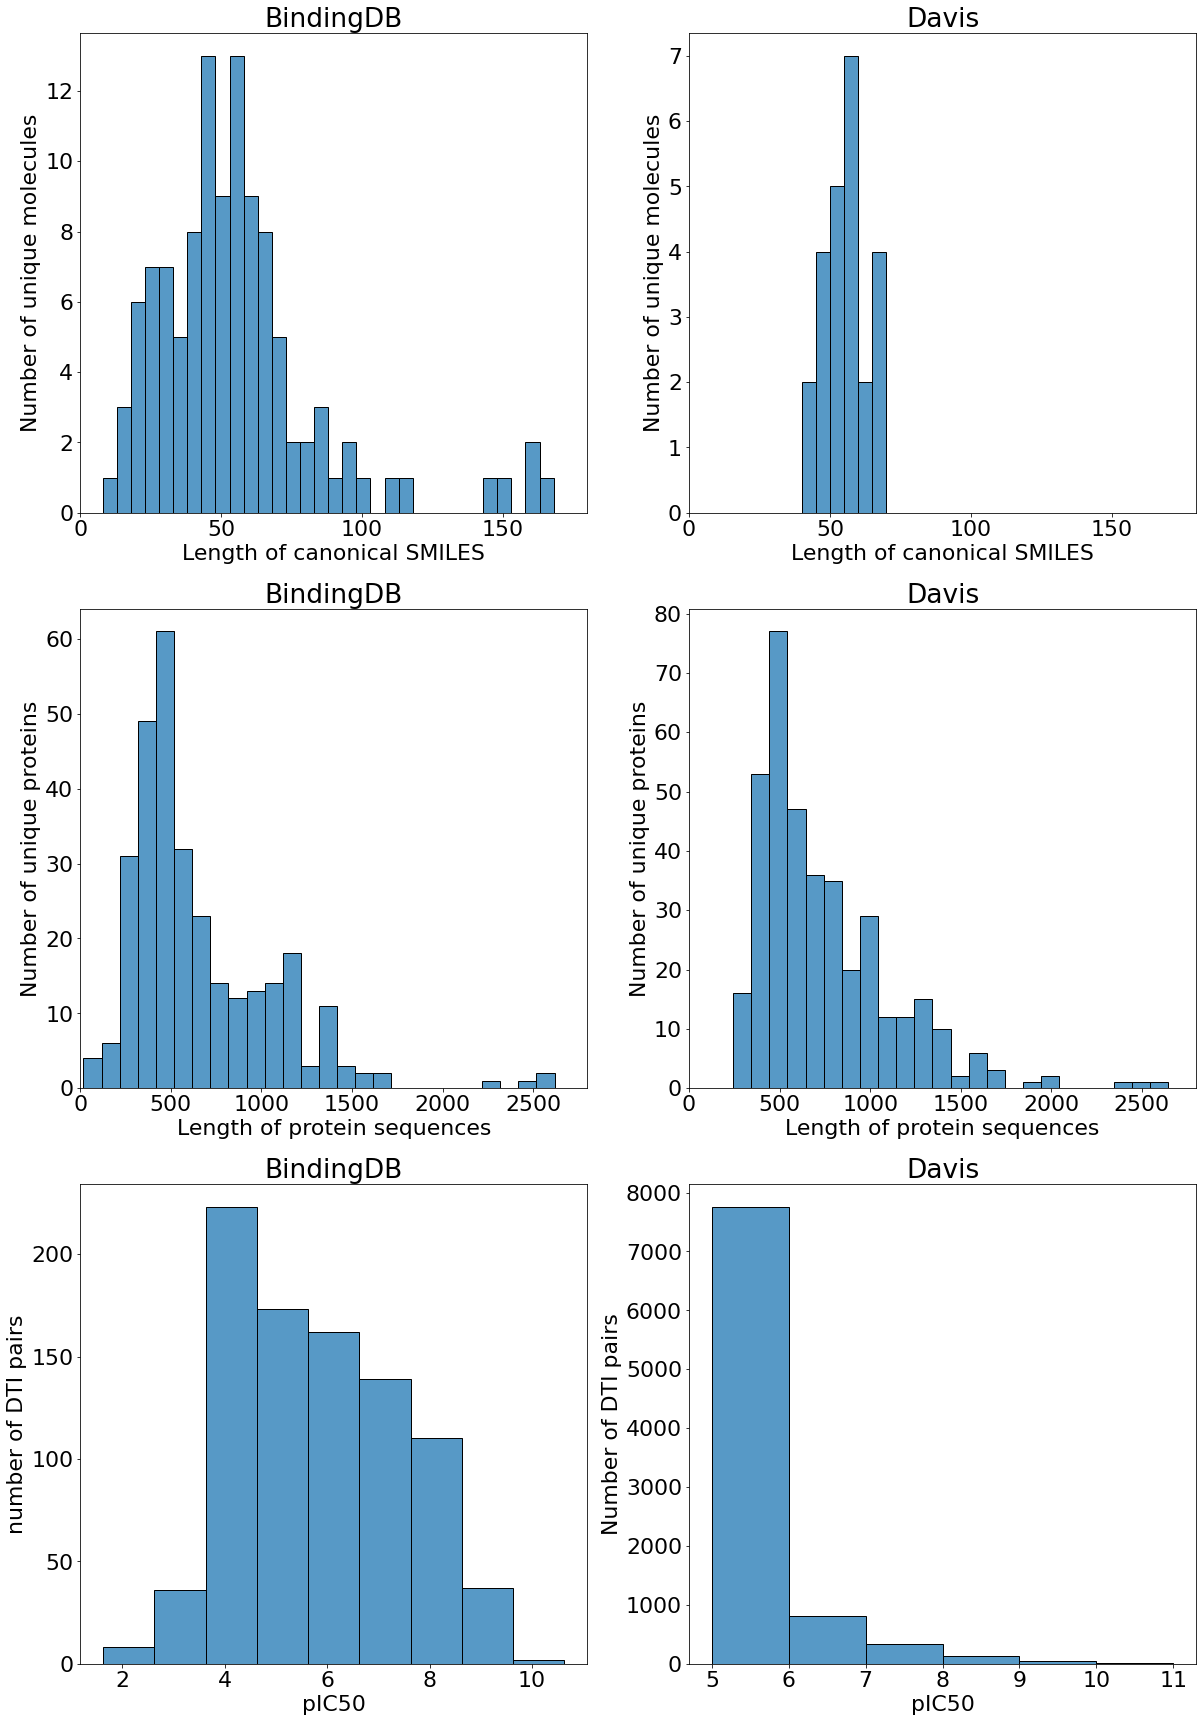

In [15]:
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,30))
axes = axes.flatten()

sns.histplot(data = df_myelo.drop_duplicates(subset = ['Canonical SMILES']),
             x = 'canonical_len', binwidth = 5, 
             #hue = 'Drug label',
             ax = axes[0],
            )
axes[0].set_title('BindingDB')
axes[0].set_xlabel('Length of canonical SMILES')
axes[0].set_ylabel('Number of unique molecules')
axes[0].set_xlim(0,180)

sns.histplot(data = df_davis_myelo.drop_duplicates(subset = ['Canonical SMILES']),
             x = 'canonical_len', binwidth = 5, 
             #hue = 'Drug label',
             ax = axes[1]
            )
axes[1].set_title('Davis')
axes[1].set_xlabel('Length of canonical SMILES')
axes[1].set_ylabel('Number of unique molecules')
axes[1].set_xlim(0,180)

sns.histplot(data = df_myelo.drop_duplicates(subset = ['BindingDB Target Chain Sequence']), 
            x = 'sequence_len', binwidth = 100,
            #hue = 'Drug label',
            ax = axes[2]
            )
axes[2].set_title('BindingDB')
axes[2].set_xlabel('Length of protein sequences')
axes[2].set_ylabel('Number of unique proteins')
axes[2].set_xlim(0,2800)

sns.histplot(data = df_davis_myelo.drop_duplicates(subset = ['Target']), 
            x = 'sequence_len', binwidth = 100,
            #hue = 'Drug label',
            ax = axes[3]
            )
axes[3].set_title('Davis')
axes[3].set_xlabel('Length of protein sequences')
axes[3].set_ylabel('Number of unique proteins')
axes[3].set_xlim(0,2800)

sns.histplot(data = df_myelo, 
            x = 'pIC50', binwidth = 1,
            #hue = 'Drug label',
            ax = axes[4]
            )
axes[4].set_title('BindingDB')
axes[4].set_xlabel('pIC50')
axes[4].set_ylabel('number of DTI pairs')

sns.histplot(data = df_davis_myelo, 
            x = 'pIC50', binwidth = 1,
            #hue = 'Drug label',
            ax = axes[5]
            )
axes[5].set_title('Davis')
axes[5].set_xlabel('pIC50')
axes[5].set_ylabel('Number of DTI pairs')
plt.savefig('AZ project/DeepCIM/Results/data_summary.jpg', dpi = 150)

In [16]:
cols = ['Canonical SMILES', 'Drug label', 'QED_score', 'MW', 'ALOGP', 'HBA', 'HBD', 'PSA', 'ROTB', 'AROM', 'ALERTS']
df_namebp = df_name[cols]
df_namebp['data'] = 'BindingDB'
df_name_davisbp = df_name_davis[cols]
df_name_davisbp['data'] = 'Davis'

<AxesSubplot:xlabel='data', ylabel='HBA'>

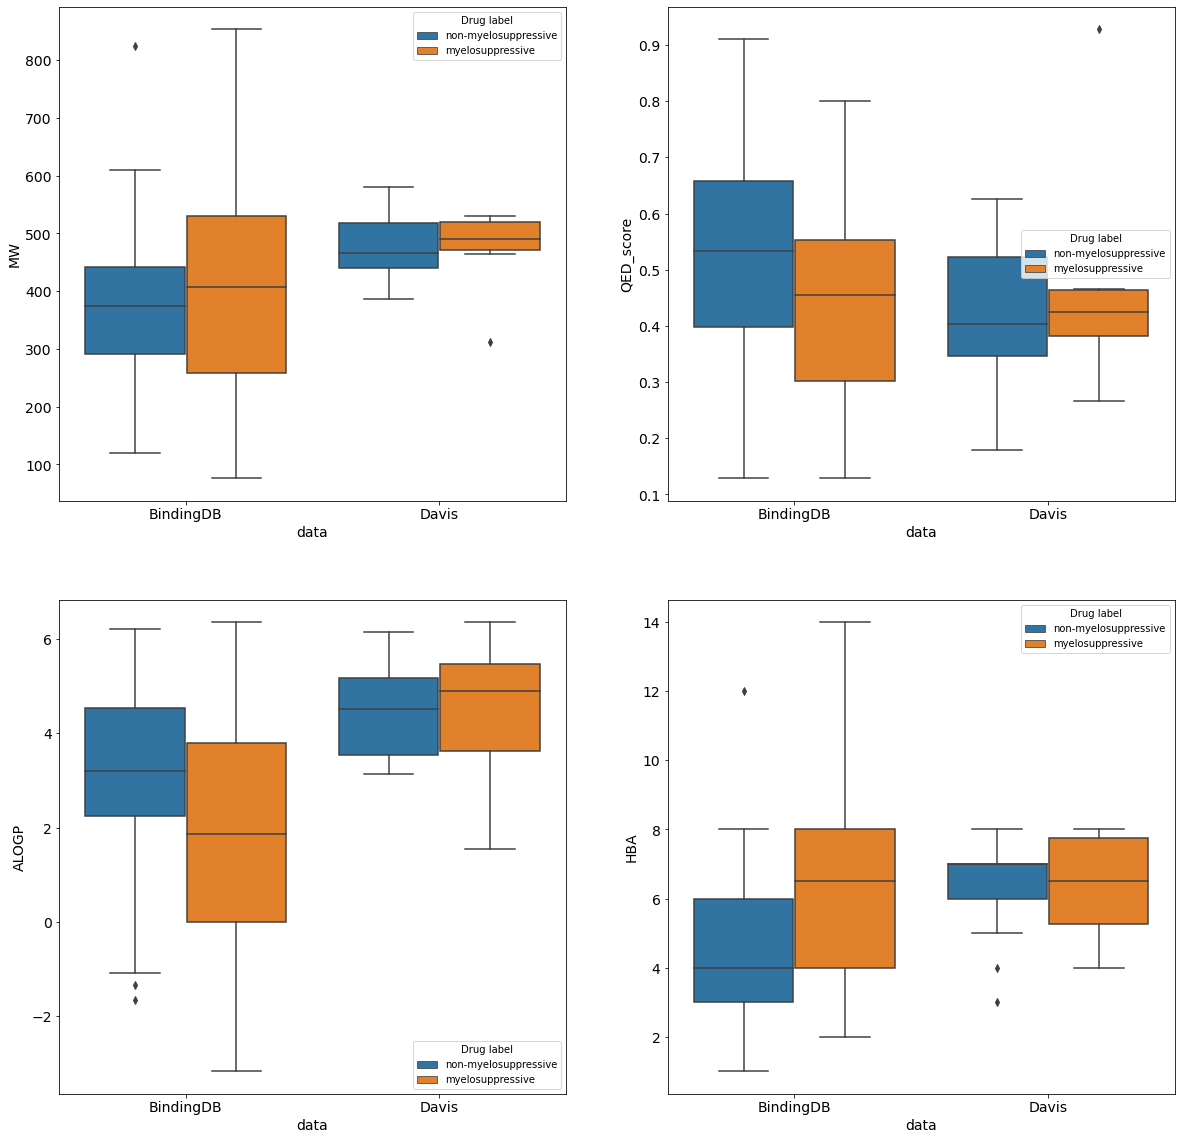

In [17]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))
axes = axes.flatten()

plt.rcParams.update({'font.size': 10})
sns.boxplot(data = pd.concat([df_namebp, df_name_davisbp]),
            x = 'data', y = 'MW', hue = 'Drug label',
            ax = axes[0]
           )

plt.rcParams.update({'font.size': 10})
sns.boxplot(data = pd.concat([df_namebp, df_name_davisbp]),
            x = 'data', y = 'QED_score', hue = 'Drug label',
            ax = axes[1]
           )

plt.rcParams.update({'font.size': 10})
sns.boxplot(data = pd.concat([df_namebp, df_name_davisbp]),
            x = 'data', y = 'ALOGP', hue = 'Drug label',
            ax = axes[2]
           )

plt.rcParams.update({'font.size': 10})
sns.boxplot(data = pd.concat([df_namebp, df_name_davisbp]),
            x = 'data', y = 'HBA', hue = 'Drug label',
            ax = axes[3]
           )

In [15]:
df_common = df_name_davis[df_name_davis['DBID'].isin(df_name['DBID'])]
print(np.unique(df_common['label'], return_counts = True))
df_unique = df_name_davis[~df_name_davis['DBID'].isin(df_name['DBID'])]
print(np.unique(df_unique['label'], return_counts = True))

(array([0., 1.]), array([9, 5], dtype=int64))
(array([0., 1.]), array([9, 1], dtype=int64))


In [16]:
df_name['mols'] = df_name['Canonical SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_name['label'] = df_name['label'].astype(int)
df_name_davis['mols'] = df_name_davis['Canonical SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_name_davis['label'] = df_name_davis['label'].astype(int)
df_common['mols'] = df_common['Canonical SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_common['label'] = df_common['label'].astype(int)
df_unique['mols'] = df_unique['Canonical SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_unique['label'] = df_unique['label'].astype(int)

In [17]:
print(np.unique(df_name['Drug label'], return_counts = True))
print(np.unique(df_name_davis['Drug label'], return_counts = True))

(array(['myelosuppressive', 'non-myelosuppressive'], dtype=object), array([44, 68], dtype=int64))
(array(['myelosuppressive', 'non-myelosuppressive'], dtype=object), array([ 6, 18], dtype=int64))


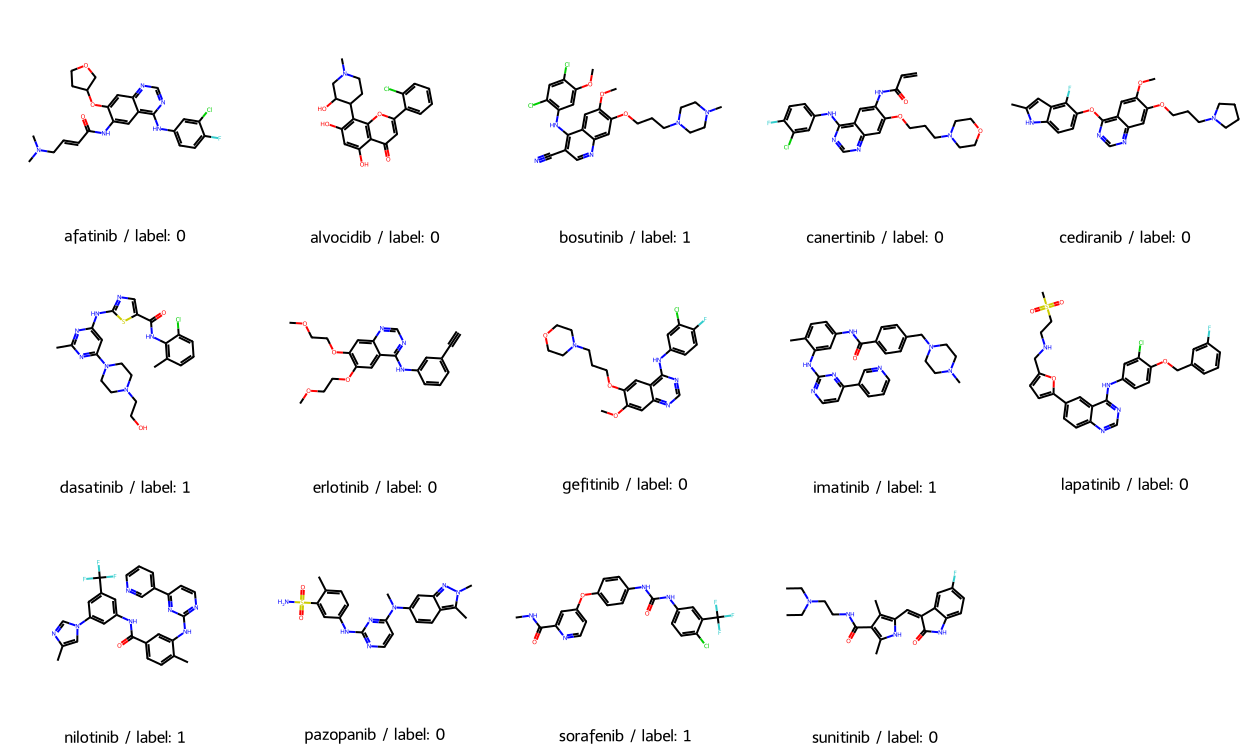

In [18]:
fig = Draw.MolsToGridImage(mols = df_common['mols'],
                     legends = list(df_common['name'] + ' / label: ' + df_common['label'].astype(str)),
                    molsPerRow = 5, maxMols=50, subImgSize = (250,250), returnPNG=False
                    )
fig.save('AZ project/DeepCIM/Results/poster/davis_common.jpg')
display(fig)

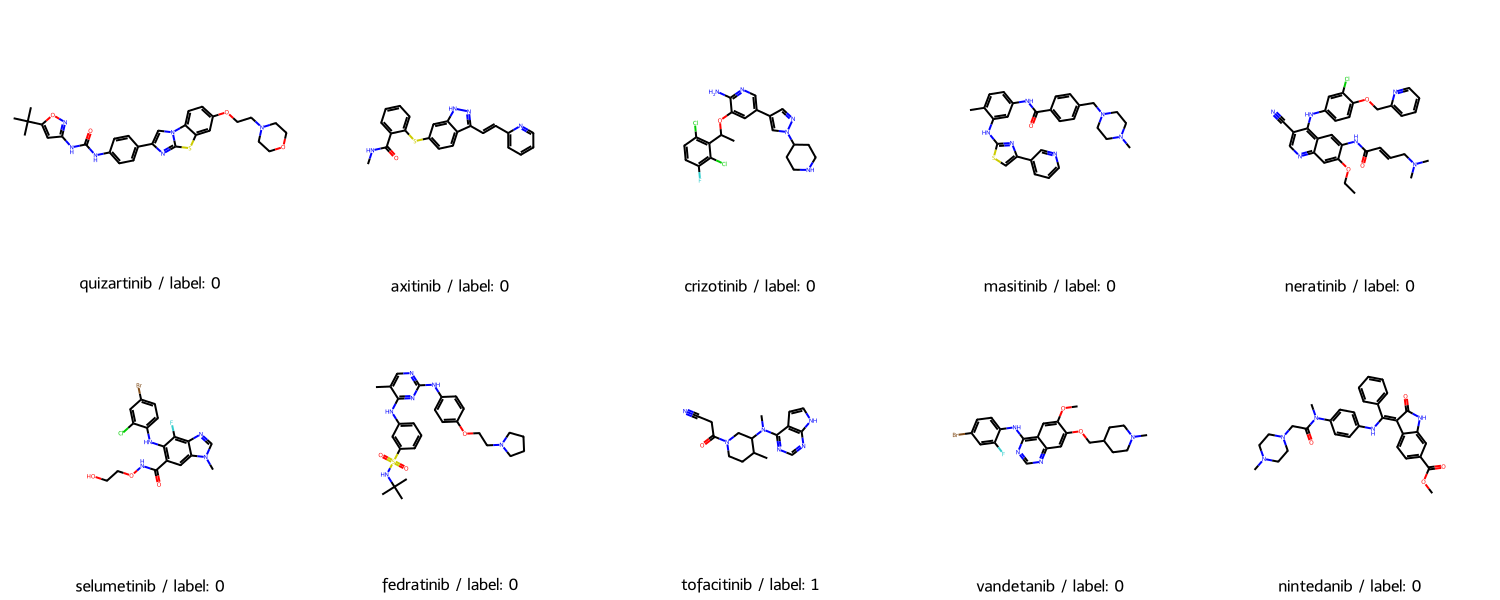

In [19]:
fig = Draw.MolsToGridImage(mols = df_unique['mols'],
                     legends = list(df_unique['name'] + ' / label: ' + df_unique['label'].astype(str)),
                    molsPerRow = 5, maxMols=50, subImgSize = (300,300), returnPNG=False
                    )
fig.save('AZ project/DeepCIM/Results/poster/davis_unique.jpg')
display(fig)

### Pivot

In [20]:
df_myelo_target = pd.DataFrame({'Target Name':np.unique(df_myelo['Uniprot Name'], return_counts = True)[0],
                          'Drug Instances':np.unique(df_myelo['Uniprot ID'], return_counts = True)[1]})
df_myelo_target = df_myelo_target.sort_values(by = 'Drug Instances', ascending = False)
df_myelo_target = df_myelo_target[df_myelo_target['Drug Instances'] > 10]
display(df_myelo_target)
print(df_myelo_target['Drug Instances'].sum())

df_davis_myelo_target = pd.DataFrame({'Target Name':np.unique(df_davis_myelo['Target_ID'], return_counts = True)[0],
                          'Drug Instances':np.unique(df_davis_myelo['Target_ID'], return_counts = True)[1]})
df_davis_myelo_target = df_davis_myelo_target.sort_values(by = 'Drug Instances', ascending = False)
df_davis_myelo_target = df_davis_myelo_target[df_davis_myelo_target['Drug Instances'] > 10]
display(df_davis_myelo_target)
print(df_davis_myelo_target['Drug Instances'].sum())

,Target Name,Drug Instances
14,ANDR,53
15,AOXA,53
40,CD5R1,23
39,CCNT1,18
280,TYSY,17
70,DHB2,15
146,KCNH2,14
73,DPP3,14
222,PMYT1,14
102,GBRR1,11


243


,Target Name,Drug Instances
0,AAK1,24
249,PDGFRB,24
258,PIK3C2G,24
257,PIK3C2B,24
256,PHKG2,24
...,...,...
124,FGFR1,24
123,FES,24
122,FER,24
121,FAK,24


9096


In [23]:
print('Matching targets')
print('by protein sequence:',len(set(df_myelo['BindingDB Target Chain Sequence']) & set(df_davis_myelo['Target'])))
#print('by uniprot id:',len(set(df_myelo['Uniprot Name']) & set(df_davis_myelo['Target_ID'])))

Matching targets
by protein sequence: 87


In [24]:
myelo_target = list(df_myelo['Uniprot Name'].unique())
davis_myelo_target = list(df_davis_myelo['Target_ID'].unique())
print(len(myelo_target), len(davis_myelo_target))
pivot_columns = np.unique(myelo_target + davis_myelo_target)
print(pivot_columns.shape)

df_myelo_pivot = df_myelo.pivot_table(values = 'pIC50', index = 'Canonical SMILES', columns = 'Uniprot Name', 
                           fill_value = 0, aggfunc = 'mean').reset_index()
df_davis_myelo_pivot = df_davis_myelo.pivot_table(values = 'pIC50', index = 'Canonical SMILES', columns = 'Target_ID', 
                           fill_value = 0, aggfunc = 'mean').reset_index()

df_bdb_pivot = df_myelo_pivot.reindex(columns = ['Canonical SMILES'] + list(pivot_columns))
df_bdb_pivot = df_bdb_pivot.fillna(0)
df_bdb_pivot = pd.merge(df_bdb_pivot, df_name[['Canonical SMILES', 'name', 'label','Drug label']],
         how = 'inner', left_on = 'Canonical SMILES', right_on = 'Canonical SMILES')

df_davis_pivot = df_davis_myelo_pivot.reindex(columns = ['Canonical SMILES'] + list(pivot_columns))
df_davis_pivot = df_davis_pivot.fillna(0)
df_davis_pivot = pd.merge(df_davis_pivot, df_name_davis[['Canonical SMILES', 'name', 'label', 'Drug label']],
         how = 'inner', left_on = 'Canonical SMILES', right_on = 'Canonical SMILES')

print(df_myelo_pivot.shape, df_bdb_pivot.shape, df_davis_myelo_pivot.shape, df_davis_pivot.shape)

288 379
(615,)
(112, 289) (112, 619) (24, 380) (24, 619)


In [25]:
df_bdb_common = df_bdb_pivot[df_bdb_pivot['name'].isin(df_common['name'])].reset_index().drop(columns = 'index')
df_davis_common = df_davis_pivot[df_davis_pivot['name'].isin(df_common['name'])].reset_index().drop(columns = 'index')
print(df_bdb_common.shape)
print(df_davis_common.shape)

(14, 619)
(14, 619)


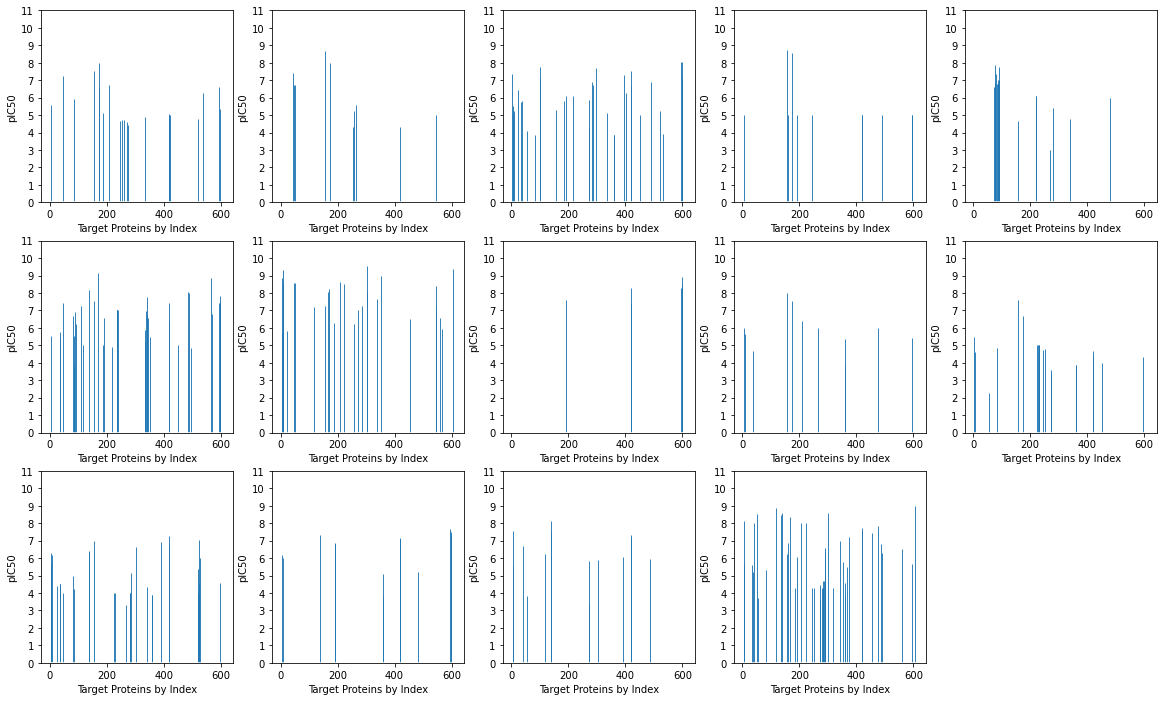

In [34]:
show_proteomic_profile(np.array(df_bdb_common.iloc[:,1:-3]))

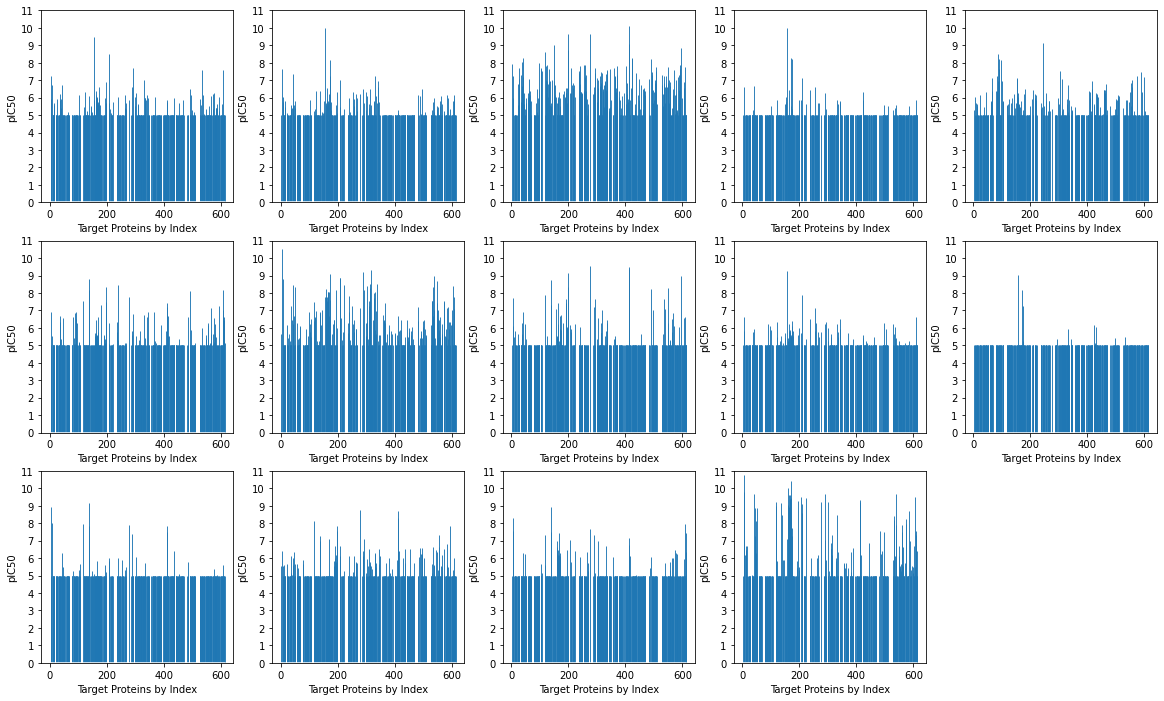

In [35]:
show_proteomic_profile(np.array(df_davis_common.iloc[:,1:-3]))

In [36]:
df_bdb_common[df_bdb_common['label'] == 1]

,Canonical SMILES,1433G,6PGD,A4,AAK1,ABCG2,ABL1,ABL1p,ABL2,ACES,...,YSK4,ZAK,ZAP70,p38-alpha,p38-beta,p38-delta,p38-gamma,name,label,Drug label
5,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,0.0,0.0,0.0,0.0,5.508638,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sorafenib,1,myelosuppressive
6,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.0,0.0,0.0,0.0,5.698970,8.854256,0.0,9.301030,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bosutinib,1,myelosuppressive
10,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.0,0.0,0.0,0.0,5.658150,6.286542,0.0,6.188477,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,imatinib,1,myelosuppressive
12,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,0.0,0.0,0.0,0.0,5.602060,7.539103,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nilotinib,1,myelosuppressive
13,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.0,0.0,0.0,0.0,5.698970,8.128942,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dasatinib,1,myelosuppressive


In [37]:
df_davis_common[df_davis_common['label'] == 1]

,Canonical SMILES,1433G,6PGD,A4,AAK1,ABCG2,ABL1,ABL1p,ABL2,ACES,...,YSK4,ZAK,ZAP70,p38-alpha,p38-beta,p38-delta,p38-gamma,name,label,Drug label
5,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,0.0,0.0,0.0,5.000000,0.0,0.0,6.886057,5.537602,0.0,...,7.004365,8.200659,5.00000,6.431798,6.638272,5.180456,5.119186,sorafenib,1,myelosuppressive
6,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.0,0.0,0.0,5.638272,0.0,0.0,10.537602,8.823909,0.0,...,7.795880,7.096910,5.79588,5.000000,5.000000,5.000000,5.000000,bosutinib,1,myelosuppressive
10,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.0,0.0,0.0,5.000000,0.0,0.0,8.958607,8.000000,0.0,...,5.000000,5.585027,5.00000,5.000000,5.000000,5.000000,5.000000,imatinib,1,myelosuppressive
12,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,0.0,0.0,0.0,5.000000,0.0,0.0,8.309804,7.585027,0.0,...,5.000000,7.958607,5.00000,6.337242,7.443697,5.000000,5.000000,nilotinib,1,myelosuppressive
13,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.0,0.0,0.0,5.000000,0.0,0.0,10.795880,9.769551,0.0,...,7.102373,7.346787,5.00000,7.568636,6.387216,5.000000,5.000000,dasatinib,1,myelosuppressive


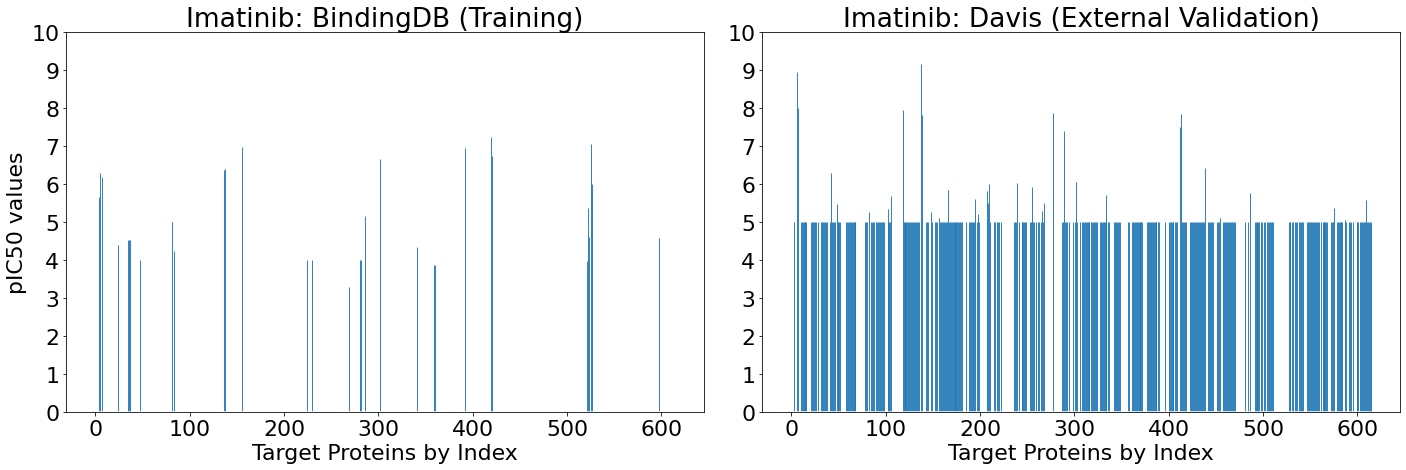

In [143]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize = (20,7))

plt.subplot(1,2,1)
plt.ylim(0,10)
plt.yticks(np.arange(0, 10+0.001, 1))
plt.ylabel('pIC50 values')
plt.xlabel('Target Proteins by Index')
plt.title('Imatinib: BindingDB (Training)')
markerline, stemline, baseline = plt.stem(df_bdb_common.iloc[10, 1:-3].to_numpy(),
        markerfmt = ' '
        )
plt.setp(stemline, linewidth = 0.9)
plt.setp(baseline, color = 'w')


plt.subplot(1,2,2)
plt.ylim(0,10)
plt.yticks(np.arange(0, 10+0.001, 1))
#plt.ylabel('pIC50 values')
plt.xlabel('Target Proteins by Index')
plt.title('Imatinib: Davis (External Validation)')
markerline, stemline, baseline = plt.stem(df_davis_common.iloc[10, 1:-3].to_numpy(),
        markerfmt = ' '
        )
plt.setp(stemline, linewidth = 0.9)
plt.setp(baseline, color = 'w')
plt.tight_layout()
plt.savefig('AZ project/DeepCIM/Results/poster/proteomic_sig.jpg', dpi = 150)

In [32]:
print(np.count_nonzero(df_bdb_common.iloc[10, 1:-3]))
print(np.count_nonzero(df_davis_common.iloc[10, 1:-3]))

32
379


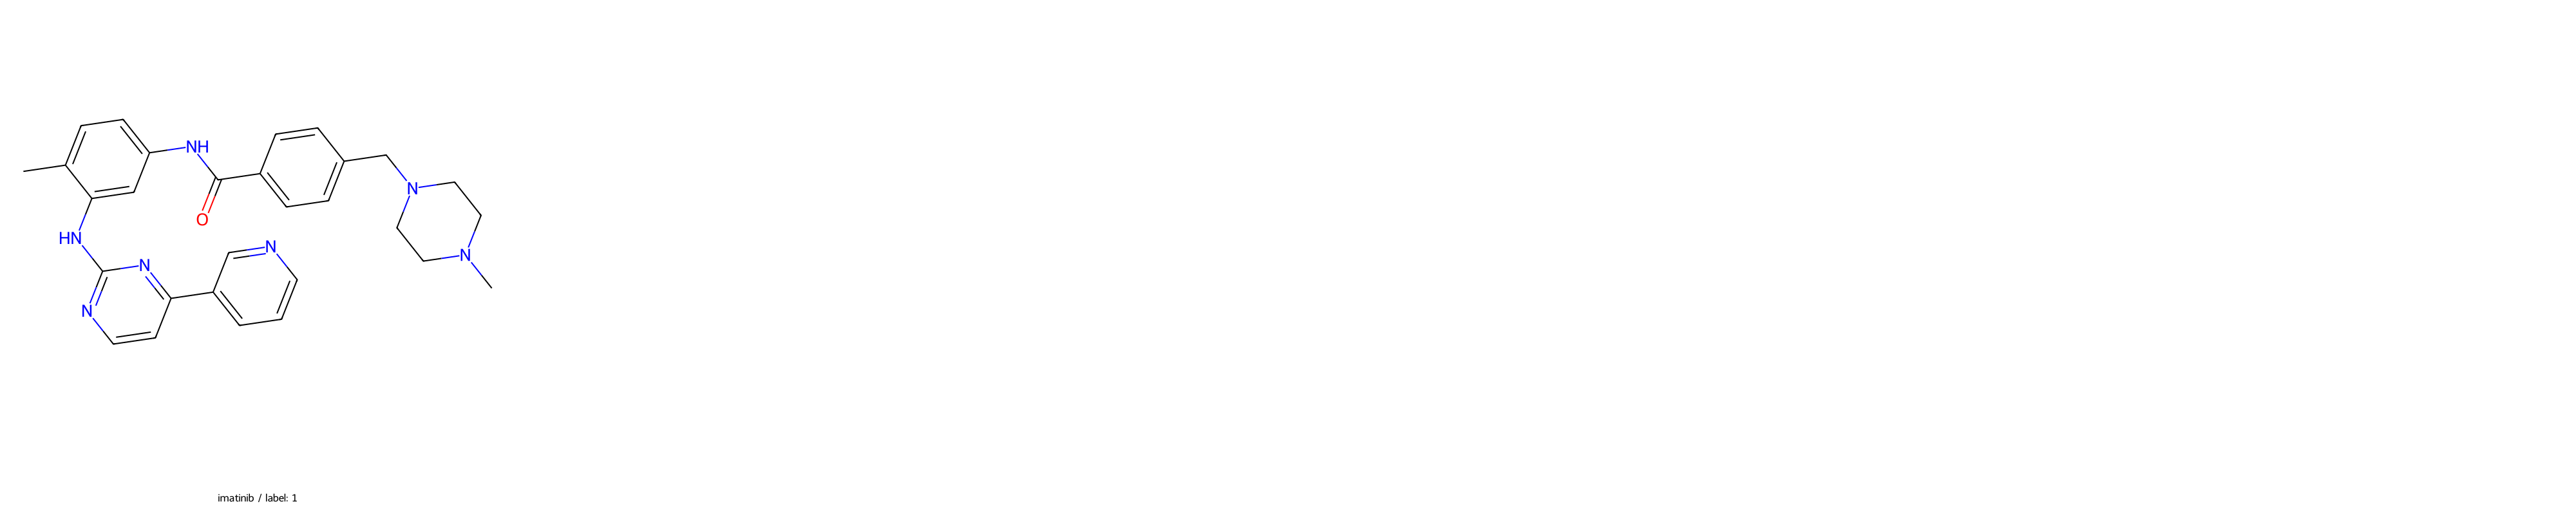

In [40]:
fig = Draw.MolsToGridImage(mols = df_name_davis[df_name_davis['name'] == 'imatinib']['mols'],
                     legends = list(df_name_davis[df_name_davis['name'] == 'imatinib']['name'] + ' / label: ' + 
                                    df_name_davis[df_name_davis['name'] == 'imatinib']['label'].astype(str)),
                    molsPerRow = 5, maxMols=50, subImgSize = (800,800), returnPNG=False
                    )
fig.save('AZ project/DeepCIM/Results/poster/imatinib.jpg')
display(fig)

In [33]:
df_name_davis[df_name_davis['name'] == 'imatinib']['mols']

10233    <rdkit.Chem.rdchem.Mol object at 0x000001D4A06...
Name: mols, dtype: object

In [33]:
def show_proteomic_profile(proteomic_signature):
    plt.figure(figsize = ((20,(proteomic_signature.shape[0]//5+1)*4)))
    #if proteomic_signature.shape[0] > 20:
        #plt.figure(figsize = ((proteomic_signature.shape[0]//5+1)*4,(proteomic_signature.shape[0]//5+1)*4))
    #plt.ylim(-1,1)
    for i in range(proteomic_signature.shape[0]):
        plt.subplot(proteomic_signature.shape[0]//5 + 1, 5, i+1)
        plt.ylim(0,10)
        plt.yticks(np.arange(0, 12, 1))
        plt.ylabel('pIC50')
        plt.xlabel('Target Proteins by Index')
        #plt.tight_layout()
        markerline, stemline, baseline = plt.stem(proteomic_signature[i,:],
                markerfmt = ' '
                )
        plt.setp(stemline, linewidth = 0.9)
        plt.setp(baseline, color = 'w')

In [126]:
df_poster = pd.DataFrame({'Model':['DeepCIM', 'Linear SVM', 'DeepCIM', 'Linear SVM'],
             'Dataset':['BindingDB', 'BindingDB', 'Davis', 'Davis'],
             #'Morgan':[0.667, 0.652, 0.792, 0.792],
             'Biological Information': [0.618, 0.624, 0.508, 0.471],
             'Chemical Information':[0.667, 0.739, 0.750, 0.708],
             'Chemical + Biological':[1.0, 0.955, 0.784, 0.705],
             #'Common':[None, None, 0.919, 0.780]
                         })
df_poster

,Model,Dataset,Chemical Information,Biological Information,Chemical + Biological
0,DeepCIM,BindingDB,0.667,0.618,1.000
1,Linear SVM,BindingDB,0.739,0.624,0.955
2,DeepCIM,Davis,0.750,0.508,0.784
3,Linear SVM,Davis,0.708,0.471,0.705


In [168]:
df_poster = pd.DataFrame({'Model':['DeepCIM', 'Linear SVM', 'DeepCIM', 'Linear SVM'],
             'Dataset':['Training', 'Training', 'External', 'External'],
             #'Morgan':[0.667, 0.652, 0.792, 0.792],
             'Biological Info': [0.618, 0.624, 0.508, 0.471],
             'Chemical Info':[0.667, 0.739, 0.750, 0.708],
             'Both Info':[1.0, 0.955, 0.784, 0.705],
             #'Common':[None, None, 0.919, 0.780]
                         })
df_poster

,Model,Dataset,Biological Info,Chemical Info,Both Info
0,DeepCIM,Training,0.618,0.667,1.000
1,Linear SVM,Training,0.624,0.739,0.955
2,DeepCIM,External,0.508,0.750,0.784
3,Linear SVM,External,0.471,0.708,0.705


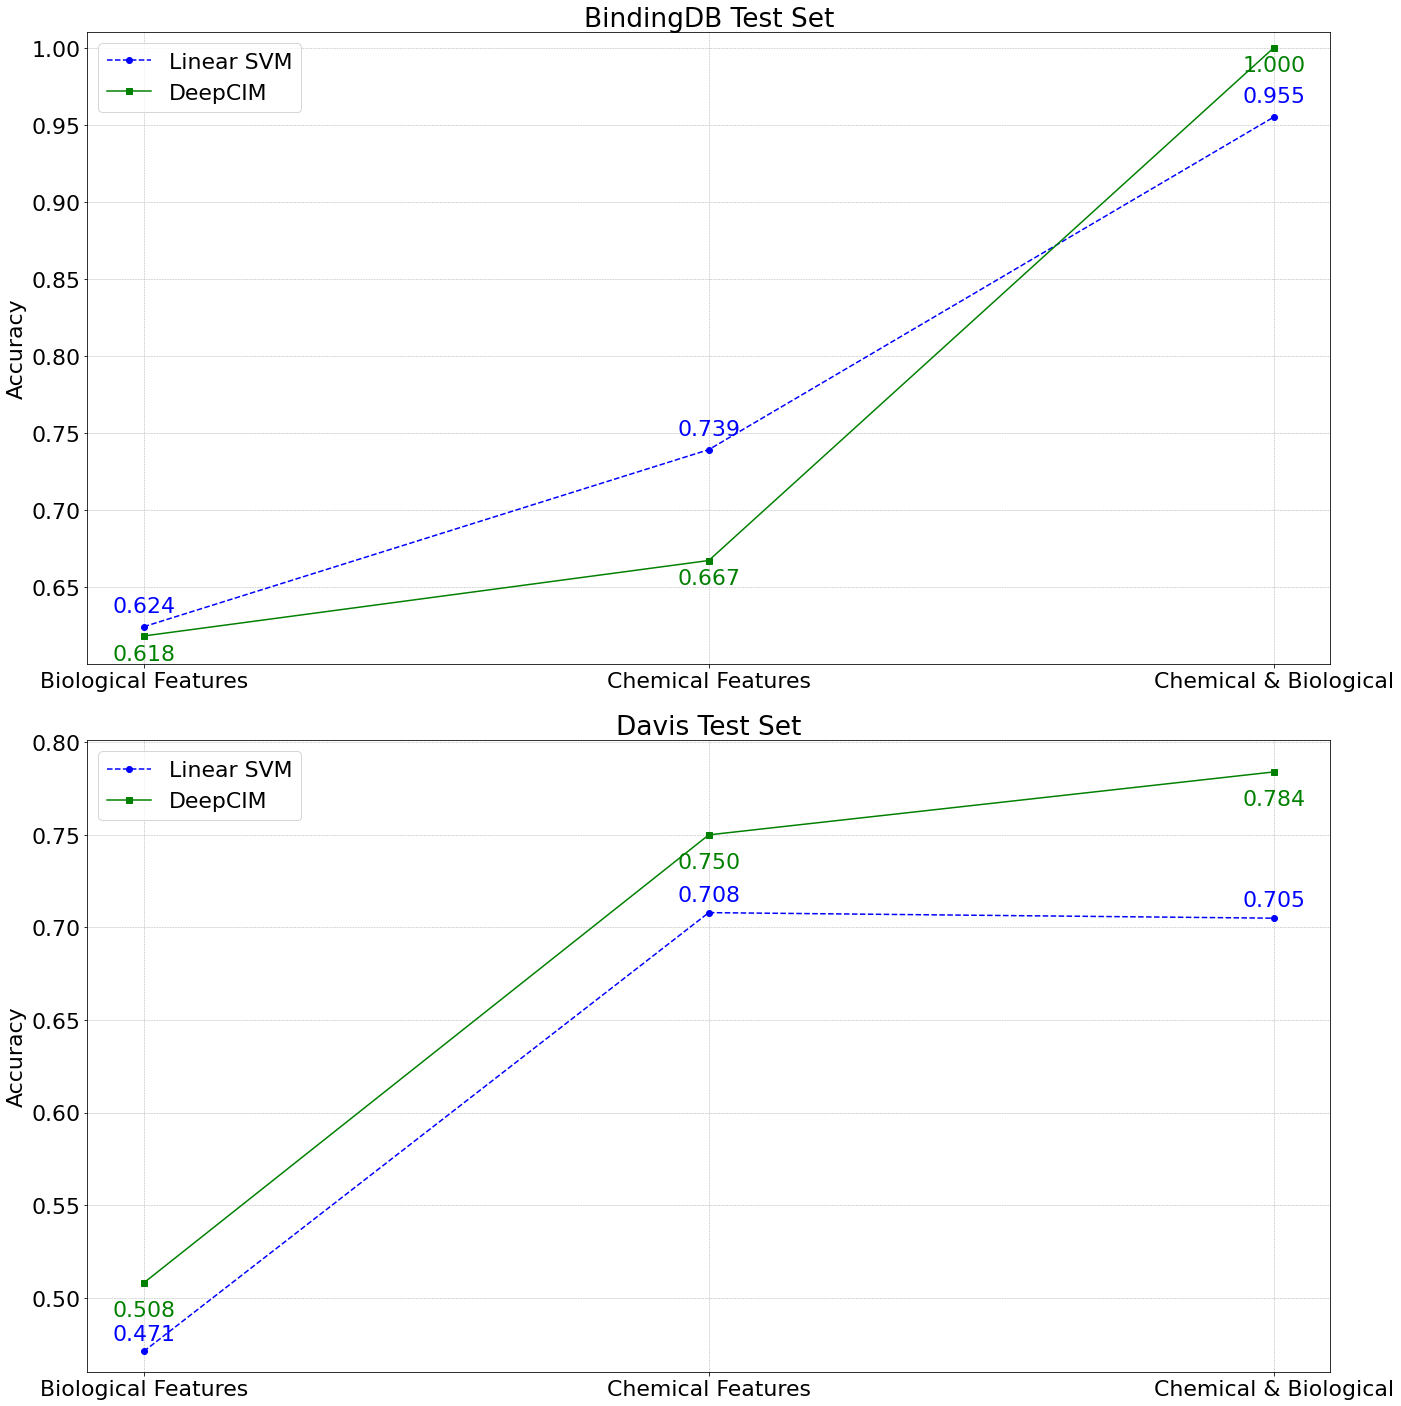

In [254]:
# Setting up the data for the subplots
features = ['Biological Features', 'Chemical Features', 'Chemical & Biological']

# Accuracies for the BindingDB Test Set
accuracies_deepcim_bindingdb = [0.618, 0.667, 1.000]
accuracies_linearsvm_bindingdb = [0.624, 0.739, 0.955]

# Accuracies for the Davis Test Set
accuracies_deepcim_davis = [0.508, 0.750, 0.784]
accuracies_linearsvm_davis = [0.471, 0.708, 0.705]

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

# Plot for BindingDB Test Set
axes[0].plot(features, accuracies_linearsvm_bindingdb, marker='o', linestyle='--', label='Linear SVM', color='blue')
axes[0].plot(features, accuracies_deepcim_bindingdb, marker='s', linestyle='-', label='DeepCIM', color='green')
axes[0].set_title('BindingDB Training Test Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.60001, 1.01)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].legend()

# Annotate the accuracy on each point for BindingDB
for i, (accA, accB) in enumerate(zip(accuracies_linearsvm_bindingdb, accuracies_deepcim_bindingdb)):
    axes[0].text(i, accA + 0.02, f'{accA:.3f}', ha='center', va='top', color='blue')
    axes[0].text(i, accB - 0.018, f'{accB:.3f}', ha='center', va='bottom', color='green')

# Plot for Davis Test Set
axes[1].plot(features, accuracies_linearsvm_davis, marker='o', linestyle='--', label='Linear SVM', color='blue')
axes[1].plot(features, accuracies_deepcim_davis, marker='s', linestyle='-', label='DeepCIM', color='green')
axes[1].set_title('Davis External Test Set')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.46, 0.801)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].legend()

# Annotate the accuracy on each point for Davis
for i, (accA, accB) in enumerate(zip(accuracies_linearsvm_davis, accuracies_deepcim_davis)):
    axes[1].text(i, accA + 0.015, f'{accA:.3f}', ha='center', va='top', color='blue')
    axes[1].text(i, accB - 0.02, f'{accB:.3f}', ha='center', va='bottom', color='green')

plt.tight_layout()
plt.savefig('AZ project/DeepCIM/Results/poster/Testset.jpg', dpi = 150)
plt.show()


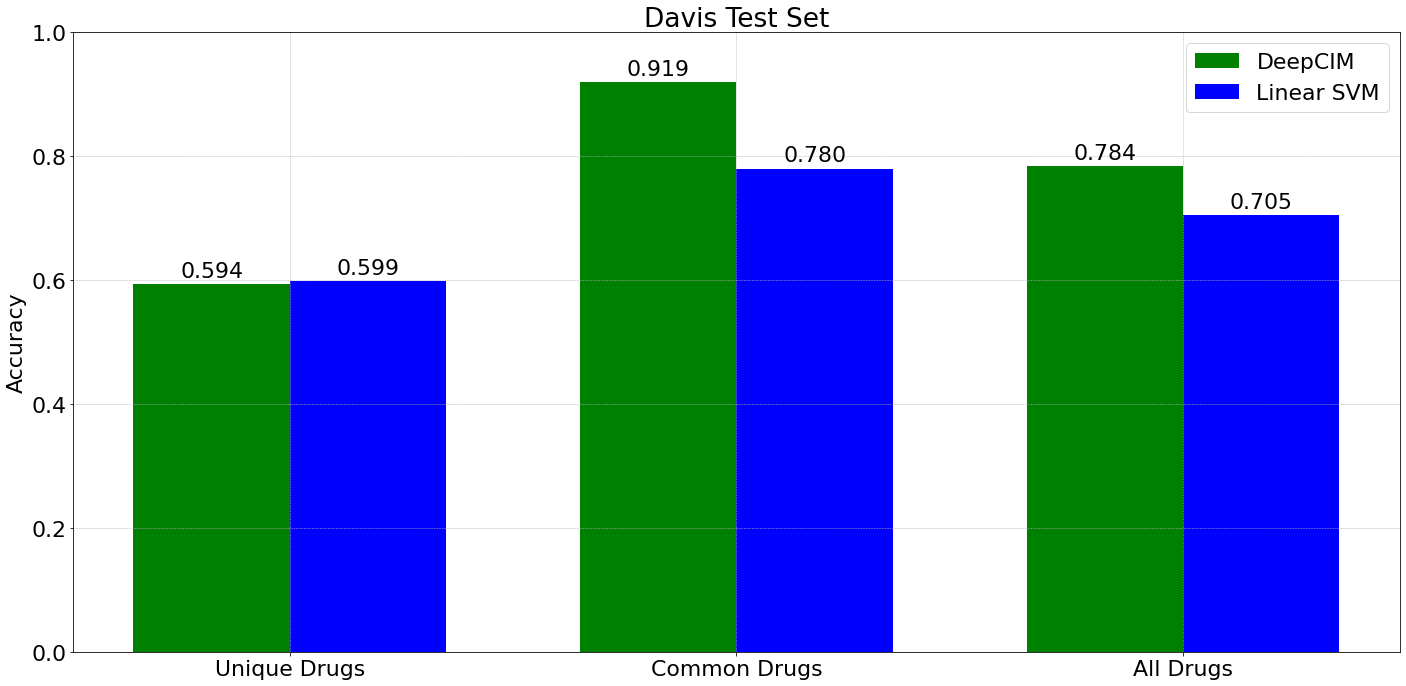

In [266]:
# DeepCIM and SVM for the external validation dataset
accuracies_deepcim = [0.594, 0.919, 0.784]
accuracies_svm = [0.599, 0.780, 0.705]
x = np.arange(len(accuracies_deepcim))  # the label locations for the groups
bar_width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize = (20,10))
rects1 = ax.bar(x - bar_width/2, accuracies_deepcim, bar_width, label='DeepCIM', color='green')
rects2 = ax.bar(x + bar_width/2, accuracies_svm, bar_width, label='Linear SVM', color='blue')

# Add some text for labels, title, and custom x-axis tick labels

ax.set_ylabel('Accuracy')
ax.set_title('Davis Test Set')
ax.set_xticks(x)
ax.set_xticklabels(['Unique Drugs', 'Common Drugs', 'All Drugs'])
ax.set_ylim(0, 1.)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('AZ project/DeepCIM/Results/poster/Testset_davis.jpg', dpi = 150)
plt.show()


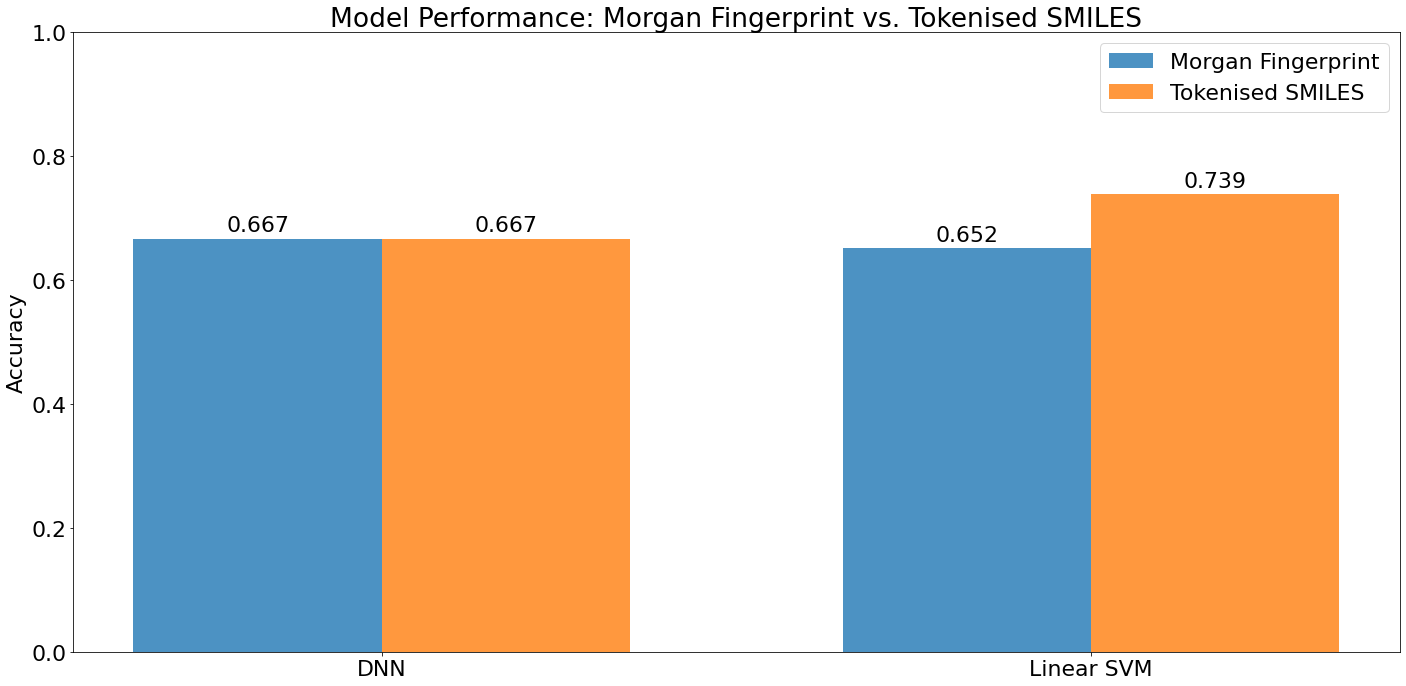

In [272]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
models = ['DNN', 'Linear SVM']
morgan_scores = [0.667, 0.652]
smiles_scores = [0.667, 0.739]

# Creating the plot
fig, ax = plt.subplots(figsize=(20, 10))

index = range(len(models))
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, morgan_scores, bar_width, alpha=opacity, label='Morgan Fingerprint')
rects2 = ax.bar([p + bar_width for p in index], smiles_scores, bar_width, alpha=opacity, label='Tokenised SMILES')

ax.set_ylabel('Accuracy')
ax.set_title('Model Performance: Morgan Fingerprint vs. Tokenised SMILES')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

# Adding accuracy scores on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.savefig('AZ project/DeepCIM/Results/poster/MorganvsSMILES.jpg', dpi = 150)
plt.show()

In [41]:
def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)
    
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None


def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(tqdm(smiles_list)):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

In [42]:
## Tokenise uising larger dataset

all_smiles = df_IC['Canonical SMILES'].unique()
all_proteins = df_IC['BindingDB Target Chain Sequence'].unique()
print(len(all_smiles), len(all_proteins))

# Tokenise SMILES and A.A. Target Sequences

smiles_tokenizer = Tokenizer(char_level = True)
smiles_tokenizer.fit_on_texts(all_smiles)
smiles_word_index = smiles_tokenizer.word_index
smiles_vocab_size = len(smiles_word_index)

proteins_tokenizer = Tokenizer(char_level = True)
proteins_tokenizer.fit_on_texts(all_proteins)
proteins_word_index = proteins_tokenizer.word_index
proteins_vocab_size = len(proteins_word_index)
print(smiles_vocab_size, proteins_vocab_size)

507154 1704
44 20


In [54]:
from tensorflow.keras.utils import to_categorical

df_chem = df_myelo.drop_duplicates(subset = ['Canonical SMILES'])

smiles = df_chem['Canonical SMILES'].to_numpy()
proteins = df_chem['BindingDB Target Chain Sequence'].to_numpy()
pIC50 = df_chem['pIC50'].to_numpy()
labels = to_categorical(df_chem['label'])
print('number of unique target sequence:',len(np.unique(proteins)))
print('number of unique smiles (molecules):',len(np.unique(smiles)))

# Train test val split using scikit learn

train_smiles, eval_smiles, train_proteins, eval_proteins, train_pIC50, eval_pIC50, train_labels, eval_labels = \
train_test_split(smiles, proteins, pIC50, labels, test_size = 0.2, random_state = 1279)


val_smiles, test_smiles, val_proteins, test_proteins, val_pIC50, test_pIC50, val_labels, test_labels = \
train_test_split(eval_smiles, eval_proteins, eval_pIC50, eval_labels, test_size = 0.5, random_state = 929)

print(np.unique(np.argmax(train_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(val_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(test_labels, axis = 1), return_counts = True))

# Train val test share some SMILES string as the model is trained on Drug-Target Interaction datapoints
# Not SMILES - Target pIC50 values (This will be carried out later at "PIVOT" section)
print('Train SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(train_smiles)].label, return_counts = True))
print('Val SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(val_smiles)].label, return_counts = True))
print('Test SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(test_smiles)].label, return_counts = True))

train_smiles_sequences = smiles_tokenizer.texts_to_sequences(train_smiles)
train_smiles_padded = pad_sequences(train_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
val_smiles_sequences = smiles_tokenizer.texts_to_sequences(val_smiles)
val_smiles_padded = pad_sequences(val_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
test_smiles_sequences = smiles_tokenizer.texts_to_sequences(test_smiles)
test_smiles_padded = pad_sequences(test_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

train_proteins_sequences = proteins_tokenizer.texts_to_sequences(train_proteins)
train_proteins_padded = pad_sequences(train_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
val_proteins_sequences = proteins_tokenizer.texts_to_sequences(val_proteins)
val_proteins_padded = pad_sequences(val_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
test_proteins_sequences = proteins_tokenizer.texts_to_sequences(test_proteins)
test_proteins_padded = pad_sequences(test_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

number of unique target sequence: 56
number of unique smiles (molecules): 112
(array([0, 1], dtype=int64), array([53, 36], dtype=int64))
(array([0, 1], dtype=int64), array([8, 3], dtype=int64))
(array([0, 1], dtype=int64), array([7, 5], dtype=int64))
Train SMILES: (array([0, 1]), array([53, 36], dtype=int64))
Val SMILES: (array([0, 1]), array([8, 3], dtype=int64))
Test SMILES: (array([0, 1]), array([7, 5], dtype=int64))


In [59]:
train_smiles.shape

(89,)

In [44]:
## Morgan fingerprint
train_smiles_fp, _= compute_ecfp_descriptors(train_smiles)
val_smiles_fp, _ = compute_ecfp_descriptors(val_smiles)
test_smiles_fp, _ = compute_ecfp_descriptors(test_smiles)

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 859.43it/s]


# SMILES only

### morgan fp

In [45]:
tf.keras.backend.clear_session()

smile_input = Input(shape = (2048,), name = 'SMILES')
#protein_input = Input(shape = (2600,), name = 'Proteins')
#pIC50_input = Input(shape = (1,), name = 'pIC50')

fw = Dense(1024, activation = 'relu')(smile_input)
fw = Dropout(0.1)(fw)
fw = Dense(512, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(256, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(128, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(32, activation = 'relu')(fw)
out_layer = Dense(2, activation = 'sigmoid')(fw)

model = Model(inputs = [smile_input], outputs = out_layer)
opt = optimizers.Adam(learning_rate = 0.000001)
model.compile(loss = 'BinaryCrossentropy', optimizer = opt, metrics = ['Accuracy'])

###############################################################################################
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                          patience = 100, verbose = 1,
                          #restore_best_weights = True
                          ) 
#checkpoint = ModelCheckpoint('AZ project/DeepCIM/82mse_500adam0005b256_bestval.h5',
#                            monitor = 'val_loss', mode = 'min',
#                            save_best_only = True, verbose = 1
#                            )

In [46]:
history = model.fit(
    x = [train_smiles_fp],
    y = train_labels,
    epochs = 500, batch_size = 32,
    validation_data = ([val_smiles_fp], val_labels),
    callbacks = [early_stop]#, checkpoint]
)

Epoch 1/500
3/3 [==============================] - 2s 84ms/step - loss: 0.6948 - Accuracy: 0.4944 - val_loss: 0.6939 - val_Accuracy: 0.5455
Epoch 2/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6956 - Accuracy: 0.4831 - val_loss: 0.6938 - val_Accuracy: 0.5455
Epoch 3/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6940 - Accuracy: 0.5393 - val_loss: 0.6937 - val_Accuracy: 0.5455
Epoch 4/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6911 - Accuracy: 0.6180 - val_loss: 0.6936 - val_Accuracy: 0.5455
Epoch 5/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6913 - Accuracy: 0.5281 - val_loss: 0.6935 - val_Accuracy: 0.5455
Epoch 6/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6967 - Accuracy: 0.5169 - val_loss: 0.6934 - val_Accuracy: 0.5455
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6941 - Accuracy: 0.5506 - val_loss: 0.6933 - val_Accuracy: 0.5455
Epoch 8/500
3/3 [===

3/3 [==============================] - 0s 19ms/step - loss: 0.6816 - Accuracy: 0.6292 - val_loss: 0.6826 - val_Accuracy: 0.7273
Epoch 118/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6838 - Accuracy: 0.6292 - val_loss: 0.6826 - val_Accuracy: 0.7273
Epoch 119/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6775 - Accuracy: 0.6517 - val_loss: 0.6824 - val_Accuracy: 0.7273
Epoch 120/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6826 - Accuracy: 0.5843 - val_loss: 0.6824 - val_Accuracy: 0.7273
Epoch 121/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6766 - Accuracy: 0.6517 - val_loss: 0.6822 - val_Accuracy: 0.7273
Epoch 122/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6854 - Accuracy: 0.5506 - val_loss: 0.6821 - val_Accuracy: 0.7273
Epoch 123/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6828 - Accuracy: 0.5955 - val_loss: 0.6821 - val_Accuracy: 0.7273
Epoch 124/500
3/3 [=

Epoch 175/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6765 - Accuracy: 0.6067 - val_loss: 0.6764 - val_Accuracy: 0.7273
Epoch 176/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6745 - Accuracy: 0.6180 - val_loss: 0.6763 - val_Accuracy: 0.7273
Epoch 177/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6721 - Accuracy: 0.6404 - val_loss: 0.6762 - val_Accuracy: 0.7273
Epoch 178/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6757 - Accuracy: 0.6742 - val_loss: 0.6761 - val_Accuracy: 0.7273
Epoch 179/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6736 - Accuracy: 0.6404 - val_loss: 0.6760 - val_Accuracy: 0.7273
Epoch 180/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6753 - Accuracy: 0.6067 - val_loss: 0.6759 - val_Accuracy: 0.7273
Epoch 181/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6723 - Accuracy: 0.6517 - val_loss: 0.6758 - val_Accuracy: 0.7273
Epoch 

Epoch 233/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6683 - Accuracy: 0.6517 - val_loss: 0.6697 - val_Accuracy: 0.7273
Epoch 234/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6645 - Accuracy: 0.6742 - val_loss: 0.6696 - val_Accuracy: 0.7273
Epoch 235/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6629 - Accuracy: 0.6292 - val_loss: 0.6695 - val_Accuracy: 0.7273
Epoch 236/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6630 - Accuracy: 0.6404 - val_loss: 0.6693 - val_Accuracy: 0.7273
Epoch 237/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6673 - Accuracy: 0.6067 - val_loss: 0.6692 - val_Accuracy: 0.7273
Epoch 238/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6659 - Accuracy: 0.6067 - val_loss: 0.6691 - val_Accuracy: 0.7273
Epoch 239/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6662 - Accuracy: 0.6067 - val_loss: 0.6690 - val_Accuracy: 0.7273
Epoch 

Epoch 291/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6583 - Accuracy: 0.6517 - val_loss: 0.6625 - val_Accuracy: 0.7273
Epoch 292/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6588 - Accuracy: 0.6517 - val_loss: 0.6624 - val_Accuracy: 0.7273
Epoch 293/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6592 - Accuracy: 0.6629 - val_loss: 0.6623 - val_Accuracy: 0.7273
Epoch 294/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6593 - Accuracy: 0.6180 - val_loss: 0.6622 - val_Accuracy: 0.7273
Epoch 295/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6572 - Accuracy: 0.6067 - val_loss: 0.6621 - val_Accuracy: 0.7273
Epoch 296/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6579 - Accuracy: 0.6517 - val_loss: 0.6620 - val_Accuracy: 0.7273
Epoch 297/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6602 - Accuracy: 0.6180 - val_loss: 0.6618 - val_Accuracy: 0.7273
Epoch 

Epoch 349/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6459 - Accuracy: 0.6854 - val_loss: 0.6559 - val_Accuracy: 0.7273
Epoch 350/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6480 - Accuracy: 0.6292 - val_loss: 0.6558 - val_Accuracy: 0.7273
Epoch 351/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6484 - Accuracy: 0.6067 - val_loss: 0.6557 - val_Accuracy: 0.7273
Epoch 352/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6439 - Accuracy: 0.6742 - val_loss: 0.6555 - val_Accuracy: 0.7273
Epoch 353/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6484 - Accuracy: 0.6180 - val_loss: 0.6554 - val_Accuracy: 0.7273
Epoch 354/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6476 - Accuracy: 0.6517 - val_loss: 0.6553 - val_Accuracy: 0.7273
Epoch 355/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6471 - Accuracy: 0.6180 - val_loss: 0.6552 - val_Accuracy: 0.7273
Epoch 

Epoch 407/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6347 - Accuracy: 0.6404 - val_loss: 0.6495 - val_Accuracy: 0.7273
Epoch 408/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6349 - Accuracy: 0.6629 - val_loss: 0.6494 - val_Accuracy: 0.7273
Epoch 409/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6387 - Accuracy: 0.6404 - val_loss: 0.6493 - val_Accuracy: 0.7273
Epoch 410/500
3/3 [==============================] - 0s 21ms/step - loss: 0.6326 - Accuracy: 0.6629 - val_loss: 0.6492 - val_Accuracy: 0.7273
Epoch 411/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6343 - Accuracy: 0.6742 - val_loss: 0.6491 - val_Accuracy: 0.7273
Epoch 412/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6380 - Accuracy: 0.6404 - val_loss: 0.6490 - val_Accuracy: 0.7273
Epoch 413/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6420 - Accuracy: 0.6404 - val_loss: 0.6489 - val_Accuracy: 0.7273
Epoch 

Epoch 465/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6263 - Accuracy: 0.6629 - val_loss: 0.6436 - val_Accuracy: 0.7273
Epoch 466/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6240 - Accuracy: 0.6517 - val_loss: 0.6435 - val_Accuracy: 0.7273
Epoch 467/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6193 - Accuracy: 0.6629 - val_loss: 0.6434 - val_Accuracy: 0.7273
Epoch 468/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6256 - Accuracy: 0.6629 - val_loss: 0.6433 - val_Accuracy: 0.7273
Epoch 469/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6305 - Accuracy: 0.6517 - val_loss: 0.6432 - val_Accuracy: 0.7273
Epoch 470/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6240 - Accuracy: 0.6742 - val_loss: 0.6431 - val_Accuracy: 0.7273
Epoch 471/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6254 - Accuracy: 0.6517 - val_loss: 0.6430 - val_Accuracy: 0.7273
Epoch 

Training binary crossentropy: 0.621 Validation binary crossentropy: 0.64


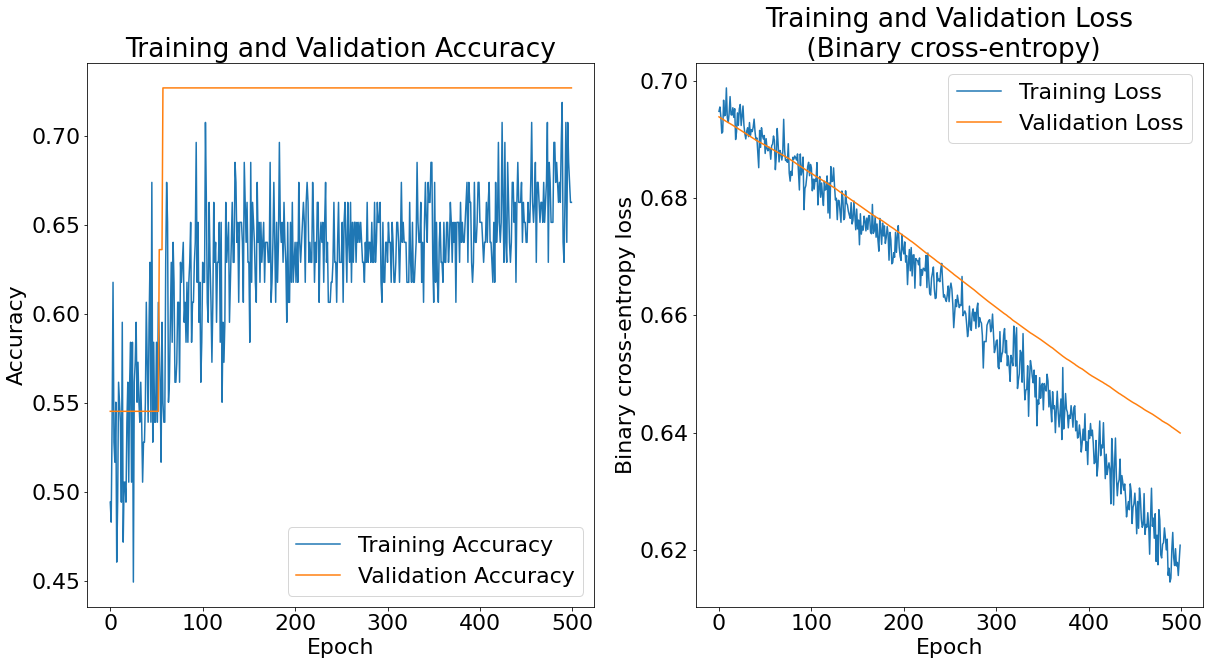

In [47]:
df_history = pd.DataFrame(history.history)
df_history['epoch'] = df_history.index+1
epochs_range = range(df_history['epoch'].max())

acc = df_history['Accuracy'].to_numpy()
val_acc = df_history['val_Accuracy'].to_numpy()
loss=df_history['loss'].to_numpy()
val_loss=df_history['val_loss'].to_numpy()

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss\n (Binary cross-entropy)')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy loss')
plt.savefig('AZ project/DeepCIM/Results/model/DeepCIM_chem_fp', dpi = 150)

print('Training binary crossentropy:', np.round(loss[-1],3), 'Validation binary crossentropy:', np.round(val_loss[-1], 3))

In [48]:
pred_val_labels = model.predict(x = [val_smiles_fp])
pred_test_labels = model.predict(x = [test_smiles_fp])
model.evaluate(x = [test_smiles_fp], y = test_labels)

# from one-hot encoding to labels

pred_val_labels = np.argmax(pred_val_labels, axis = 1)
pred_test_labels = np.argmax(pred_test_labels, axis = 1)
train_labels = np.argmax(train_labels, axis = 1)
val_labels = np.argmax(val_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

1/1 [==============================] - 0s 23ms/step - loss: 0.6458 - Accuracy: 0.6667


Accuracy = 0.6667
Precision = 1.0000
Recall = 0.2000
Specificity = 1.0000
False positive rate = 0.0000
F1-score = 0.3333
Confusion matrix (%):
[[58.33  0.  ]
 [33.33  8.33]]


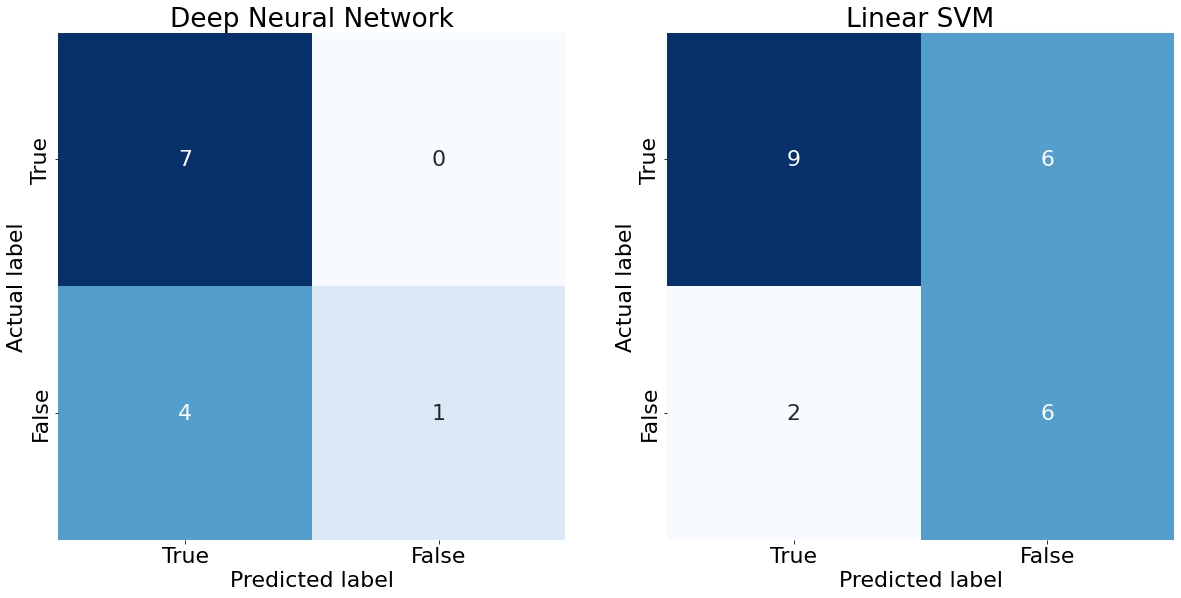

In [51]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))

test_mat = confusion_matrix(test_labels, pred_test_labels)
sns.heatmap(test_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['True', 'False'], yticklabels = ['True', 'False'], ax = plt.subplot(1,2,1))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Deep Neural Network')

sns.heatmap(camt_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['True', 'False'], yticklabels = ['True', 'False'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Linear SVM')

printPerformance(test_mat)

In [50]:
X_train = train_smiles_fp
X_test = np.concatenate([val_smiles_fp, test_smiles_fp])
Y_train = train_labels
Y_test = np.concatenate([val_labels, test_labels])
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

randomSeed = 500
nIter = 30


## SVM
svm = SVC(kernel='linear', C=1, random_state = randomSeed)
svm.fit(X_train, Y_train)
Y_test_hat_svm = svm.predict(X_test)
camt_svm = confusion_matrix(Y_test, Y_test_hat_svm)


df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])

df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(test_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(camt_svm))
#df_summary.loc[len(df_summary)] = ['Chemical space only'] + [0.462, 0.4, 0.333, 0.571, 0.429, 0.364]
#df_summary.loc[len(df_summary)] = ['Biological space only'] + [0.643, 0.548, 0.607, 0.667, 0.333, 0.576]
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

(89, 2048) (89,)
(23, 2048) (23,)


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
0,DeepCIM,0.667,1.0,0.20,1.0,0.0,0.333
1,SVM,0.652,0.5,0.75,0.6,0.4,0.600


In [ ]:
## Morgan fingerprint
train_smiles_fp, _= compute_ecfp_descriptors(train_smiles)
val_smiles_fp, _ = compute_ecfp_descriptors(val_smiles)
test_smiles_fp, _ = compute_ecfp_descriptors(test_smiles)

In [70]:
discovery_smiles = df_davis_myelo['Canonical SMILES'].to_numpy()
len(np.unique(discovery_smiles))

24

In [53]:
print(df_common.shape, df_unique.shape)

(14, 21) (10, 21)


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 776.27it/s]

1/1 [==============================] - 0s 17ms/step


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
0,DeepCIM,0.792,1.000,0.167,1.000,0.000,0.286
1,SVM,0.792,0.556,0.833,0.778,0.222,0.667


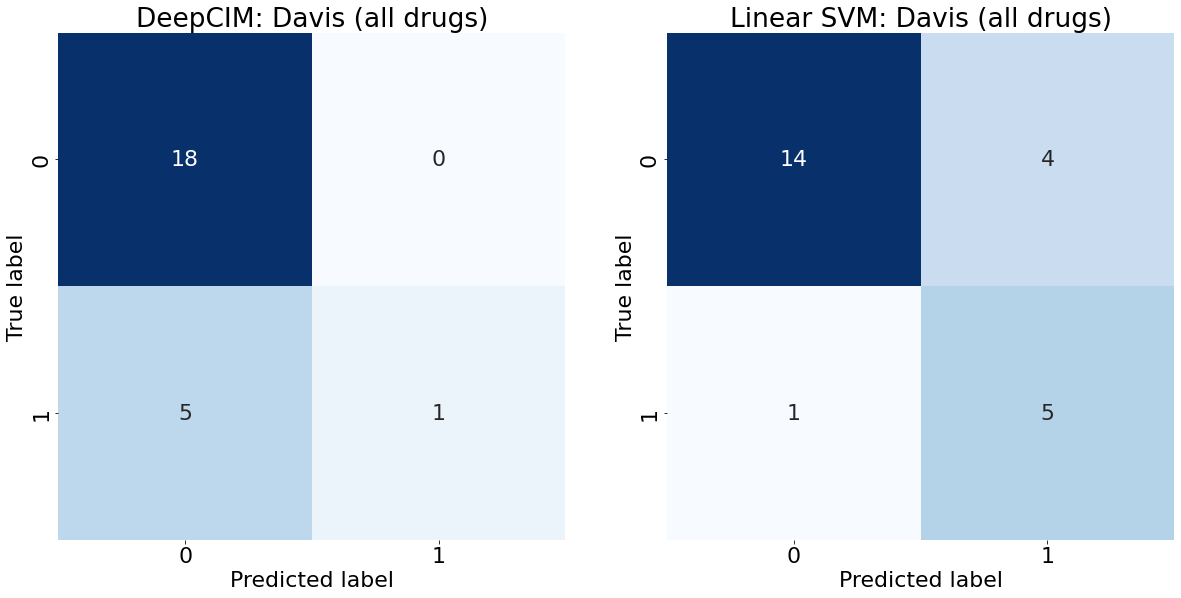

In [52]:
discovery_smiles_fp, _ = compute_ecfp_descriptors(df_name_davis['Canonical SMILES'].to_numpy())
discovery_labels = to_categorical(df_name_davis['label'])
discovery_labels_processed = np.argmax(discovery_labels, axis = 1)

pred_discovery_labels = model.predict([discovery_smiles_fp])
pred_discovery_labels_processed = np.argmax(pred_discovery_labels, axis = 1)

Y_test_hat_svm = svm.predict(discovery_smiles_fp)

plt.figure(figsize=(20, 20))
discovery_mat = confusion_matrix(discovery_labels_processed, pred_discovery_labels_processed)
sns.heatmap(discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM: Davis (all drugs)')

discovery_mat_svm = confusion_matrix(discovery_labels_processed, Y_test_hat_svm)
sns.heatmap(discovery_mat_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVM: Davis (all drugs)')

#plt.savefig('AZ project/DeepCIM/Results/Davis/chemical_only_davis_eval.jpg', dpi = 150)

df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])
df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(discovery_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(discovery_mat_svm))
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

### Tokenised SMILES

In [55]:
tf.keras.backend.clear_session()

smile_input = Input(shape = (170,), name = 'SMILES')
#protein_input = Input(shape = (2600,), name = 'Proteins')
#pIC50_input = Input(shape = (1,), name = 'pIC50')

fw = Dense(1024, activation = 'relu')(smile_input)
fw = Dropout(0.1)(fw)
fw = Dense(512, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(256, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(128, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(32, activation = 'relu')(fw)
out_layer = Dense(2, activation = 'sigmoid')(fw)

model = Model(inputs = [smile_input], outputs = out_layer)
opt = optimizers.Adam(learning_rate = 0.000001)
model.compile(loss = 'BinaryCrossentropy', optimizer = opt, metrics = ['Accuracy'])
 
###############################################################################################
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                          patience = 100, verbose = 1,
                          #restore_best_weights = True
                          ) 
#checkpoint = ModelCheckpoint('AZ project/DeepCIM/82mse_500adam0005b256_bestval.h5',
#                            monitor = 'val_loss', mode = 'min',
#                            save_best_only = True, verbose = 1
#                            )

In [56]:
train_smiles_padded.shape

(89, 170)

In [57]:
history = model.fit(
    x = [train_smiles_padded],
    y = train_labels,
    epochs = 500, batch_size = 32,
    validation_data = ([val_smiles_padded], val_labels),
    callbacks = [early_stop]#, checkpoint]
)

Epoch 1/500
3/3 [==============================] - 1s 72ms/step - loss: 0.8945 - Accuracy: 0.4157 - val_loss: 0.8901 - val_Accuracy: 0.2727
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8347 - Accuracy: 0.4270 - val_loss: 0.8869 - val_Accuracy: 0.2727
Epoch 3/500
3/3 [==============================] - 0s 26ms/step - loss: 0.9065 - Accuracy: 0.3933 - val_loss: 0.8836 - val_Accuracy: 0.2727
Epoch 4/500
3/3 [==============================] - 0s 21ms/step - loss: 0.9458 - Accuracy: 0.4157 - val_loss: 0.8804 - val_Accuracy: 0.2727
Epoch 5/500
3/3 [==============================] - 0s 21ms/step - loss: 0.8943 - Accuracy: 0.3933 - val_loss: 0.8775 - val_Accuracy: 0.2727
Epoch 6/500
3/3 [==============================] - 0s 22ms/step - loss: 0.8552 - Accuracy: 0.3820 - val_loss: 0.8743 - val_Accuracy: 0.2727
Epoch 7/500
3/3 [==============================] - 0s 20ms/step - loss: 0.8744 - Accuracy: 0.4157 - val_loss: 0.8713 - val_Accuracy: 0.2727
Epoch 8/500
3/3 [===

3/3 [==============================] - 0s 21ms/step - loss: 0.7113 - Accuracy: 0.5056 - val_loss: 0.6903 - val_Accuracy: 0.6364
Epoch 118/500
3/3 [==============================] - 0s 22ms/step - loss: 0.7170 - Accuracy: 0.4944 - val_loss: 0.6893 - val_Accuracy: 0.6364
Epoch 119/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6927 - Accuracy: 0.5618 - val_loss: 0.6884 - val_Accuracy: 0.6364
Epoch 120/500
3/3 [==============================] - 0s 28ms/step - loss: 0.7026 - Accuracy: 0.5618 - val_loss: 0.6875 - val_Accuracy: 0.6364
Epoch 121/500
3/3 [==============================] - 0s 25ms/step - loss: 0.7035 - Accuracy: 0.5056 - val_loss: 0.6867 - val_Accuracy: 0.6364
Epoch 122/500
3/3 [==============================] - 0s 22ms/step - loss: 0.7207 - Accuracy: 0.5281 - val_loss: 0.6859 - val_Accuracy: 0.6364
Epoch 123/500
3/3 [==============================] - 0s 22ms/step - loss: 0.7449 - Accuracy: 0.4607 - val_loss: 0.6850 - val_Accuracy: 0.6364
Epoch 124/500
3/3 [=

Epoch 175/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6800 - Accuracy: 0.5393 - val_loss: 0.6566 - val_Accuracy: 0.7273
Epoch 176/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6540 - Accuracy: 0.6292 - val_loss: 0.6562 - val_Accuracy: 0.7273
Epoch 177/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6989 - Accuracy: 0.5506 - val_loss: 0.6557 - val_Accuracy: 0.7273
Epoch 178/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6754 - Accuracy: 0.5843 - val_loss: 0.6553 - val_Accuracy: 0.7273
Epoch 179/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6935 - Accuracy: 0.4944 - val_loss: 0.6548 - val_Accuracy: 0.7273
Epoch 180/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7206 - Accuracy: 0.5056 - val_loss: 0.6543 - val_Accuracy: 0.7273
Epoch 181/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6966 - Accuracy: 0.5618 - val_loss: 0.6539 - val_Accuracy: 0.7273
Epoch 

Epoch 233/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6450 - Accuracy: 0.6404 - val_loss: 0.6366 - val_Accuracy: 0.7273
Epoch 234/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6661 - Accuracy: 0.6404 - val_loss: 0.6364 - val_Accuracy: 0.7273
Epoch 235/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6594 - Accuracy: 0.5730 - val_loss: 0.6360 - val_Accuracy: 0.7273
Epoch 236/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6553 - Accuracy: 0.5618 - val_loss: 0.6357 - val_Accuracy: 0.7273
Epoch 237/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6657 - Accuracy: 0.5843 - val_loss: 0.6353 - val_Accuracy: 0.7273
Epoch 238/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6871 - Accuracy: 0.5955 - val_loss: 0.6351 - val_Accuracy: 0.7273
Epoch 239/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6416 - Accuracy: 0.6629 - val_loss: 0.6348 - val_Accuracy: 0.7273
Epoch 

Epoch 291/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6325 - Accuracy: 0.6629 - val_loss: 0.6223 - val_Accuracy: 0.7273
Epoch 292/500
3/3 [==============================] - 0s 20ms/step - loss: 0.6372 - Accuracy: 0.6629 - val_loss: 0.6221 - val_Accuracy: 0.7273
Epoch 293/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6316 - Accuracy: 0.6180 - val_loss: 0.6219 - val_Accuracy: 0.7273
Epoch 294/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6717 - Accuracy: 0.6292 - val_loss: 0.6216 - val_Accuracy: 0.7273
Epoch 295/500
3/3 [==============================] - 0s 20ms/step - loss: 0.6433 - Accuracy: 0.6517 - val_loss: 0.6215 - val_Accuracy: 0.7273
Epoch 296/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6222 - Accuracy: 0.7191 - val_loss: 0.6213 - val_Accuracy: 0.7273
Epoch 297/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6460 - Accuracy: 0.6629 - val_loss: 0.6211 - val_Accuracy: 0.7273
Epoch 

Epoch 349/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6692 - Accuracy: 0.5843 - val_loss: 0.6127 - val_Accuracy: 0.7273
Epoch 350/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6266 - Accuracy: 0.5955 - val_loss: 0.6126 - val_Accuracy: 0.7273
Epoch 351/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6200 - Accuracy: 0.6180 - val_loss: 0.6124 - val_Accuracy: 0.7273
Epoch 352/500
3/3 [==============================] - 0s 20ms/step - loss: 0.6172 - Accuracy: 0.7303 - val_loss: 0.6123 - val_Accuracy: 0.7273
Epoch 353/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6305 - Accuracy: 0.6292 - val_loss: 0.6120 - val_Accuracy: 0.7273
Epoch 354/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6259 - Accuracy: 0.6629 - val_loss: 0.6119 - val_Accuracy: 0.7273
Epoch 355/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6213 - Accuracy: 0.6854 - val_loss: 0.6118 - val_Accuracy: 0.7273
Epoch 

Epoch 407/500
3/3 [==============================] - 0s 21ms/step - loss: 0.5929 - Accuracy: 0.7191 - val_loss: 0.6055 - val_Accuracy: 0.7273
Epoch 408/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6394 - Accuracy: 0.6180 - val_loss: 0.6052 - val_Accuracy: 0.7273
Epoch 409/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6055 - Accuracy: 0.6854 - val_loss: 0.6051 - val_Accuracy: 0.7273
Epoch 410/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6254 - Accuracy: 0.6629 - val_loss: 0.6050 - val_Accuracy: 0.7273
Epoch 411/500
3/3 [==============================] - 0s 21ms/step - loss: 0.6179 - Accuracy: 0.6742 - val_loss: 0.6048 - val_Accuracy: 0.7273
Epoch 412/500
3/3 [==============================] - 0s 25ms/step - loss: 0.6451 - Accuracy: 0.6180 - val_loss: 0.6047 - val_Accuracy: 0.7273
Epoch 413/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6216 - Accuracy: 0.6742 - val_loss: 0.6046 - val_Accuracy: 0.7273
Epoch 

Epoch 465/500
3/3 [==============================] - 0s 22ms/step - loss: 0.6085 - Accuracy: 0.7079 - val_loss: 0.5990 - val_Accuracy: 0.7273
Epoch 466/500
3/3 [==============================] - 0s 28ms/step - loss: 0.5824 - Accuracy: 0.7640 - val_loss: 0.5989 - val_Accuracy: 0.7273
Epoch 467/500
3/3 [==============================] - 0s 20ms/step - loss: 0.6049 - Accuracy: 0.6629 - val_loss: 0.5987 - val_Accuracy: 0.7273
Epoch 468/500
3/3 [==============================] - 0s 27ms/step - loss: 0.5882 - Accuracy: 0.7079 - val_loss: 0.5987 - val_Accuracy: 0.7273
Epoch 469/500
3/3 [==============================] - 0s 23ms/step - loss: 0.5818 - Accuracy: 0.7303 - val_loss: 0.5985 - val_Accuracy: 0.7273
Epoch 470/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6159 - Accuracy: 0.6854 - val_loss: 0.5985 - val_Accuracy: 0.7273
Epoch 471/500
3/3 [==============================] - 0s 24ms/step - loss: 0.5773 - Accuracy: 0.6854 - val_loss: 0.5984 - val_Accuracy: 0.7273
Epoch 

Training binary crossentropy: 0.572 Validation binary crossentropy: 0.596


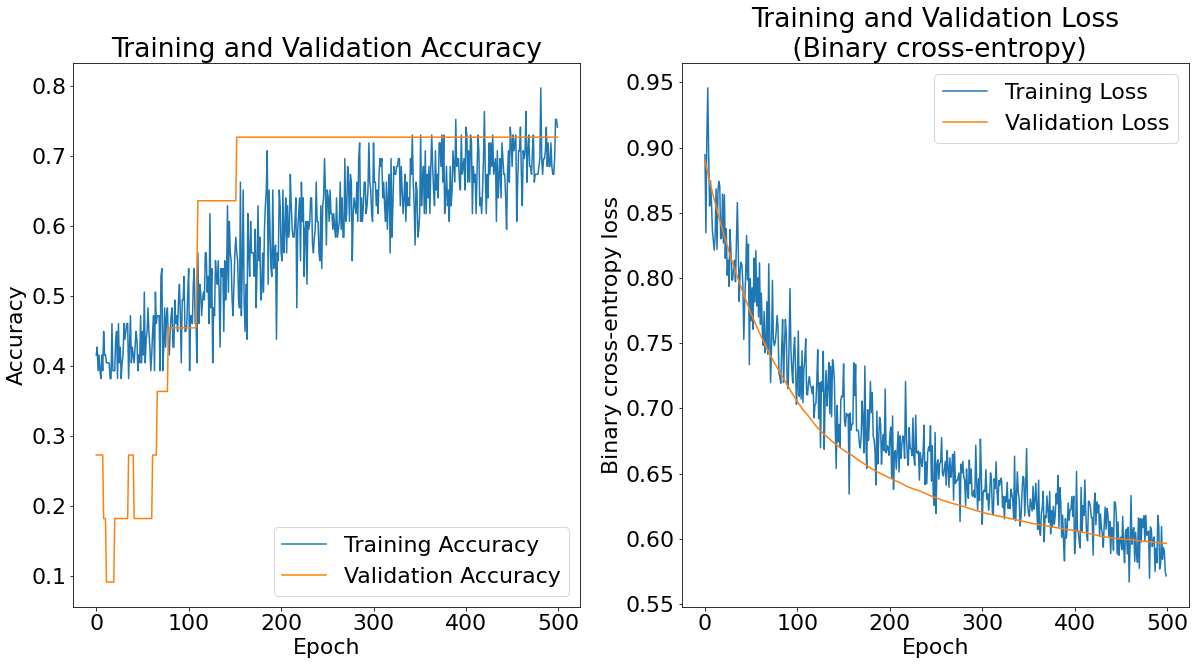

In [58]:
df_history = pd.DataFrame(history.history)
df_history['epoch'] = df_history.index+1
epochs_range = range(df_history['epoch'].max())

acc = df_history['Accuracy'].to_numpy()
val_acc = df_history['val_Accuracy'].to_numpy()
loss=df_history['loss'].to_numpy()
val_loss=df_history['val_loss'].to_numpy()

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss\n (Binary cross-entropy)')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy loss')
plt.savefig('AZ project/DeepCIM/Results/model/DeepCIM_chem_tok')

print('Training binary crossentropy:', np.round(loss[-1],3), 'Validation binary crossentropy:', np.round(val_loss[-1], 3))

In [59]:
pred_val_labels = model.predict(x = [val_smiles_padded])
pred_test_labels = model.predict(x = [test_smiles_padded])
model.evaluate(x = [test_smiles_padded], y = test_labels)

# from one-hot encoding to labels

pred_val_labels = np.argmax(pred_val_labels, axis = 1)
pred_test_labels = np.argmax(pred_test_labels, axis = 1)
train_labels = np.argmax(train_labels, axis = 1)
val_labels = np.argmax(val_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

1/1 [==============================] - 0s 20ms/step - loss: 0.7039 - Accuracy: 0.6667


Accuracy = 0.6667
Precision = 1.0000
Recall = 0.2000
Specificity = 1.0000
False positive rate = 0.0000
F1-score = 0.3333
Confusion matrix (%):
[[58.33  0.  ]
 [33.33  8.33]]


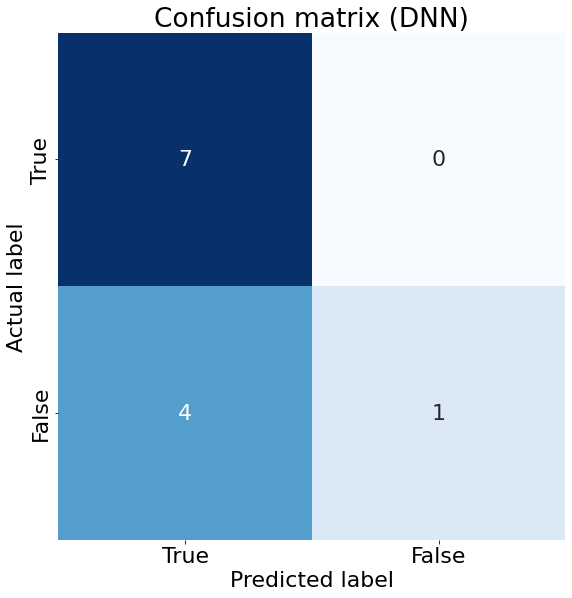

In [60]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))

test_mat = confusion_matrix(test_labels, pred_test_labels)
sns.heatmap(test_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['True', 'False'], yticklabels = ['True', 'False'], ax = plt.subplot(1,2,1))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix (DNN)')

printPerformance(test_mat)

In [61]:
X_train = train_smiles_padded
X_test = np.concatenate([val_smiles_padded, test_smiles_padded])
Y_train = train_labels
Y_test = np.concatenate([val_labels, test_labels])
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

randomSeed = 500
nIter = 30


## SVM
svm = SVC(kernel='linear', C=1, random_state = randomSeed)
svm.fit(X_train, Y_train)
Y_test_hat_svm = svm.predict(X_test)
camt_svm = confusion_matrix(Y_test, Y_test_hat_svm)


df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])

df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(test_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(camt_svm))
#df_summary.loc[len(df_summary)] = ['Chemical space only'] + [0.462, 0.4, 0.333, 0.571, 0.429, 0.364]
#df_summary.loc[len(df_summary)] = ['Biological space only'] + [0.643, 0.548, 0.607, 0.667, 0.333, 0.576]
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

(89, 170) (89,)
(23, 170) (23,)


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
1,SVM,0.739,0.6,0.75,0.733,0.267,0.667
0,DeepCIM,0.667,1.0,0.20,1.000,0.000,0.333


Accuracy = 0.6667
Precision = 1.0000
Recall = 0.2000
Specificity = 1.0000
False positive rate = 0.0000
F1-score = 0.3333
Confusion matrix (%):
[[58.33  0.  ]
 [33.33  8.33]]
Accuracy = 0.6667
Precision = 1.0000
Recall = 0.2000
Specificity = 1.0000
False positive rate = 0.0000
F1-score = 0.3333
Confusion matrix (%):
[[58.33  0.  ]
 [33.33  8.33]]


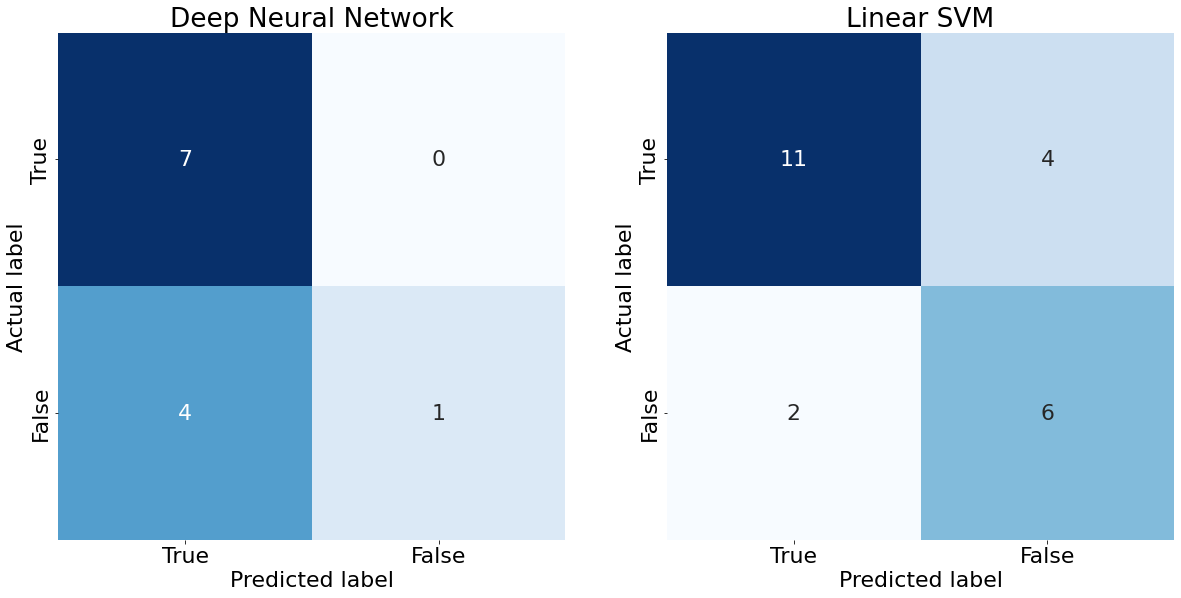

In [63]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))

test_mat = confusion_matrix(test_labels, pred_test_labels)
sns.heatmap(test_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['True', 'False'], yticklabels = ['True', 'False'], ax = plt.subplot(1,2,1))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Deep Neural Network')

printPerformance(test_mat)

sns.heatmap(camt_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['True', 'False'], yticklabels = ['True', 'False'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Linear SVM')

printPerformance(test_mat)

1/1 [==============================] - 0s 16ms/step


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
0,DeepCIM,0.750,NaN,0.0,1.000,0.000,NaN
1,SVM,0.708,0.462,1.0,0.611,0.389,0.632


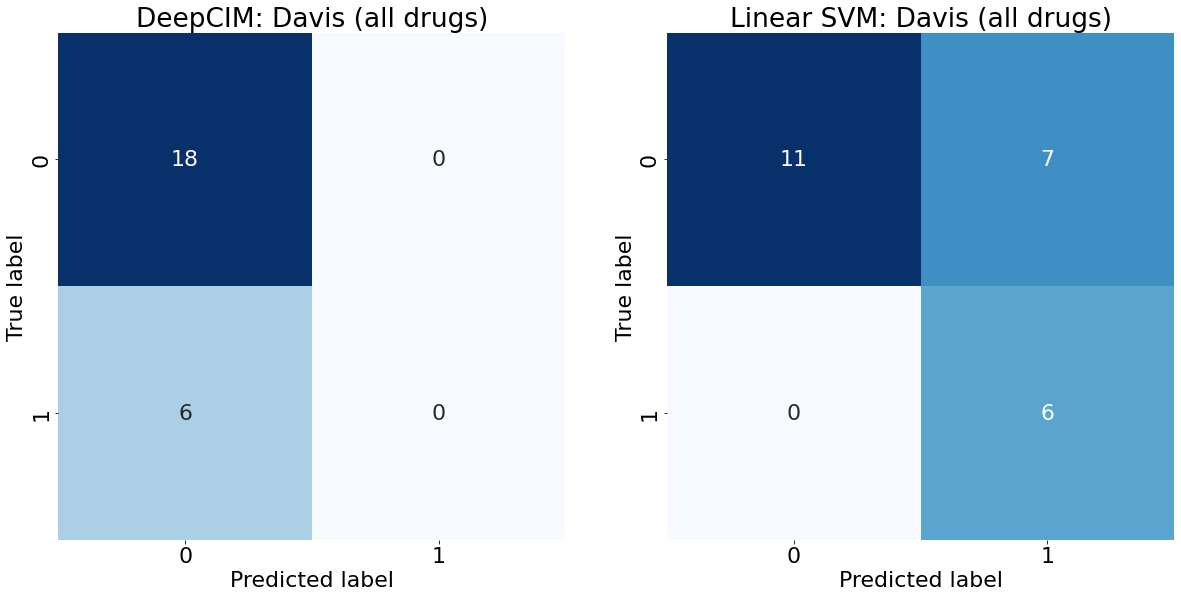

In [64]:
discovery_smiles = df_name_davis['Canonical SMILES'].to_numpy()
discovery_labels = to_categorical(df_name_davis['label'])
discovery_labels_processed = np.argmax(discovery_labels, axis = 1)

discovery_smiles_sequences = smiles_tokenizer.texts_to_sequences(discovery_smiles)
discovery_smiles_padded = pad_sequences(discovery_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

pred_discovery_labels = model.predict([discovery_smiles_padded])
pred_discovery_labels_processed = np.argmax(pred_discovery_labels, axis = 1)

Y_test_hat_svm = svm.predict(discovery_smiles_padded)

plt.figure(figsize=(20, 20))
discovery_mat = confusion_matrix(discovery_labels_processed, pred_discovery_labels_processed)
sns.heatmap(discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM: Davis (all drugs)')

discovery_mat_svm = confusion_matrix(discovery_labels_processed, Y_test_hat_svm)
sns.heatmap(discovery_mat_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVM: Davis (all drugs)')

#plt.savefig('AZ project/DeepCIM/Results/Davis/chemical_only_davis_eval.jpg', dpi = 150)

df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])
df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(discovery_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(discovery_mat_svm))
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

# Biological information

In [88]:
smiles = df_myelo['Canonical SMILES'].to_numpy()
proteins = df_myelo['BindingDB Target Chain Sequence'].to_numpy()
pIC50 = df_myelo['pIC50'].to_numpy()
labels = to_categorical(df_myelo['label'])
print('number of unique target sequence:',len(np.unique(proteins)))
print('number of unique smiles (molecules):',len(np.unique(smiles)))

# Train test val split using scikit learn

train_smiles, eval_smiles, train_proteins, eval_proteins, train_pIC50, eval_pIC50, train_labels, eval_labels = \
train_test_split(smiles, proteins, pIC50, labels, test_size = 0.2, random_state = 1279)

val_smiles, test_smiles, val_proteins, test_proteins, val_pIC50, test_pIC50, val_labels, test_labels = \
train_test_split(eval_smiles, eval_proteins, eval_pIC50, eval_labels, test_size = 0.5, random_state = 929)

print(np.unique(np.argmax(train_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(val_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(test_labels, axis = 1), return_counts = True))

train_proteins_sequences = proteins_tokenizer.texts_to_sequences(train_proteins)
train_proteins_padded = pad_sequences(train_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
val_proteins_sequences = proteins_tokenizer.texts_to_sequences(val_proteins)
val_proteins_padded = pad_sequences(val_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
test_proteins_sequences = proteins_tokenizer.texts_to_sequences(test_proteins)
test_proteins_padded = pad_sequences(test_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

number of unique target sequence: 302
number of unique smiles (molecules): 112
(array([0, 1], dtype=int64), array([344, 368], dtype=int64))
(array([0, 1], dtype=int64), array([46, 43], dtype=int64))
(array([0, 1], dtype=int64), array([41, 48], dtype=int64))


In [89]:
tf.keras.backend.clear_session()

#smile_input = Input(shape = (170,), name = 'SMILES')
protein_input = Input(shape = (2600,), name = 'Proteins')
pIC50_input = Input(shape = (1,), name = 'pIC50')


li_protein = Dense(1024)(protein_input)
li_protein = Dense(512, activation = 'relu')(li_protein)
li_protein = Dense(256, activation = 'relu')(li_protein)
li_protein = Dense(128, activation = 'relu')(li_protein)

li_pIC50 = Dense(1024)(pIC50_input)
li_pIC50 = Dense(512, activation = 'relu')(li_pIC50)
li_pIC50 = Dense(256, activation = 'relu')(li_pIC50)
li_pIC50 = Dense(128, activation = 'relu')(li_pIC50)

concat_layer = Concatenate()([li_protein, li_pIC50])

fw = Dense(1024, activation = 'relu')(concat_layer)
fw = Dropout(0.1)(fw)
fw = Dense(512, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(256, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(128, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(32, activation = 'relu')(fw)
out_layer = Dense(2, activation = 'sigmoid')(fw)

model = Model(inputs = [protein_input,pIC50_input], outputs = out_layer)
opt = optimizers.Adam(learning_rate = 0.000001)
model.compile(loss = 'BinaryCrossentropy', optimizer = opt, metrics = ['Accuracy'])


###############################################################################################
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                          patience = 100, verbose = 1,
                          #restore_best_weights = True
                          ) 
#checkpoint = ModelCheckpoint('AZ project/DeepCIM/82mse_500adam0005b256_bestval.h5',
#                            monitor = 'val_loss', mode = 'min',
#                            save_best_only = True, verbose = 1
#                            )

history = model.fit(
    x = [train_proteins_padded, train_pIC50],
    y = train_labels,
    epochs = 500, batch_size = 32,
    validation_data = ([val_proteins_padded, val_pIC50], val_labels),
    callbacks = [early_stop]#, checkpoint]
)

Epoch 1/500
23/23 [==============================] - 1s 26ms/step - loss: 0.7597 - Accuracy: 0.5140 - val_loss: 0.7343 - val_Accuracy: 0.4831
Epoch 2/500
23/23 [==============================] - 0s 17ms/step - loss: 0.7415 - Accuracy: 0.5197 - val_loss: 0.7251 - val_Accuracy: 0.4831
Epoch 3/500
23/23 [==============================] - 0s 11ms/step - loss: 0.7225 - Accuracy: 0.5323 - val_loss: 0.7184 - val_Accuracy: 0.4831
Epoch 4/500
23/23 [==============================] - 0s 10ms/step - loss: 0.7225 - Accuracy: 0.5253 - val_loss: 0.7131 - val_Accuracy: 0.5056
Epoch 5/500
23/23 [==============================] - 0s 13ms/step - loss: 0.7292 - Accuracy: 0.5070 - val_loss: 0.7096 - val_Accuracy: 0.5056
Epoch 6/500
23/23 [==============================] - 0s 11ms/step - loss: 0.7116 - Accuracy: 0.5253 - val_loss: 0.7064 - val_Accuracy: 0.5056
Epoch 7/500
23/23 [==============================] - 0s 10ms/step - loss: 0.7202 - Accuracy: 0.5070 - val_loss: 0.7041 - val_Accuracy: 0.5169
Epoch 

23/23 [==============================] - 0s 9ms/step - loss: 0.6544 - Accuracy: 0.6166 - val_loss: 0.6866 - val_Accuracy: 0.6404
Epoch 116/500
23/23 [==============================] - 0s 10ms/step - loss: 0.6551 - Accuracy: 0.6081 - val_loss: 0.6864 - val_Accuracy: 0.6292
Epoch 117/500
23/23 [==============================] - 0s 9ms/step - loss: 0.6545 - Accuracy: 0.6138 - val_loss: 0.6859 - val_Accuracy: 0.6292
Epoch 118/500
23/23 [==============================] - 0s 9ms/step - loss: 0.6548 - Accuracy: 0.6194 - val_loss: 0.6859 - val_Accuracy: 0.6292
Epoch 119/500
23/23 [==============================] - 0s 10ms/step - loss: 0.6475 - Accuracy: 0.6320 - val_loss: 0.6862 - val_Accuracy: 0.6180
Epoch 120/500
23/23 [==============================] - 0s 10ms/step - loss: 0.6520 - Accuracy: 0.6067 - val_loss: 0.6862 - val_Accuracy: 0.6292
Epoch 121/500
23/23 [==============================] - 0s 9ms/step - loss: 0.6547 - Accuracy: 0.6194 - val_loss: 0.6866 - val_Accuracy: 0.6404
Epoch 122/

23/23 [==============================] - 0s 10ms/step - loss: 0.5855 - Accuracy: 0.6966 - val_loss: 0.6898 - val_Accuracy: 0.6404
Epoch 230/500
23/23 [==============================] - 0s 10ms/step - loss: 0.5824 - Accuracy: 0.7022 - val_loss: 0.6904 - val_Accuracy: 0.6292
Epoch 231/500
23/23 [==============================] - 0s 10ms/step - loss: 0.5854 - Accuracy: 0.6826 - val_loss: 0.6911 - val_Accuracy: 0.6292
Epoch 232/500
23/23 [==============================] - 0s 12ms/step - loss: 0.5920 - Accuracy: 0.6699 - val_loss: 0.6912 - val_Accuracy: 0.6404
Epoch 233/500
23/23 [==============================] - 0s 16ms/step - loss: 0.5747 - Accuracy: 0.7149 - val_loss: 0.6913 - val_Accuracy: 0.6404
Epoch 234/500
23/23 [==============================] - 0s 8ms/step - loss: 0.5814 - Accuracy: 0.6994 - val_loss: 0.6921 - val_Accuracy: 0.6404
Epoch 235/500
23/23 [==============================] - 0s 7ms/step - loss: 0.5840 - Accuracy: 0.6784 - val_loss: 0.6926 - val_Accuracy: 0.6404
Epoch 23

Training binary crossentropy: 0.579 Validation binary crossentropy: 0.695


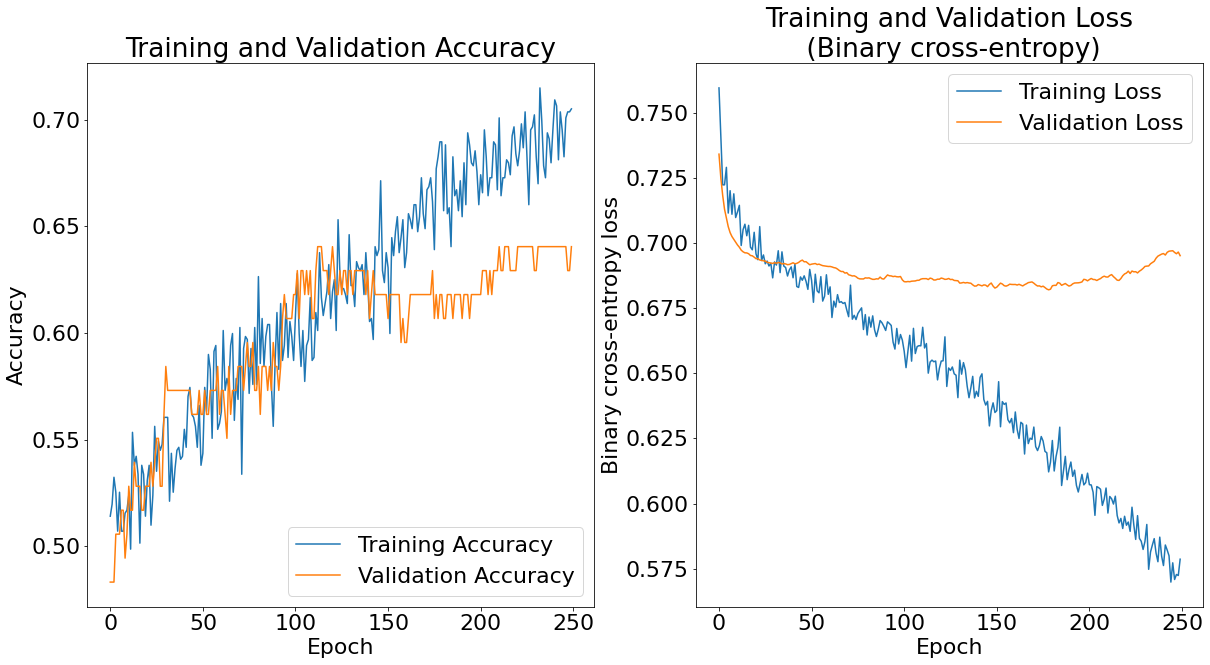

In [90]:
df_history = pd.DataFrame(history.history)
df_history['epoch'] = df_history.index+1
epochs_range = range(df_history['epoch'].max())

acc = df_history['Accuracy'].to_numpy()
val_acc = df_history['val_Accuracy'].to_numpy()
loss=df_history['loss'].to_numpy()
val_loss=df_history['val_loss'].to_numpy()

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss\n (Binary cross-entropy)')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy loss')
plt.savefig('AZ project/DeepCIM/Results/model/DeepCIM_bio2')

print('Training binary crossentropy:', np.round(loss[-1],3), 'Validation binary crossentropy:', np.round(val_loss[-1], 3))

In [91]:
pred_val_labels = model.predict(x = [val_proteins_padded, val_pIC50])
pred_test_labels = model.predict(x = [test_proteins_padded, test_pIC50])
model.evaluate(x = [test_proteins_padded, test_pIC50], y = test_labels)

# from one-hot encoding to labels

pred_val_labels = np.argmax(pred_val_labels, axis = 1)
pred_test_labels = np.argmax(pred_test_labels, axis = 1)
train_labels = np.argmax(train_labels, axis = 1)
val_labels = np.argmax(val_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

3/3 [==============================] - 0s 4ms/step - loss: 0.7008 - Accuracy: 0.6180


Accuracy = 0.6180
Precision = 0.7188
Recall = 0.4792
Specificity = 0.7805
False positive rate = 0.2195
F1-score = 0.5750
Confusion matrix (%):
[[35.96 10.11]
 [28.09 25.84]]


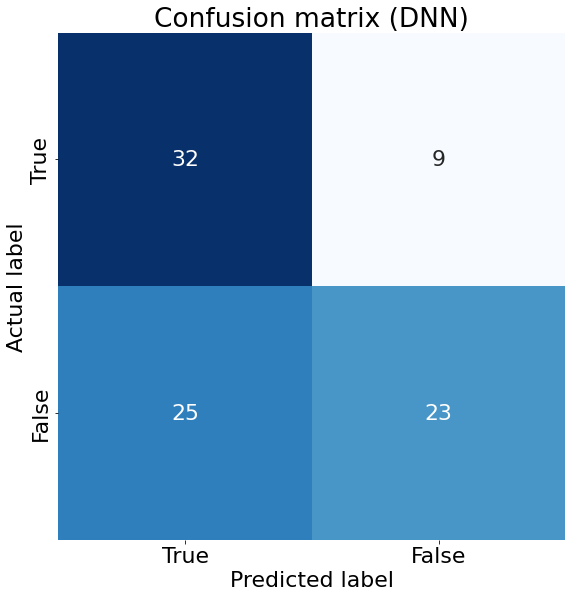

In [92]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))

test_mat = confusion_matrix(test_labels, pred_test_labels)
sns.heatmap(test_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['True', 'False'], yticklabels = ['True', 'False'], ax = plt.subplot(1,2,1))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix (DNN)')

printPerformance(test_mat)

In [93]:
X_train = np.concatenate([train_proteins_padded, train_pIC50.reshape(-1,1)], axis = 1)
X_test = np.concatenate([test_proteins_padded, test_pIC50.reshape(-1,1)], axis = 1)
X_val = np.concatenate([val_proteins_padded, val_pIC50.reshape(-1,1)], axis = 1)
X_test = np.concatenate([X_val, X_test], axis = 0)

Y_train = train_labels
Y_test = np.concatenate([val_labels, test_labels])
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

randomSeed = 500
nIter = 30


## SVM
svm = SVC(kernel='linear', C=1, random_state = randomSeed)
svm.fit(X_train, Y_train)
Y_test_hat_svm = svm.predict(X_test)
camt_svm = confusion_matrix(Y_test, Y_test_hat_svm)


df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])

df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(test_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(camt_svm))
#df_summary.loc[len(df_summary)] = ['Chemical space only'] + [0.462, 0.4, 0.333, 0.571, 0.429, 0.364]
#df_summary.loc[len(df_summary)] = ['Biological space only'] + [0.643, 0.548, 0.607, 0.667, 0.333, 0.576]
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

(712, 2601) (712,)
(178, 2601) (178,)


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
1,SVM,0.624,0.650,0.571,0.678,0.322,0.608
0,DeepCIM,0.618,0.719,0.479,0.780,0.220,0.575


number of unique target sequence: 379
285/285 [==============================] - 1s 2ms/step


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
0,DeepCIM,0.508,0.25,0.484,0.516,0.484,0.330
1,SVM,0.471,0.25,0.558,0.442,0.558,0.345


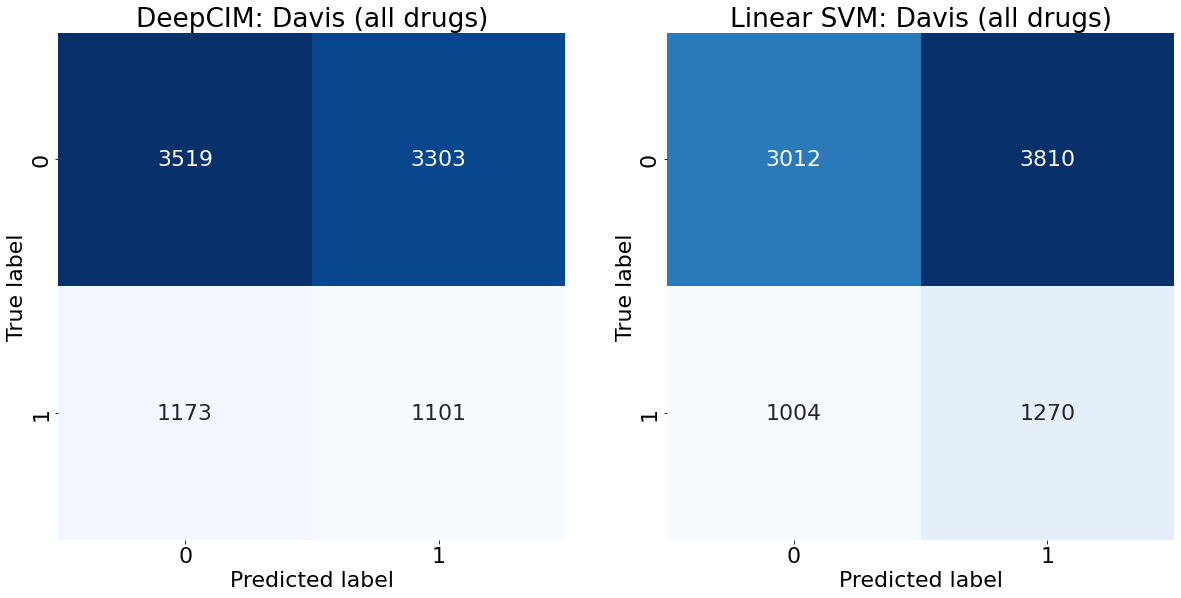

In [94]:
discovery_proteins = df_davis_myelo['Target'].to_numpy()
discovery_pIC50 = df_davis_myelo['pIC50'].to_numpy()
discovery_labels = to_categorical(df_davis_myelo['label']) # For calculating accuracy at the end of this code
discovery_labels_processed = np.argmax(discovery_labels, axis = 1)

print('number of unique target sequence:',len(np.unique(discovery_proteins)))

discovery_proteins_sequences = proteins_tokenizer.texts_to_sequences(discovery_proteins)
discovery_proteins_padded = pad_sequences(discovery_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

pred_discovery_labels = model.predict(x = [discovery_proteins_padded, discovery_pIC50])
pred_discovery_labels_processed = np.argmax(pred_discovery_labels, axis = 1)

Y_test_hat_svm = svm.predict(
    np.concatenate([discovery_proteins_padded, discovery_pIC50.reshape(-1,1)], axis = 1))


plt.figure(figsize=(20, 20))
discovery_mat = confusion_matrix(discovery_labels_processed, pred_discovery_labels_processed)
sns.heatmap(discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM: Davis (all drugs)')

discovery_mat_svm = confusion_matrix(discovery_labels_processed, Y_test_hat_svm)
sns.heatmap(discovery_mat_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVM: Davis (all drugs)')

df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])
df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(discovery_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(discovery_mat_svm))
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

# Train DeepCIM with BindingDB, validate by Davis

In [72]:
## Tokenise uising larger dataset

all_smiles = df_IC['Canonical SMILES'].unique()
all_proteins = df_IC['BindingDB Target Chain Sequence'].unique()
print(len(all_smiles), len(all_proteins))

# Tokenise SMILES and A.A. Target Sequences

smiles_tokenizer = Tokenizer(char_level = True)
smiles_tokenizer.fit_on_texts(all_smiles)
smiles_word_index = smiles_tokenizer.word_index
smiles_vocab_size = len(smiles_word_index)

proteins_tokenizer = Tokenizer(char_level = True)
proteins_tokenizer.fit_on_texts(all_proteins)
proteins_word_index = proteins_tokenizer.word_index
proteins_vocab_size = len(proteins_word_index)
print(smiles_vocab_size, proteins_vocab_size)

507154 1704
44 20


In [73]:
print(df_myelo['canonical_len'].max(), df_myelo['sequence_len'].max())
print(df_davis_myelo['canonical_len'].max(), df_davis_myelo['sequence_len'].max())

167 2549
70 2549


In [74]:
len(df_myelo['Uniprot Name'].unique())

288

In [107]:
from tensorflow.keras.utils import to_categorical

smiles = df_myelo['Canonical SMILES'].to_numpy()
proteins = df_myelo['BindingDB Target Chain Sequence'].to_numpy()
pIC50 = df_myelo['pIC50'].to_numpy()
labels = to_categorical(df_myelo['label'])
print('number of unique target sequence:',len(np.unique(proteins)))
print('number of unique smiles (molecules):',len(np.unique(smiles)))

# Train test val split using scikit learn

train_smiles, eval_smiles, train_proteins, eval_proteins, train_pIC50, eval_pIC50, train_labels, eval_labels = \
train_test_split(smiles, proteins, pIC50, labels, test_size = 0.2, random_state = 1279)


val_smiles, test_smiles, val_proteins, test_proteins, val_pIC50, test_pIC50, val_labels, test_labels = \
train_test_split(eval_smiles, eval_proteins, eval_pIC50, eval_labels, test_size = 0.5, random_state = 929)

print(np.unique(np.argmax(train_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(val_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(test_labels, axis = 1), return_counts = True))

# Train val test share some SMILES string as the model is trained on Drug-Target Interaction datapoints
# Not SMILES - Target pIC50 values (This will be carried out later at "PIVOT" section)
print('Train SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(train_smiles)].label, return_counts = True))
print('Val SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(val_smiles)].label, return_counts = True))
print('Test SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(test_smiles)].label, return_counts = True))

train_smiles_sequences = smiles_tokenizer.texts_to_sequences(train_smiles)
train_smiles_padded = pad_sequences(train_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
val_smiles_sequences = smiles_tokenizer.texts_to_sequences(val_smiles)
val_smiles_padded = pad_sequences(val_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
test_smiles_sequences = smiles_tokenizer.texts_to_sequences(test_smiles)
test_smiles_padded = pad_sequences(test_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

train_proteins_sequences = proteins_tokenizer.texts_to_sequences(train_proteins)
train_proteins_padded = pad_sequences(train_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
val_proteins_sequences = proteins_tokenizer.texts_to_sequences(val_proteins)
val_proteins_padded = pad_sequences(val_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
test_proteins_sequences = proteins_tokenizer.texts_to_sequences(test_proteins)
test_proteins_padded = pad_sequences(test_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

number of unique target sequence: 302
number of unique smiles (molecules): 112
(array([0, 1], dtype=int64), array([344, 368], dtype=int64))
(array([0, 1], dtype=int64), array([46, 43], dtype=int64))
(array([0, 1], dtype=int64), array([41, 48], dtype=int64))
Train SMILES: (array([0., 1.]), array([66, 44], dtype=int64))
Val SMILES: (array([0., 1.]), array([26, 20], dtype=int64))
Test SMILES: (array([0., 1.]), array([23, 22], dtype=int64))


In [241]:
#model.save("AZ project/DeepCIM/final.h5")
#df_history.to_csv('AZ project/DeepCIM/history_final.csv', index = 0)

In [225]:
#plot_model(model, show_shapes = True, to_file = 'AZ project/DeepCIM/Results/DeepCIM_archi.jpg')

In [108]:
model = tf.keras.models.load_model('AZ project/DeepCIM/final.h5')

Training binary crossentropy: 0.001 Validation binary crossentropy: 0.001


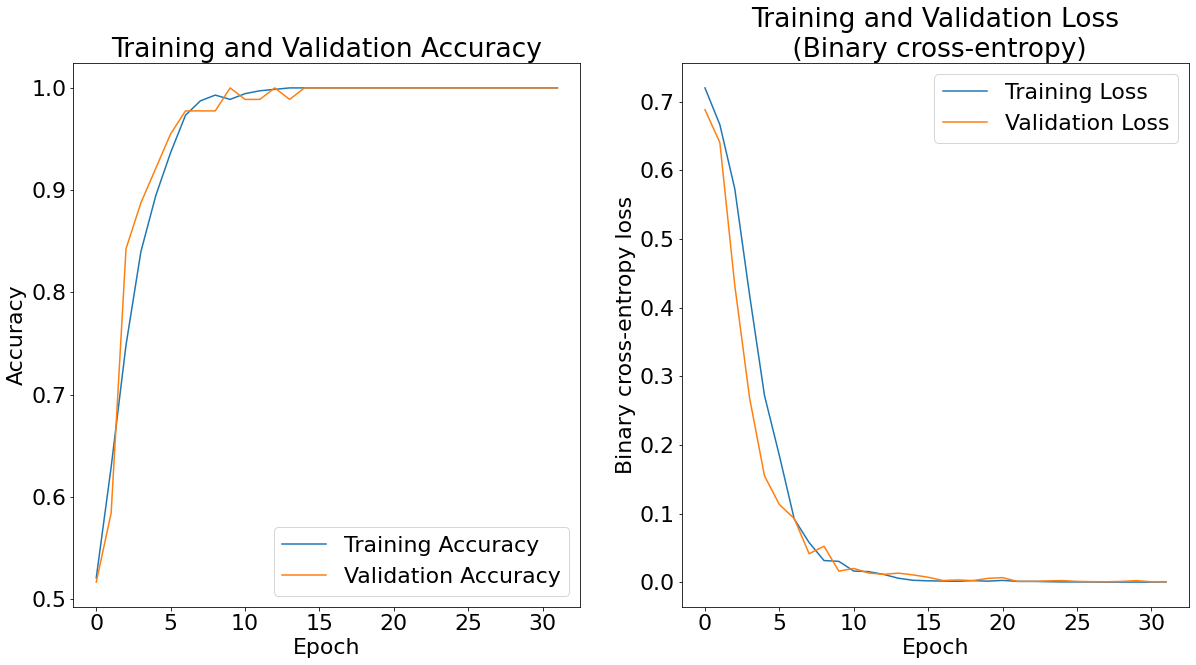

In [109]:
df_history = pd.read_csv('AZ project/DeepCIM/history_final.csv')
df_history['epoch'] = df_history.index+1
epochs_range = range(df_history['epoch'].max())

acc = df_history['Accuracy'].to_numpy()
val_acc = df_history['val_Accuracy'].to_numpy()
loss=df_history['loss'].to_numpy()
val_loss=df_history['val_loss'].to_numpy()

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss\n (Binary cross-entropy)')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy loss')
plt.savefig('AZ project/DeepCIM/Results/model/DeepCIM_main.jpg', dpi = 150)

print('Training binary crossentropy:', np.round(loss[-1],3), 'Validation binary crossentropy:', np.round(val_loss[-1], 3))

In [110]:
pred_val_labels = model.predict(x = [val_smiles_padded, val_proteins_padded, val_pIC50])
pred_test_labels = model.predict(x = [test_smiles_padded, test_proteins_padded, test_pIC50])
model.evaluate(x = [test_smiles_padded, test_proteins_padded, test_pIC50], y = test_labels)

# from one-hot encoding to labels

pred_val_labels = np.argmax(pred_val_labels, axis = 1)
pred_test_labels = np.argmax(pred_test_labels, axis = 1)
train_labels = np.argmax(train_labels, axis = 1)
val_labels = np.argmax(val_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

3/3 [==============================] - 0s 16ms/step - loss: 0.0020 - Accuracy: 1.0000


In [111]:
print(np.unique(np.argmax(eval_labels, axis = 1), return_counts = True))

(array([0, 1], dtype=int64), array([87, 91], dtype=int64))


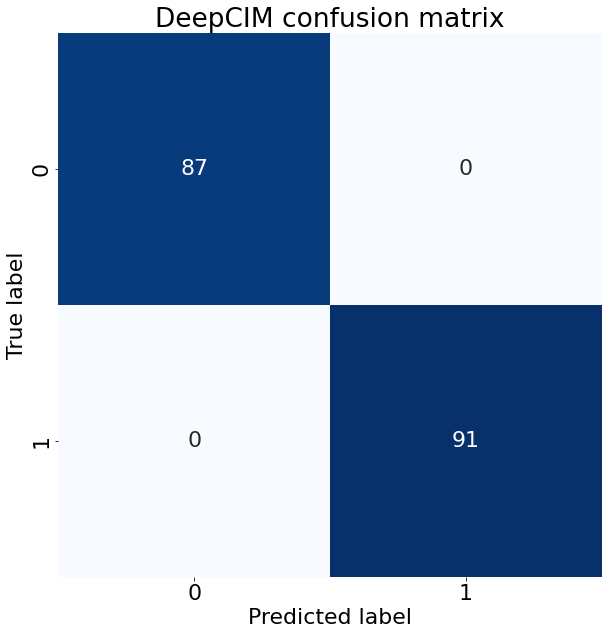

In [112]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))

test_mat = confusion_matrix(np.concatenate([val_labels, test_labels]), 
                            np.concatenate([pred_val_labels, pred_test_labels]))
sns.heatmap(test_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0','1'], yticklabels = ['0','1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM confusion matrix')
plt.savefig('AZ project/DeepCIM/Results/confusionmatrix.jpg', dpi = 150)

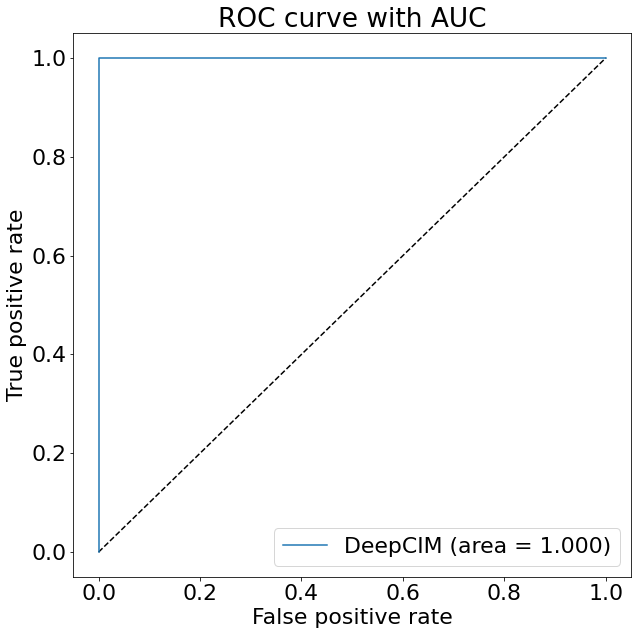

In [113]:
from sklearn.metrics import roc_curve, auc
plt.rcParams.update({'font.size': 22})
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(np.concatenate([val_labels, test_labels]), 
                                             np.concatenate([pred_val_labels, pred_test_labels]))
auc_dnn = auc(fpr_dnn, tpr_dnn)
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dnn, tpr_dnn, label='DeepCIM (area = {:.3f})'.format(auc_dnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with AUC')
plt.legend(loc='best')
plt.savefig('AZ project/DeepCIM/Results/AUCROC.jpg', dpi = 150)
plt.show()

In [115]:
from tensorflow.keras.utils import to_categorical

smiles = df_myelo['Canonical SMILES'].to_numpy()
proteins = df_myelo['BindingDB Target Chain Sequence'].to_numpy()
pIC50 = df_myelo['pIC50'].to_numpy()
labels = to_categorical(df_myelo['label'])
print('number of unique target sequence:',len(np.unique(proteins)))
print('number of unique smiles (molecules):',len(np.unique(smiles)))

# Train test val split using scikit learn

train_smiles, eval_smiles, train_proteins, eval_proteins, train_pIC50, eval_pIC50, train_labels, eval_labels = \
train_test_split(smiles, proteins, pIC50, labels, test_size = 0.2, random_state = 1280)


val_smiles, test_smiles, val_proteins, test_proteins, val_pIC50, test_pIC50, val_labels, test_labels = \
train_test_split(eval_smiles, eval_proteins, eval_pIC50, eval_labels, test_size = 0.5, random_state = 929)

print(np.unique(np.argmax(train_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(val_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(test_labels, axis = 1), return_counts = True))

# Train val test share some SMILES string as the model is trained on Drug-Target Interaction datapoints
# Not SMILES - Target pIC50 values (This will be carried out later at "PIVOT" section)
print('Train SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(train_smiles)].label, return_counts = True))
print('Val SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(val_smiles)].label, return_counts = True))
print('Test SMILES:',np.unique(df_name[df_name['Canonical SMILES'].isin(test_smiles)].label, return_counts = True))

train_smiles_sequences = smiles_tokenizer.texts_to_sequences(train_smiles)
train_smiles_padded = pad_sequences(train_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
val_smiles_sequences = smiles_tokenizer.texts_to_sequences(val_smiles)
val_smiles_padded = pad_sequences(val_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
test_smiles_sequences = smiles_tokenizer.texts_to_sequences(test_smiles)
test_smiles_padded = pad_sequences(test_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

train_proteins_sequences = proteins_tokenizer.texts_to_sequences(train_proteins)
train_proteins_padded = pad_sequences(train_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
val_proteins_sequences = proteins_tokenizer.texts_to_sequences(val_proteins)
val_proteins_padded = pad_sequences(val_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
test_proteins_sequences = proteins_tokenizer.texts_to_sequences(test_proteins)
test_proteins_padded = pad_sequences(test_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

number of unique target sequence: 302
number of unique smiles (molecules): 112
(array([0, 1], dtype=int64), array([350, 362], dtype=int64))
(array([0, 1], dtype=int64), array([40, 49], dtype=int64))
(array([0, 1], dtype=int64), array([41, 48], dtype=int64))
Train SMILES: (array([0., 1.]), array([65, 44], dtype=int64))
Val SMILES: (array([0., 1.]), array([25, 23], dtype=int64))
Test SMILES: (array([0., 1.]), array([23, 26], dtype=int64))


In [116]:
pred_val_labels = model.predict(x = [val_smiles_padded, val_proteins_padded, val_pIC50])
pred_test_labels = model.predict(x = [test_smiles_padded, test_proteins_padded, test_pIC50])
model.evaluate(x = [test_smiles_padded, test_proteins_padded, test_pIC50], y = test_labels)

# from one-hot encoding to labels

pred_val_labels = np.argmax(pred_val_labels, axis = 1)
pred_test_labels = np.argmax(pred_test_labels, axis = 1)
train_labels = np.argmax(train_labels, axis = 1)
val_labels = np.argmax(val_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

3/3 [==============================] - 0s 7ms/step - loss: 0.0011 - Accuracy: 1.0000


In [117]:
X_train = np.concatenate([train_smiles_padded, train_proteins_padded, train_pIC50.reshape(-1,1)], axis = 1)
X_test = np.concatenate([test_smiles_padded, test_proteins_padded, test_pIC50.reshape(-1,1)], axis = 1)
X_val = np.concatenate([val_smiles_padded, val_proteins_padded, val_pIC50.reshape(-1,1)], axis = 1)
X_test = np.concatenate([X_val, X_test], axis = 0)
Y_train = train_labels
Y_test = np.concatenate([val_labels, test_labels])
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

randomSeed = 500
nIter = 30




## SVM
svm = SVC(kernel='linear', C=1, random_state = randomSeed)
svm.fit(X_train, Y_train)
Y_test_hat_svm = svm.predict(X_test)
camt_svm = confusion_matrix(Y_test, Y_test_hat_svm)




df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])
df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(test_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(camt_svm))
#df_summary.loc[len(df_summary)] = ['Chemical space only'] + [0.462, 0.4, 0.333, 0.571, 0.429, 0.364]
#df_summary.loc[len(df_summary)] = ['Biological space only'] + [0.643, 0.548, 0.607, 0.667, 0.333, 0.576]
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

(712, 2771) (712,)
(178, 2771) (178,)


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
0,DeepCIM,1.000,1.000,1.000,1.000,0.000,1.000
1,SVM,0.955,0.978,0.938,0.975,0.025,0.958


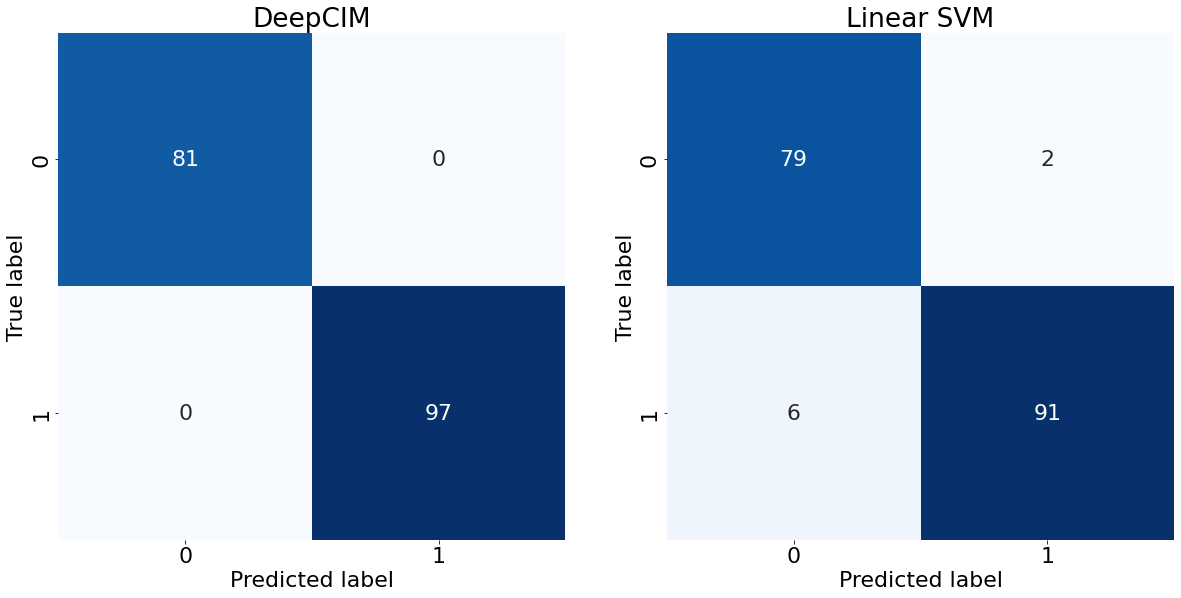

In [118]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))

test_mat = confusion_matrix(np.concatenate([val_labels, test_labels]), 
                            np.concatenate([pred_val_labels, pred_test_labels]))
sns.heatmap(test_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1,2,1))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM')

sns.heatmap(camt_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVM')

plt.savefig('AZ project/DeepCIM/Results/cf_deepcim_svm.jpg', dpi = 150)

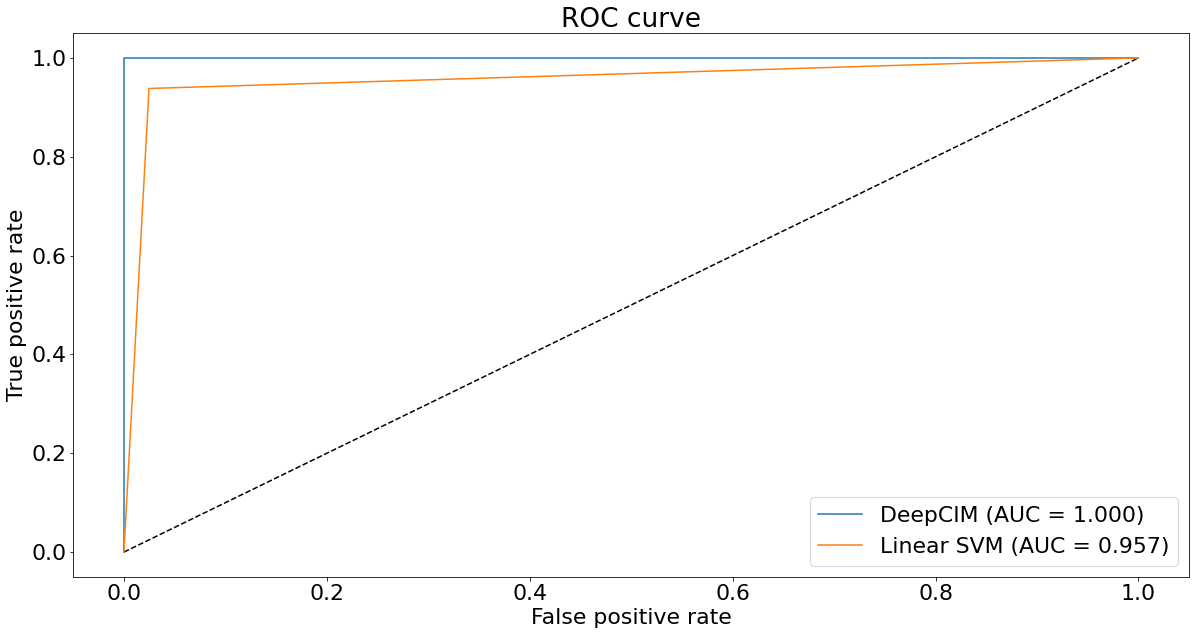

In [119]:
from sklearn.metrics import roc_curve, auc
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(np.concatenate([val_labels, test_labels]), 
                                                            np.concatenate([pred_val_labels, pred_test_labels]))
auc_dnn = auc(fpr_dnn, tpr_dnn)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(Y_test, Y_test_hat_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dnn, tpr_dnn, label='DeepCIM (AUC = {:.3f})'.format(auc_dnn))
plt.plot(fpr_svm, tpr_svm, label='Linear SVM (AUC = {:.3f})'.format(auc_svm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('AZ project/DeepCIM/Results/AUCROC_deepcim_svm.jpg', dpi = 150)
plt.show()

### Test on Davis dataset

In [226]:
df_common = df_name_davis[df_name_davis['DBID'].isin(df_name['DBID'])]
print(np.unique(df_common['label'], return_counts = True))
df_unique = df_name_davis[~df_name_davis['DBID'].isin(df_name['DBID'])]
print(np.unique(df_unique['label'], return_counts = True))

(array([0., 1.]), array([9, 5], dtype=int64))
(array([0., 1.]), array([9, 1], dtype=int64))


In [227]:
np.unique(df_davis_myelo['label'], return_counts = True)

(array([0., 1.]), array([6822, 2274], dtype=int64))

number of unique target sequence: 379
number of unique smiles (molecules): 24
max SMILES len: 72 / max sequence len: 2549
285/285 [==============================] - 1s 4ms/step


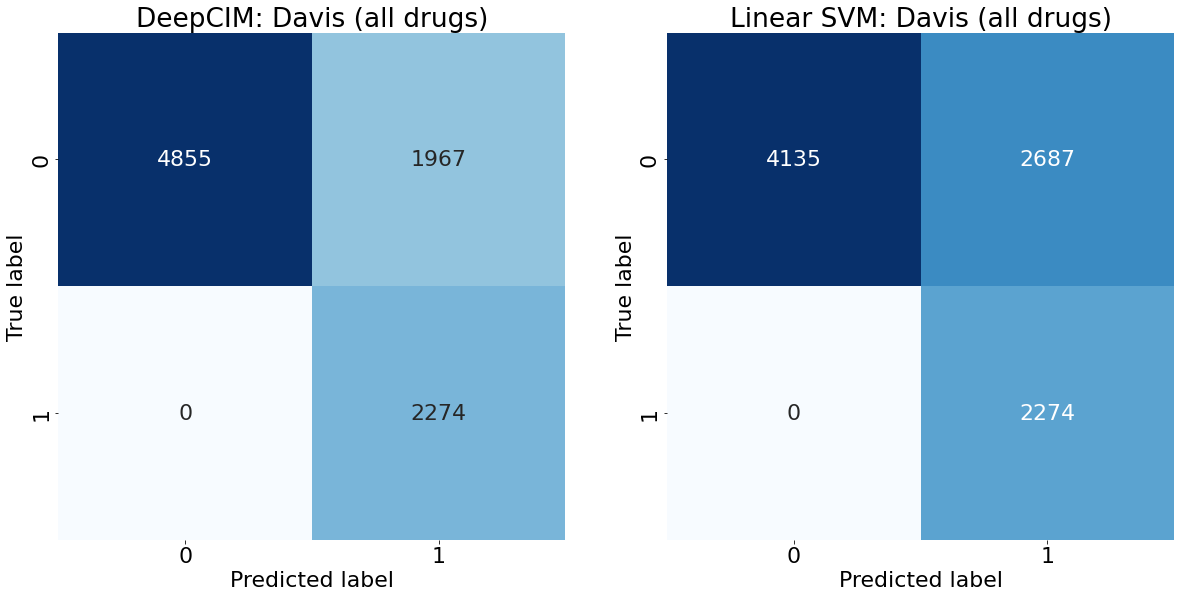

In [229]:
discovery_smiles = df_davis_myelo['Canonical SMILES'].to_numpy()
discovery_proteins = df_davis_myelo['Target'].to_numpy()
discovery_pIC50 = df_davis_myelo['pIC50'].to_numpy()
discovery_labels = to_categorical(df_davis_myelo['label']) # For calculating accuracy at the end of this code
discovery_labels_processed = np.argmax(discovery_labels, axis = 1)

print('number of unique target sequence:',len(np.unique(discovery_proteins)))
print('number of unique smiles (molecules):',len(np.unique(discovery_smiles)))
print('max SMILES len:',df_davis['canonical_len'].max(), '/ max sequence len:',df_davis['sequence_len'].max())

discovery_smiles_sequences = smiles_tokenizer.texts_to_sequences(discovery_smiles)
discovery_smiles_padded = pad_sequences(discovery_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

discovery_proteins_sequences = proteins_tokenizer.texts_to_sequences(discovery_proteins)
discovery_proteins_padded = pad_sequences(discovery_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

pred_discovery_labels = model.predict(x = [discovery_smiles_padded, discovery_proteins_padded, discovery_pIC50])
pred_discovery_labels_processed = np.argmax(pred_discovery_labels, axis = 1)

Y_test_hat_svm = svm.predict(
    np.concatenate([discovery_smiles_padded, discovery_proteins_padded, discovery_pIC50.reshape(-1,1)], axis = 1))


plt.figure(figsize=(20, 20))
discovery_mat = confusion_matrix(discovery_labels_processed, pred_discovery_labels_processed)
sns.heatmap(discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM: Davis (all drugs)')

discovery_mat_svm = confusion_matrix(discovery_labels_processed, Y_test_hat_svm)
sns.heatmap(discovery_mat_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVM: Davis (all drugs)')

plt.savefig('AZ project/DeepCIM/Results/Davis/cf_davis_all.jpg', dpi = 150)

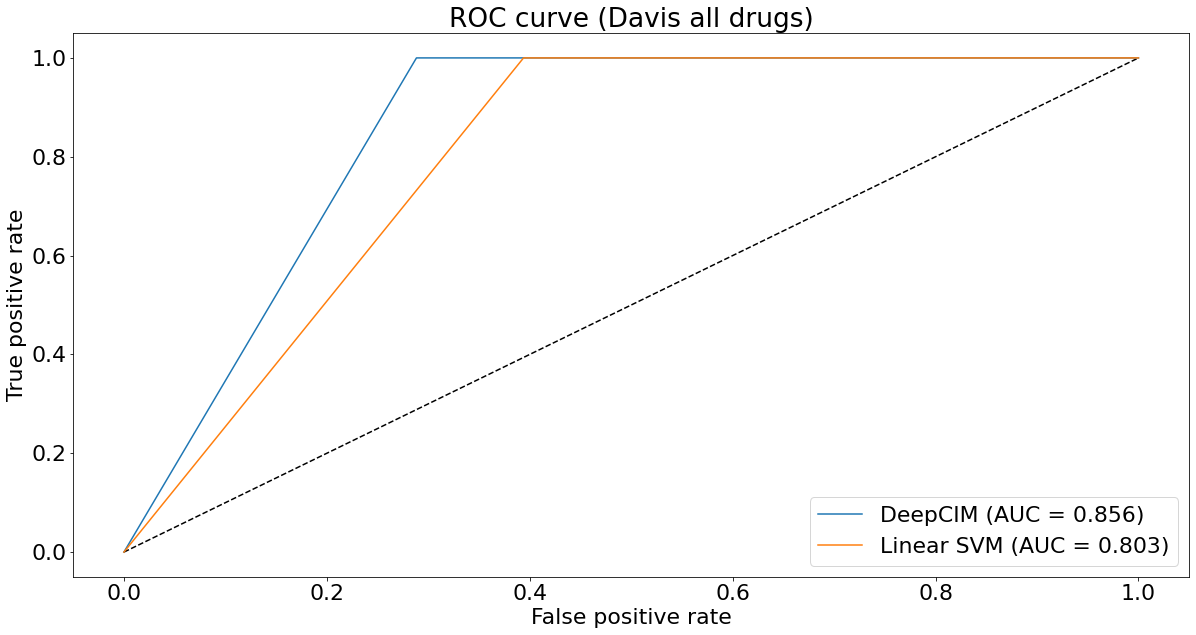

In [231]:
from sklearn.metrics import roc_curve, auc
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(discovery_labels_processed, pred_discovery_labels_processed)
auc_dnn = auc(fpr_dnn, tpr_dnn)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(discovery_labels_processed, Y_test_hat_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dnn, tpr_dnn, label='DeepCIM (AUC = {:.3f})'.format(auc_dnn))
plt.plot(fpr_svm, tpr_svm, label='Linear SVM (AUC = {:.3f})'.format(auc_svm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (Davis all drugs)')
plt.legend(loc='best')
plt.savefig('AZ project/DeepCIM/Results/Davis/AUCROC_davis_all.jpg', dpi = 150)
#plt.savefig('AZ project/DeepCIM/Results/AUCROC.jpg', dpi = 150)
plt.show()

In [232]:
df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])
df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(discovery_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(discovery_mat_svm))
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
0,DeepCIM,0.784,0.536,1.0,0.712,0.288,0.698
1,SVM,0.705,0.458,1.0,0.606,0.394,0.629


number of unique target sequence: 379
number of unique smiles (molecules): 14
max SMILES len: 72 / max sequence len: 2549
166/166 [==============================] - 0s 2ms/step


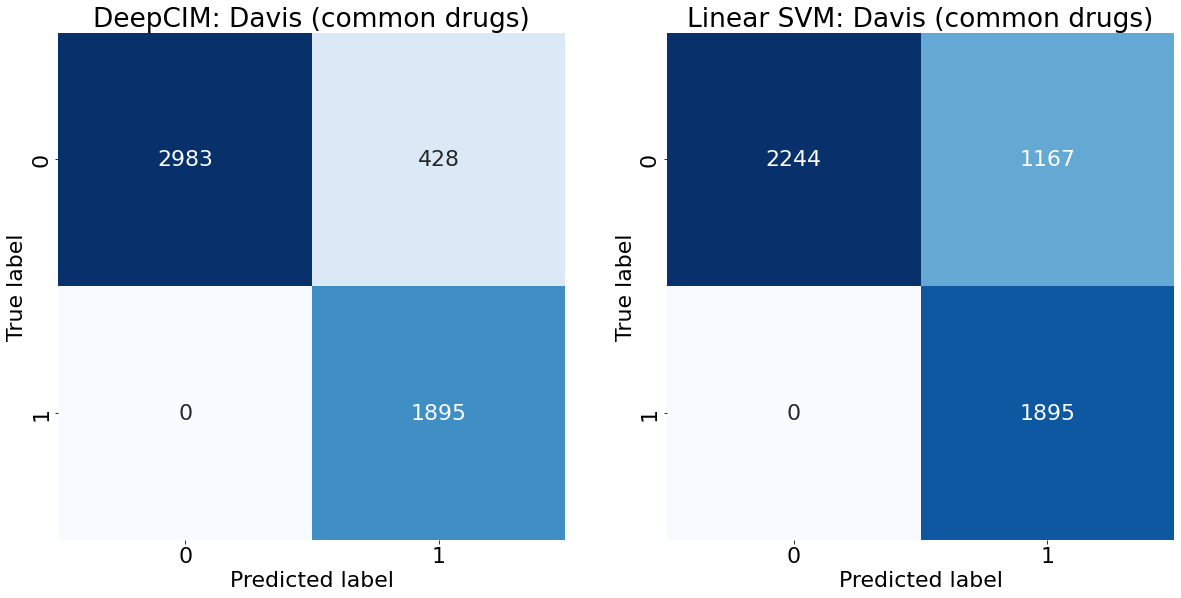

In [233]:
df_c = df_davis[df_davis['DBID'].isin(df_common['DBID'])]

discovery_smiles = df_c['Canonical SMILES'].to_numpy()
discovery_proteins = df_c['Target'].to_numpy()
discovery_pIC50 = df_c['pIC50'].to_numpy()
discovery_labels = to_categorical(df_c['label']) # For calculating accuracy at the end of this code
discovery_labels_processed = np.argmax(discovery_labels, axis = 1)

print('number of unique target sequence:',len(np.unique(discovery_proteins)))
print('number of unique smiles (molecules):',len(np.unique(discovery_smiles)))
print('max SMILES len:',df_davis['canonical_len'].max(), '/ max sequence len:',df_davis['sequence_len'].max())

discovery_smiles_sequences = smiles_tokenizer.texts_to_sequences(discovery_smiles)
discovery_smiles_padded = pad_sequences(discovery_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

discovery_proteins_sequences = proteins_tokenizer.texts_to_sequences(discovery_proteins)
discovery_proteins_padded = pad_sequences(discovery_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

pred_discovery_labels = model.predict(x = [discovery_smiles_padded, discovery_proteins_padded, discovery_pIC50])
pred_discovery_labels_processed = np.argmax(pred_discovery_labels, axis = 1)

Y_test_hat_svm = svm.predict(
    np.concatenate([discovery_smiles_padded, discovery_proteins_padded, discovery_pIC50.reshape(-1,1)], axis = 1))


plt.figure(figsize=(20, 20))
discovery_mat = confusion_matrix(discovery_labels_processed, pred_discovery_labels_processed)
sns.heatmap(discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM: Davis (common drugs)')

discovery_mat_svm = confusion_matrix(discovery_labels_processed, Y_test_hat_svm)
sns.heatmap(discovery_mat_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVM: Davis (common drugs)')

plt.savefig('AZ project/DeepCIM/Results/Davis/cf_davis_common.jpg', dpi = 150)

In [234]:
df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])
df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(discovery_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(discovery_mat_svm))
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
0,DeepCIM,0.919,0.816,1.0,0.875,0.125,0.899
1,SVM,0.780,0.619,1.0,0.658,0.342,0.765


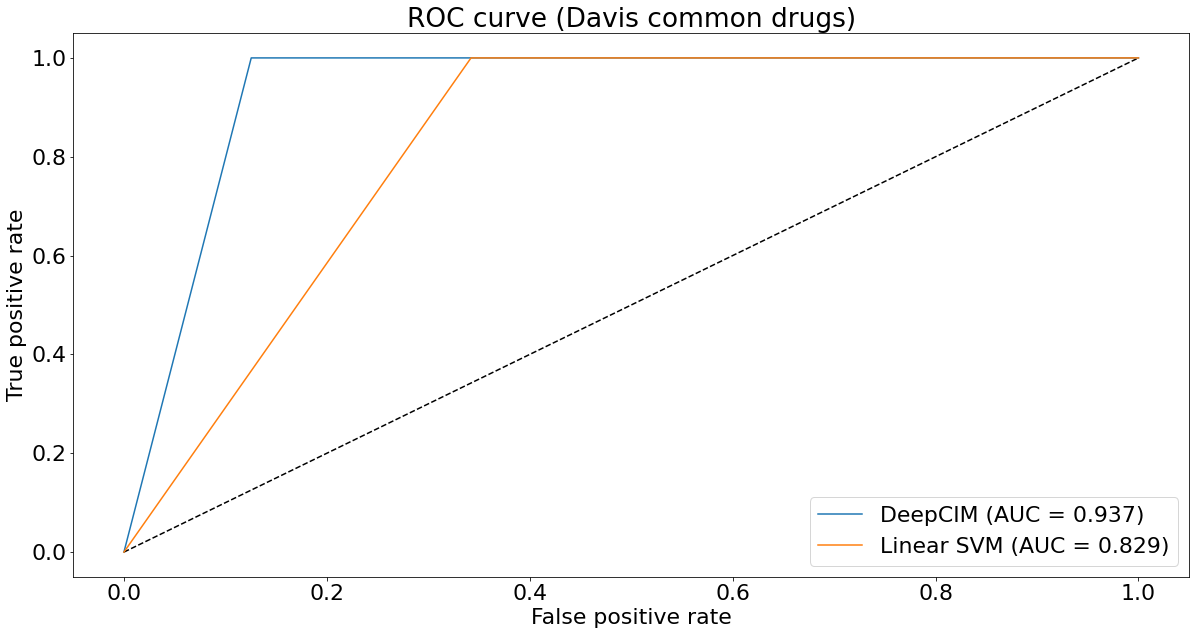

In [235]:
from sklearn.metrics import roc_curve, auc
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(discovery_labels_processed, pred_discovery_labels_processed)
auc_dnn = auc(fpr_dnn, tpr_dnn)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(discovery_labels_processed, Y_test_hat_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dnn, tpr_dnn, label='DeepCIM (AUC = {:.3f})'.format(auc_dnn))
plt.plot(fpr_svm, tpr_svm, label='Linear SVM (AUC = {:.3f})'.format(auc_svm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (Davis common drugs)')
plt.legend(loc='best')
plt.savefig('AZ project/DeepCIM/Results/Davis/AUCROC_davis_common.jpg', dpi = 150)
#plt.savefig('AZ project/DeepCIM/Results/AUCROC.jpg', dpi = 150)
plt.show()

number of unique target sequence: 379
number of unique smiles (molecules): 10
max SMILES len: 72 / max sequence len: 2549
119/119 [==============================] - 1s 6ms/step


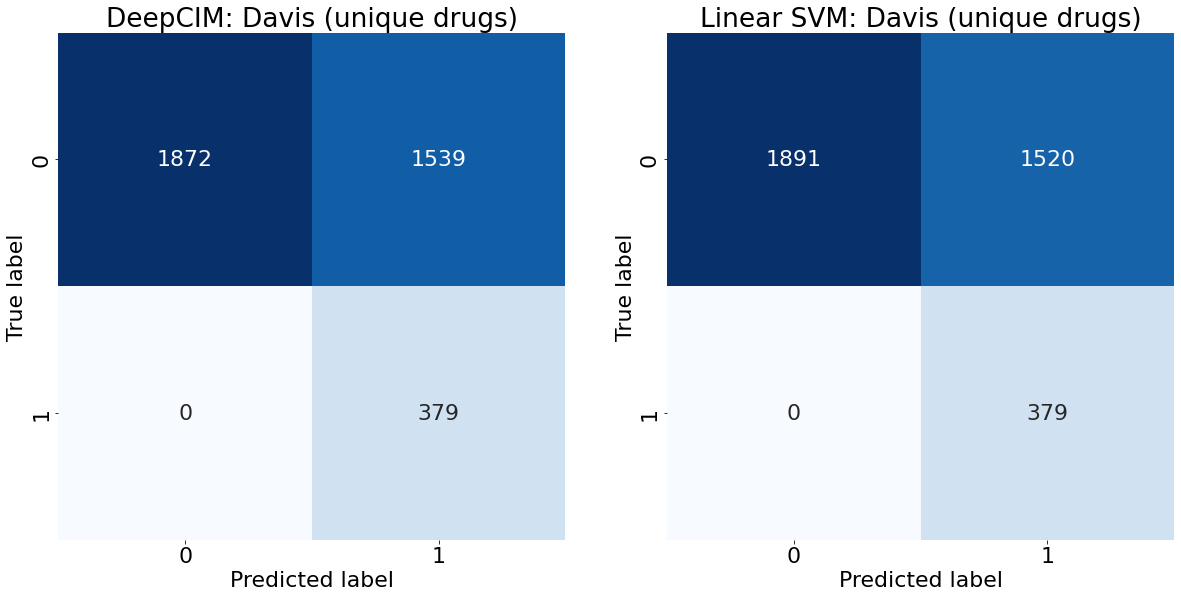

In [236]:
df_u = df_davis[df_davis['DBID'].isin(df_unique['DBID'])]

discovery_smiles = df_u['Canonical SMILES'].to_numpy()
discovery_proteins = df_u['Target'].to_numpy()
discovery_pIC50 = df_u['pIC50'].to_numpy()
discovery_labels = to_categorical(df_u['label']) # For calculating accuracy at the end of this code
discovery_labels_processed = np.argmax(discovery_labels, axis = 1)

print('number of unique target sequence:',len(np.unique(discovery_proteins)))
print('number of unique smiles (molecules):',len(np.unique(discovery_smiles)))
print('max SMILES len:',df_davis['canonical_len'].max(), '/ max sequence len:',df_davis['sequence_len'].max())

discovery_smiles_sequences = smiles_tokenizer.texts_to_sequences(discovery_smiles)
discovery_smiles_padded = pad_sequences(discovery_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

discovery_proteins_sequences = proteins_tokenizer.texts_to_sequences(discovery_proteins)
discovery_proteins_padded = pad_sequences(discovery_proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)

pred_discovery_labels = model.predict(x = [discovery_smiles_padded, discovery_proteins_padded, discovery_pIC50])
pred_discovery_labels_processed = np.argmax(pred_discovery_labels, axis = 1)

Y_test_hat_svm = svm.predict(
    np.concatenate([discovery_smiles_padded, discovery_proteins_padded, discovery_pIC50.reshape(-1,1)], axis = 1))


plt.figure(figsize=(20, 20))
discovery_mat = confusion_matrix(discovery_labels_processed, pred_discovery_labels_processed)
sns.heatmap(discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DeepCIM: Davis (unique drugs)')

discovery_mat_svm = confusion_matrix(discovery_labels_processed, Y_test_hat_svm)
sns.heatmap(discovery_mat_svm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVM: Davis (unique drugs)')

plt.savefig('AZ project/DeepCIM/Results/Davis/cf_davis_unique.jpg', dpi = 150)

In [237]:
df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])
df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(discovery_mat))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(discovery_mat_svm))
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
1,SVM,0.599,0.200,1.0,0.554,0.446,0.333
0,DeepCIM,0.594,0.198,1.0,0.549,0.451,0.330


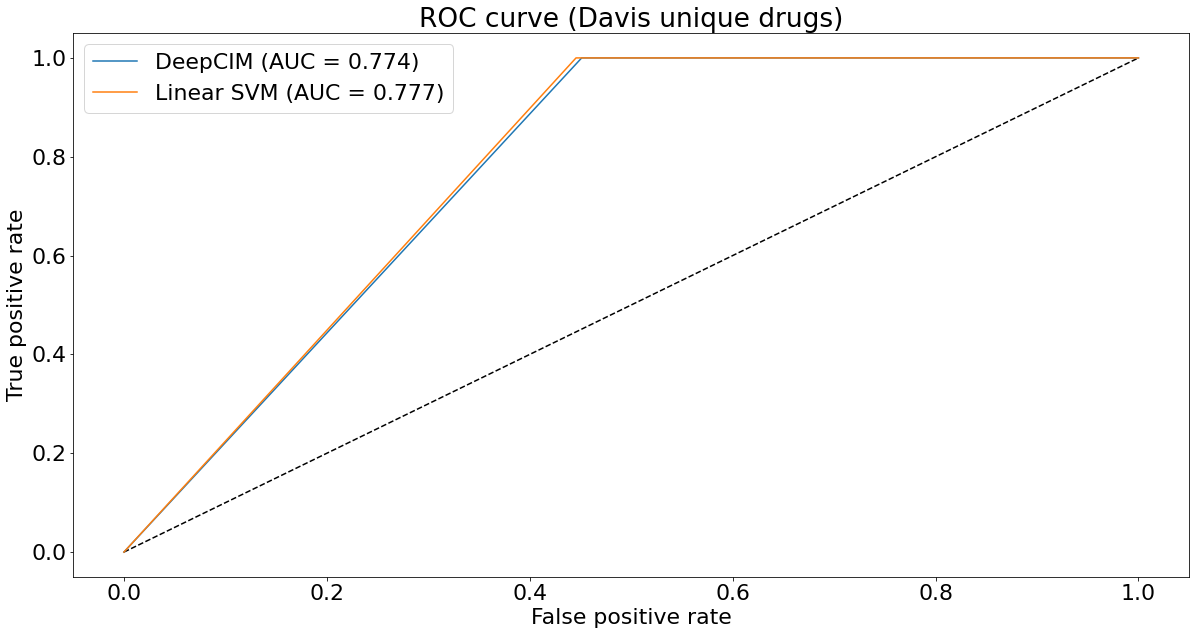

In [238]:
from sklearn.metrics import roc_curve, auc
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(discovery_labels_processed, pred_discovery_labels_processed)
auc_dnn = auc(fpr_dnn, tpr_dnn)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(discovery_labels_processed, Y_test_hat_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dnn, tpr_dnn, label='DeepCIM (AUC = {:.3f})'.format(auc_dnn))
plt.plot(fpr_svm, tpr_svm, label='Linear SVM (AUC = {:.3f})'.format(auc_svm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (Davis unique drugs)')
plt.legend(loc='best')
#plt.savefig('AZ project/DeepCIM/Results/AUCROC.jpg', dpi = 150)
plt.savefig('AZ project/DeepCIM/Results/Davis/AUCROC_davis_unique.jpg', dpi = 150)
plt.show()

In [ ]:
df_davis_new = df_davis_myelo[['Canonical SMILES', 'pIC50', 'label']]
df_davis_new['pred_label'] = pred_discovery_labels_processed
df_davis_new = df_davis_new.groupby(['Canonical SMILES']).mean().reset_index() #### Mean values calculated
df_davis_new['pred_label'] = df_davis_new['pred_label'].apply(lambda x: round(x)) #### And rounded up to integer (0,1,2)
print('\n')
print('real label:', np.unique(df_davis_new['label'], return_counts = True))
print('pred label:', np.unique(df_davis_new['pred_label'], return_counts = True))

df_davis_new['correct'] = np.where(df_davis_new['label'] == df_davis_new['pred_label'], 'yes', 'no')
print('\n')
print('falsely predicted labels:',np.unique(df_davis_new[df_davis_new['correct'] == 'no'].label, return_counts = True))
print('correctly predicted labels:',np.unique(df_davis_new[df_davis_new['correct'] == 'yes'].label, return_counts = True))

new_discovery_mat = confusion_matrix(df_davis_new['label'], df_davis_new['pred_label'])

plt.figure(figsize=(10, 10))
sns.heatmap(new_discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1'], yticklabels = ['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Mat. Test set')
print(modelPerformance(new_discovery_mat))
print(classification_report(df_davis_new['label'], df_davis_new['pred_label'])) ## Wrong for multi-label classification!

In [96]:
df_new

,Canonical SMILES,pIC50,label,pred_label,correct
0,CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCC...,5.129598,0.0,0,yes
1,CC(Oc1cc(-c2cnn(C3CCNCC3)c2)cnc1N)c1c(Cl)ccc(F...,5.519605,0.0,0,yes
2,CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,5.113718,1.0,1,yes
3,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4ccccn4)c(Cl)c3)c2...,5.342348,0.0,1,no
4,CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1,5.306151,0.0,1,no
5,COC(=O)c1ccc2c(c1)NC(=O)C2=C(Nc1ccc(N(C)C(=O)C...,5.956501,0.0,0,yes
6,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,5.357015,0.0,0,yes
7,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,5.122782,0.0,1,no
8,Cc1cnc(Nc2ccc(OCCN3CCCC3)cc2)nc1Nc1cccc(S(=O)(...,5.798904,0.0,0,yes
9,Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21,5.010390,0.0,1,no


# Pivot

In [105]:
df_myelo_target = pd.DataFrame({'Target Name':np.unique(df_myelo['Uniprot Name'], return_counts = True)[0],
                          'Drug Instances':np.unique(df_myelo['Uniprot ID'], return_counts = True)[1]})
df_myelo_target = df_myelo_target.sort_values(by = 'Drug Instances', ascending = False)
df_myelo_target = df_myelo_target[df_myelo_target['Drug Instances'] > 10]
display(df_myelo_target)
print(df_myelo_target['Drug Instances'].sum())

df_davis_myelo_target = pd.DataFrame({'Target Name':np.unique(df_davis_myelo['Target_ID'], return_counts = True)[0],
                          'Drug Instances':np.unique(df_davis_myelo['Target_ID'], return_counts = True)[1]})
df_davis_myelo_target = df_davis_myelo_target.sort_values(by = 'Drug Instances', ascending = False)
df_davis_myelo_target = df_davis_myelo_target[df_davis_myelo_target['Drug Instances'] > 10]
display(df_davis_myelo_target)
print(df_davis_myelo_target['Drug Instances'].sum())

,Target Name,Drug Instances
14,ANDR,53
15,AOXA,53
40,CD5R1,23
39,CCNT1,18
280,TYSY,17
70,DHB2,15
146,KCNH2,14
73,DPP3,14
222,PMYT1,14
102,GBRR1,11


243


,Target Name,Drug Instances
0,AAK1,24
249,PDGFRB,24
258,PIK3C2G,24
257,PIK3C2B,24
256,PHKG2,24
...,...,...
124,FGFR1,24
123,FES,24
122,FER,24
121,FAK,24


9096


In [107]:
print('number of unique target ID for df_myelo:', len(df_myelo['Uniprot Name'].unique()))
print('number of unique target ID for df_davis_myelo:', len(df_davis_myelo['Target_ID'].unique()))

number of unique target ID for df_myelo: 288
number of unique target ID for df_davis_myelo: 379


In [108]:
print('Sequence match')
print(len(set(df_myelo['BindingDB Target Chain Sequence']) & set(df_davis_myelo['Target'])))
print(len(set(df_tdc['Target']) & set(df_davis_myelo['Target'])))

Sequence match
87
295


In [109]:
myelo_target = list(df_myelo['Uniprot Name'].unique())
davis_myelo_target = list(df_davis_myelo['Target_ID'].unique())
print(len(myelo_target), len(davis_myelo_target))
pivot_columns = np.unique(myelo_target + davis_myelo_target)
pivot_columns.shape

288 379


(615,)

In [110]:
df_myelo_pivot = df_myelo.pivot_table(values = 'pIC50', index = 'Canonical SMILES', columns = 'Uniprot Name', 
                           fill_value = 0, aggfunc = 'mean').reset_index()
df_davis_myelo_pivot = df_davis_myelo.pivot_table(values = 'pIC50', index = 'Canonical SMILES', columns = 'Target_ID', 
                           fill_value = 0, aggfunc = 'mean').reset_index()

In [111]:
df_bdb_pivot = df_myelo_pivot.reindex(columns = ['Canonical SMILES'] + list(pivot_columns))
df_bdb_pivot = df_bdb_pivot.fillna(0)
df_bdb_pivot = pd.merge(df_bdb_pivot, df_name[['Canonical SMILES', 'canonical_len', 'label', 'name']],
         how = 'inner', left_on = 'Canonical SMILES', right_on = 'Canonical SMILES')

df_davis_pivot = df_davis_myelo_pivot.reindex(columns = ['Canonical SMILES'] + list(pivot_columns))
df_davis_pivot = df_davis_pivot.fillna(0)
df_davis_pivot = pd.merge(df_davis_pivot, df_name_davis[['Canonical SMILES', 'canonical_len', 'label', 'name']],
         how = 'inner', left_on = 'Canonical SMILES', right_on = 'Canonical SMILES')

print(df_myelo_pivot.shape, df_bdb_pivot.shape, df_davis_myelo_pivot.shape, df_davis_pivot.shape)

(112, 289) (112, 619) (24, 380) (24, 619)


In [112]:
df_bdb_pivot['canonical_len'].max()

167

In [113]:
df_davis_pivot['canonical_len'].max()

70

# Pivot training on BindingDB and test on Davis

In [117]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
#scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler = preprocessing.StandardScaler()
## now pIC50 values are signatures

smiles = df_bdb_pivot['Canonical SMILES'].to_numpy()
proteins = scaler.fit_transform(df_bdb_pivot.iloc[:, 1:-3].to_numpy())
#proteins = df_bdb_pivot.iloc[:, 1:-3].to_numpy()
labels = to_categorical(df_bdb_pivot['label'])

print('number of unique target signatures (pIC50):',len(np.unique(proteins)))
print('number of unique smiles (molecules):',len(np.unique(smiles)))

number of unique target signatures (pIC50): 777
number of unique smiles (molecules): 112


In [120]:
# Train test val split using scikit learn

train_smiles, eval_smiles, train_proteins, eval_proteins, train_labels, eval_labels = \
train_test_split(smiles, proteins, labels, test_size = 0.2, random_state = 1279)

val_smiles, test_smiles, val_proteins, test_proteins, val_labels, test_labels = \
train_test_split(eval_smiles, eval_proteins, eval_labels, test_size = 0.5, random_state = 929)

print(np.unique(np.argmax(train_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(val_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(test_labels, axis = 1), return_counts = True))

train_smiles_sequences = smiles_tokenizer.texts_to_sequences(train_smiles)
train_smiles_padded = pad_sequences(train_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
val_smiles_sequences = smiles_tokenizer.texts_to_sequences(val_smiles)
val_smiles_padded = pad_sequences(val_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
test_smiles_sequences = smiles_tokenizer.texts_to_sequences(test_smiles)
test_smiles_padded = pad_sequences(test_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

(array([0, 1], dtype=int64), array([58, 31], dtype=int64))
(array([0, 1], dtype=int64), array([6, 5], dtype=int64))
(array([0, 1], dtype=int64), array([4, 8], dtype=int64))


In [125]:
tf.keras.backend.clear_session()

smile_input = Input(shape = (170,), name = 'SMILES')
protein_input = Input(shape = (proteins.shape[1],), name = 'Proteins')

li_smile = Dense(1024)(smile_input)
li_smile = Dense(512, activation = 'relu')(li_smile)
li_smile = Dense(256, activation = 'relu')(li_smile)
li_smile = Dense(128, activation = 'relu')(li_smile)

li_protein = Dense(1024)(protein_input)
li_protein = Dense(512, activation = 'relu')(li_protein)
li_protein = Dense(256, activation = 'relu')(li_protein)
li_protein = Dense(128, activation = 'relu')(li_protein)

concat_layer = Concatenate()([li_smile, li_protein])

fw = Dense(1024, activation = 'relu')(concat_layer)
fw = Dropout(0.1)(fw)
fw = Dense(512, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(256, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(128, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(32, activation = 'relu')(fw)
out_layer = Dense(2, activation = 'sigmoid')(fw)

model = Model(inputs = [smile_input, protein_input], outputs = out_layer)
opt = optimizers.Adam(learning_rate = 0.000005)
model.compile(loss = 'BinaryCrossentropy', optimizer = opt, metrics = ['Accuracy'])


###############################################################################################
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                          patience = 50, verbose = 1,
                          #restore_best_weights = True
                          ) 
#checkpoint = ModelCheckpoint('AZ project/DeepCIM/82mse_500adam0005b256_bestval.h5',
#                            monitor = 'val_loss', mode = 'min',
#                            save_best_only = True, verbose = 1
#                            )

In [136]:
history = model.fit(
    x = [train_smiles_padded, train_proteins],
    y = train_labels,
    epochs = 500, batch_size = 4,
    validation_data = ([val_smiles_padded, val_proteins], val_labels),
    callbacks = [early_stop]#, checkpoint]
)

Epoch 1/500
23/23 [==============================] - 0s 14ms/step - loss: 1.4731e-05 - Accuracy: 1.0000 - val_loss: 2.3490 - val_Accuracy: 0.6364
Epoch 2/500
23/23 [==============================] - 0s 12ms/step - loss: 7.6487e-06 - Accuracy: 1.0000 - val_loss: 2.3419 - val_Accuracy: 0.6364
Epoch 3/500
23/23 [==============================] - 0s 12ms/step - loss: 1.6144e-05 - Accuracy: 1.0000 - val_loss: 2.3510 - val_Accuracy: 0.6364
Epoch 4/500
23/23 [==============================] - 0s 11ms/step - loss: 1.2653e-05 - Accuracy: 1.0000 - val_loss: 2.3803 - val_Accuracy: 0.6364
Epoch 5/500
23/23 [==============================] - 0s 12ms/step - loss: 1.0847e-05 - Accuracy: 1.0000 - val_loss: 2.3992 - val_Accuracy: 0.6364
Epoch 6/500
23/23 [==============================] - 0s 11ms/step - loss: 1.0101e-05 - Accuracy: 1.0000 - val_loss: 2.4048 - val_Accuracy: 0.6364
Epoch 7/500
23/23 [==============================] - 0s 12ms/step - loss: 7.5435e-06 - Accuracy: 1.0000 - val_loss: 2.3893 -

Epoch 57/500
23/23 [==============================] - 0s 11ms/step - loss: 3.2114e-06 - Accuracy: 1.0000 - val_loss: 2.2985 - val_Accuracy: 0.7273
Epoch 58/500
23/23 [==============================] - 0s 10ms/step - loss: 5.8181e-06 - Accuracy: 1.0000 - val_loss: 2.3104 - val_Accuracy: 0.7273
Epoch 59/500
23/23 [==============================] - 0s 10ms/step - loss: 5.1342e-06 - Accuracy: 1.0000 - val_loss: 2.3218 - val_Accuracy: 0.7273
Epoch 60/500
23/23 [==============================] - 0s 10ms/step - loss: 5.0586e-06 - Accuracy: 1.0000 - val_loss: 2.3224 - val_Accuracy: 0.7273
Epoch 61/500
23/23 [==============================] - 0s 11ms/step - loss: 3.1409e-06 - Accuracy: 1.0000 - val_loss: 2.3316 - val_Accuracy: 0.7273
Epoch 62/500
23/23 [==============================] - 0s 10ms/step - loss: 6.9138e-06 - Accuracy: 1.0000 - val_loss: 2.3428 - val_Accuracy: 0.7273
Epoch 63/500
23/23 [==============================] - 0s 10ms/step - loss: 5.7905e-06 - Accuracy: 1.0000 - val_loss: 2

Training accuracy: 1.0 Validation accuracy: 0.727
Training categorical crossentropy: 0.0 Validation categorical crossentropy: 2.468


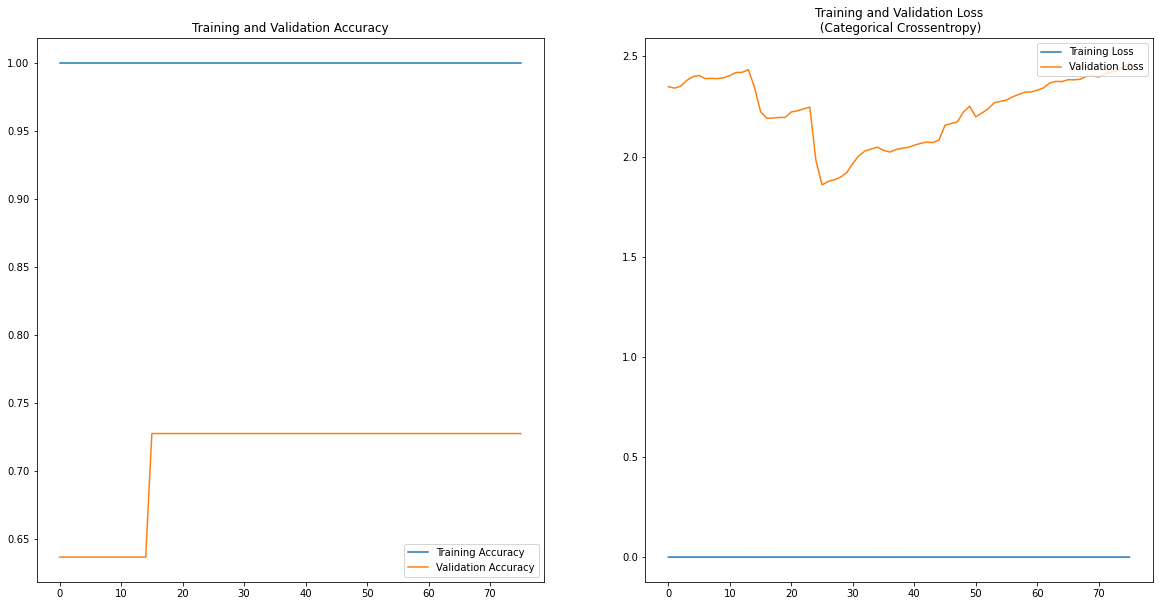

In [137]:
df_history = pd.DataFrame(history.history)
df_history['epoch'] = df_history.index+1
epochs_range = range(df_history['epoch'].max())

acc = df_history['Accuracy'].to_numpy()
val_acc = df_history['val_Accuracy'].to_numpy()
loss=df_history['loss'].to_numpy()
val_loss=df_history['val_loss'].to_numpy()

print('Training accuracy:', np.round(acc[-1],3), 'Validation accuracy:', np.round(val_acc[-1], 3))
print('Training categorical crossentropy:', np.round(loss[-1],3), 'Validation categorical crossentropy:', np.round(val_loss[-1], 3))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss\n (Categorical Crossentropy)')
plt.show()

1/1 [==============================] - 0s 21ms/step - loss: 4.2396 - Accuracy: 0.6667


Text(0.5, 1.0, 'Confusion Mat. Val set')

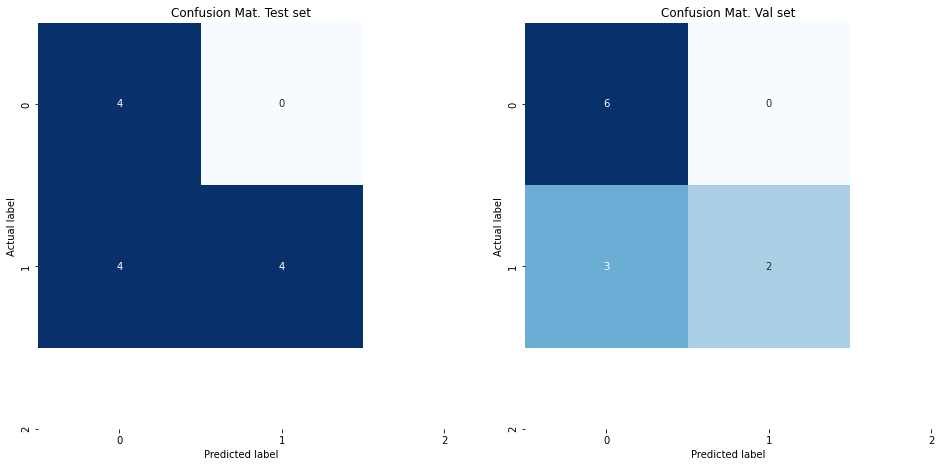

In [140]:
pred_val_labels = model.predict(x = [val_smiles_padded, val_proteins])
pred_test_labels = model.predict(x = [test_smiles_padded, test_proteins])
model.evaluate(x = [test_smiles_padded, test_proteins], y = test_labels)

# from one-hot encoding to labels

pred_val_labels = np.argmax(pred_val_labels, axis = 1)
pred_test_labels = np.argmax(pred_test_labels, axis = 1)
train_labels = np.argmax(train_labels, axis = 1)
val_labels = np.argmax(val_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16, 8))

test_mat = confusion_matrix(test_labels, pred_test_labels)
sns.heatmap(test_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1', '2'], yticklabels = ['0', '1', '2'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Mat. Test set')


val_mat = confusion_matrix(val_labels, pred_val_labels)
sns.heatmap(val_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1', '2'], yticklabels = ['0', '1', '2'], ax = plt.subplot(1, 2, 2))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Mat. Val set')

In [142]:
X_train = np.concatenate([train_smiles_padded, train_proteins], axis = 1)
X_test = np.concatenate([test_smiles_padded, test_proteins], axis = 1)
Y_train = train_labels
Y_test = test_labels
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

randomSeed = 500
nIter = 30

# Ridge Logistic Regression
logreg = LogisticRegression(penalty= 'l2', random_state = randomSeed)
logreg.fit(X_train, Y_train)
Y_test_hat_logreg = logreg.predict(X_test)
cmat_logreg = confusion_matrix(Y_test, Y_test_hat_logreg)

## Random Forest
rf = RandomForestClassifier(n_estimators=nIter, criterion='gini', random_state=randomSeed)
rf.fit(X_train, Y_train)
Y_test_hat_rf = rf.predict(X_test)
cmat_rf = confusion_matrix(Y_test, Y_test_hat_rf)

## SVM
svm = SVC(kernel='linear', C=1, random_state = randomSeed)
svm.fit(X_train, Y_train)
Y_test_hat_svm = svm.predict(X_test)
camt_svm = confusion_matrix(Y_test, Y_test_hat_svm)

## Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_test_hat_gnb = gnb.predict(X_test)
cmat_gnb = confusion_matrix(Y_test, Y_test_hat_gnb)

## Decision Tree
dt = DecisionTreeClassifier(random_state = randomSeed)
dt.fit(X_train, Y_train)
Y_test_hat_dt = dt.predict(X_test)
cmat_dt = confusion_matrix(Y_test, Y_test_hat_dt)

df_summary = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'FPR', 'f1 score'])

df_summary.loc[len(df_summary)] = ['DeepCIM'] + list(modelPerformance(test_mat))
df_summary.loc[len(df_summary)] = ['Logistic Regression (L2)'] + list(modelPerformance(cmat_logreg))
df_summary.loc[len(df_summary)] = ['Random Forest'] + list(modelPerformance(cmat_rf))
df_summary.loc[len(df_summary)] = ['SVM'] + list(modelPerformance(camt_svm))
df_summary.loc[len(df_summary)] = ['Naive Bayes'] + list(modelPerformance(cmat_gnb))
df_summary.loc[len(df_summary)] = ['Decision Tree'] + list(modelPerformance(cmat_dt))
#df_summary.loc[len(df_summary)] = ['Chemical space only'] + [0.462, 0.4, 0.333, 0.571, 0.429, 0.364]
#df_summary.loc[len(df_summary)] = ['Biological space only'] + [0.643, 0.548, 0.607, 0.667, 0.333, 0.576]
df_summary = df_summary.round(3)
df_summary = df_summary.sort_values('Accuracy', ascending = False)
df_summary

(89, 785) (89,)
(12, 785) (12,)


,Model,Accuracy,Precision,Recall,Specificity,FPR,f1 score
5,Decision Tree,0.750,0.778,0.875,0.50,0.50,0.824
0,DeepCIM,0.667,1.000,0.500,1.00,0.00,0.667
4,Naive Bayes,0.667,0.750,0.750,0.50,0.50,0.750
1,Logistic Regression (L2),0.500,0.750,0.375,0.75,0.25,0.500
2,Random Forest,0.500,1.000,0.250,1.00,0.00,0.400
3,SVM,0.417,0.600,0.375,0.50,0.50,0.462


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
#scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler = preprocessing.StandardScaler()
## now pIC50 values are signatures

smiles = df_bdb_pivot['Canonical SMILES'].to_numpy()
proteins = scaler.fit_transform(df_bdb_pivot.iloc[:, 1:-3].to_numpy())
#proteins = df_bdb_pivot.iloc[:, 1:-3].to_numpy()
labels = to_categorical(df_bdb_pivot['label'])

print('number of unique target signatures (pIC50):',len(np.unique(proteins)))
print('number of unique smiles (molecules):',len(np.unique(smiles)))

In [144]:
df_bdb_pivot.shape

(112, 619)

In [143]:
df_davis_pivot.shape

(24, 619)

In [147]:
pred_discovery_labels_processed

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0], dtype=int64)

In [145]:
discovery_smiles = df_davis_pivot['Canonical SMILES'].to_numpy()
discovery_proteins = scaler.fit_transform(df_davis_pivot.iloc[:, 1:-3].to_numpy())
#discovery_pIC50 = df_davis_myelo['pIC50'].to_numpy()
discovery_labels = to_categorical(df_davis_pivot['label']) # For calculating accuracy at the end of this code

print('number of unique target sequence:',len(np.unique(discovery_proteins)))
print('number of unique smiles (molecules):',len(np.unique(discovery_smiles)))
print('max SMILES len:',df_davis['canonical_len'].max(), '/ max sequence len:',df_davis['sequence_len'].max())

discovery_smiles_sequences = smiles_tokenizer.texts_to_sequences(discovery_smiles)
discovery_smiles_padded = pad_sequences(discovery_smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)

pred_discovery_labels = model.predict(x = [discovery_smiles_padded, discovery_proteins])
pred_discovery_labels_processed = np.argmax(pred_discovery_labels, axis = 1)

df_davis_new = df_davis_myelo[['Canonical SMILES', 'pIC50', 'label']]
df_davis_new['pred_label'] = pred_discovery_labels_processed
df_davis_new = df_davis_new.groupby(['Canonical SMILES']).mean().reset_index() #### Mean values calculated
df_davis_new['pred_label'] = df_davis_new['pred_label'].apply(lambda x: round(x)) #### And rounded up to integer (0,1,2)
print('\n')
print('real label:', np.unique(df_davis_new['label'], return_counts = True))
print('pred label:', np.unique(df_davis_new['pred_label'], return_counts = True))

df_davis_new['correct'] = np.where(df_davis_new['label'] == df_davis_new['pred_label'], 'yes', 'no')
print('\n')
print('falsely predicted labels:',np.unique(df_davis_new[df_davis_new['correct'] == 'no'].label, return_counts = True))
print('correctly predicted labels:',np.unique(df_davis_new[df_davis_new['correct'] == 'yes'].label, return_counts = True))

plt.figure(figsize=(16, 8))
discovery_mat = confusion_matrix(df_davis_new['label'], df_davis_new['pred_label'])
sns.heatmap(discovery_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = ['0', '1', '2'], yticklabels = ['0', '1', '2'], ax = plt.subplot(1, 2, 1))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Mat. Test set')

model.evaluate(x = [discovery_smiles_padded, discovery_proteins_padded, discovery_pIC50], y = discovery_labels)
printPerformance(discovery_mat)
print(classification_report(df_davis_new['label'], df_davis_new['pred_label'])) ## Wrong for multi-label classification!

number of unique target sequence: 2716
number of unique smiles (molecules): 24
max SMILES len: 72 / max sequence len: 2549
1/1 [==============================] - 0s 15ms/step


ValueError: Length of values (24) does not match length of index (9096)

### Try protein sequence + embedding layer

In [51]:
myelo_target = list(df_myelo['BindingDB Target Chain Sequence'].unique())
davis_myelo_target = list(df_davis_myelo['Target'].unique())
print(len(myelo_target), len(davis_myelo_target))
pivot_columns = np.unique(myelo_target + davis_myelo_target)
pivot_columns.shape

308 379


(600,)

In [52]:
df_myelo_pivot = df_myelo.pivot_table(values = 'pIC50', index = 'Canonical SMILES', columns = 'BindingDB Target Chain Sequence', 
                           fill_value = 0, aggfunc = 'mean').reset_index()
df_davis_myelo_pivot = df_davis_myelo.pivot_table(values = 'pIC50', index = 'Canonical SMILES', columns = 'Target', 
                           fill_value = 0, aggfunc = 'mean').reset_index()

df_bdb_pivot = df_myelo_pivot.reindex(columns = ['Canonical SMILES'] + list(pivot_columns))
df_bdb_pivot = df_bdb_pivot.fillna(0)
df_bdb_pivot = pd.merge(df_bdb_pivot, df_name[['Canonical SMILES', 'canonical_len', 'label', 'name']],
         how = 'inner', left_on = 'Canonical SMILES', right_on = 'Canonical SMILES')

df_davis_pivot = df_davis_myelo_pivot.reindex(columns = ['Canonical SMILES'] + list(pivot_columns))
df_davis_pivot = df_davis_pivot.fillna(0)
df_davis_pivot = pd.merge(df_davis_pivot, df_name_davis[['Canonical SMILES', 'canonical_len', 'label', 'name']],
         how = 'inner', left_on = 'Canonical SMILES', right_on = 'Canonical SMILES')

print(df_myelo_pivot.shape, df_bdb_pivot.shape, df_davis_myelo_pivot.shape, df_davis_pivot.shape)

(115, 309) (115, 604) (24, 380) (24, 604)


In [44]:
## Tokenise uising larger dataset

all_smiles = df_IC_post['Canonical SMILES'].unique()
all_proteins = df_IC_post['BindingDB Target Chain Sequence'].unique()

# Tokenise SMILES and A.A. Target Sequences

smiles_tokenizer = Tokenizer(char_level = True)
smiles_tokenizer.fit_on_texts(all_smiles)
smiles_word_index = smiles_tokenizer.word_index
smiles_vocab_size = len(smiles_word_index)

proteins_tokenizer = Tokenizer(char_level = True)
proteins_tokenizer.fit_on_texts(all_proteins)
proteins_word_index = proteins_tokenizer.word_index
proteins_vocab_size = len(proteins_word_index)
print(smiles_vocab_size, proteins_vocab_size)

44 20


In [53]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

#scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler = preprocessing.StandardScaler()
## now pIC50 values are signatures along with protein sequence
smiles = df_bdb_pivot['Canonical SMILES'].to_numpy()
pIC50 = scaler.fit_transform(df_bdb_pivot.iloc[:, 1:-3].to_numpy())
labels = to_categorical(df_bdb_pivot['label'])
proteins = pivot_columns

smiles_sequences = smiles_tokenizer.texts_to_sequences(smiles)
smiles_padded = pad_sequences(smiles_sequences, truncating = 'post', padding = 'post', maxlen = 170)
proteins_sequences = proteins_tokenizer.texts_to_sequences(pivot_columns)
proteins_padded = pad_sequences(proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
proteins_padded = np.repeat(proteins_padded.flatten().reshape(1,-1), len(smiles_padded), axis = 0)
print(smiles_padded.shape, proteins_padded.shape)

train_smiles, eval_smiles, train_proteins, eval_proteins, train_pIC50, eval_pIC50, train_labels, eval_labels = \
train_test_split(smiles_padded, proteins_padded, pIC50, labels, test_size = 0.2, random_state = 1279)

val_smiles, test_smiles, val_proteins, test_proteins, val_pIC50, test_pIC50, val_labels, test_labels = \
train_test_split(eval_smiles, eval_proteins, eval_pIC50, eval_labels, test_size = 0.5, random_state = 929)

print("Train set shape:",train_smiles.shape, train_proteins.shape, train_pIC50.shape)
print("Val set shape:  ",val_smiles.shape, val_proteins.shape, val_pIC50.shape)
print("Test set shape: ",test_smiles.shape, test_proteins.shape, test_pIC50.shape)

print(np.unique(np.argmax(labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(train_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(val_labels, axis = 1), return_counts = True))
print(np.unique(np.argmax(test_labels, axis = 1), return_counts = True))

(115, 220) (115, 2476800)
Train set shape: (92, 220) (92, 2476800) (92, 600)
Val set shape:   (11, 220) (11, 2476800) (11, 600)
Test set shape:  (12, 220) (12, 2476800) (12, 600)
(array([0, 1]), array([69, 46]))
(array([0, 1]), array([61, 31]))
(array([0, 1]), array([2, 9]))
(array([0, 1]), array([6, 6]))


In [66]:
proteins = pivot_columns
print(proteins.shape)
proteins_sequences = proteins_tokenizer.texts_to_sequences(pivot_columns)
proteins_padded = pad_sequences(proteins_sequences, truncating = 'post', padding = 'post', maxlen = 2600)
print(proteins_padded.shape)

(600,)
(600, 4128)


In [67]:
print(smiles_padded.shape)
print(labels.shape)
print(proteins_padded.shape)

(115, 220)
(115, 2)
(600, 4128)


In [ ]:
tf.keras.backend.clear_session()

smile_input = Input(shape = (smiles_padded.shape[1],), name = 'SMILES')
protein_input = Input(shape = (proteins_padded.shape[1],), name = 'Proteins')
pIC50_input = Input(shape = (pIC50.shape[1],), name = 'pIC50')

li_smile = Dense(1024)(smile_input)
li_smile = Dense(512, activation = 'relu')(li_smile)
li_smile = Dense(256, activation = 'relu')(li_smile)
li_smile = Dense(128, activation = 'relu')(li_smile)


embed_protein = Embedding(input_dim = proteins_padded.shape[1],
                          output_dim = 1024)(protein_input)
li_protein = Dense(512, activation = 'relu')(embed_protein)
li_protein = Dense(256, activation = 'relu')(li_protein)
li_protein = Dense(128, activation = 'relu')(li_protein)

li_pIC50 = Dense(1024)(pIC50_input)
li_pIC50 = Dense(512, activation = 'relu')(li_pIC50)
li_pIC50 = Dense(256, activation = 'relu')(li_pIC50)
li_pIC50 = Dense(128, activation = 'relu')(li_pIC50)

concat_layer = Concatenate()([li_smile, li_protein, li_pIC50])

fw = Dense(1024, activation = 'relu')(concat_layer)
fw = Dropout(0.1)(fw)
fw = Dense(512, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(256, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(128, activation = 'relu')(fw)
fw = Dropout(0.1)(fw)
fw = Dense(32, activation = 'relu')(fw)
out_layer = Dense(2, activation = 'sigmoid')(fw)

model = Model(inputs = [smile_input, protein_input,pIC50_input], outputs = out_layer)
opt = optimizers.Adam(learning_rate = 0.000005)
model.compile(loss = 'BinaryCrossentropy', optimizer = opt, metrics = ['Accuracy'])


###############################################################################################
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                          patience = 10, verbose = 1,
                          #restore_best_weights = True
                          ) 
#checkpoint = ModelCheckpoint('AZ project/DeepCIM/82mse_500adam0005b256_bestval.h5',
#                            monitor = 'val_loss', mode = 'min',
#                            save_best_only = True, verbose = 1
#                            )

In [52]:
history = model.fit(
    x = [train_smiles, train_proteins, train_pIC50],
    y = train_labels,
    epochs = 500, batch_size = 90,
    validation_data = ([val_smiles, val_proteins, val_pIC50], val_labels),
    callbacks = [early_stop]#, checkpoint]
)

Epoch 1/500


ResourceExhaustedError: Graph execution error:

SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;46bfdc7e231e59bb;/job:localhost/replica:0/task:0/device:GPU:0;edge_46_IteratorGetNext;0:0
	 [[{{node IteratorGetNext/_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2984]

In [ ]:
df_history = pd.DataFrame(history.history)
df_history['epoch'] = df_history.index+1
epochs_range = range(df_history['epoch'].max())

acc = df_history['Accuracy'].to_numpy()
val_acc = df_history['val_Accuracy'].to_numpy()
loss=df_history['loss'].to_numpy()
val_loss=df_history['val_loss'].to_numpy()

print('Training accuracy:', np.round(acc[-1],3), 'Validation accuracy:', np.round(val_acc[-1], 3))
print('Training categorical crossentropy:', np.round(loss[-1],3), 'Validation categorical crossentropy:', np.round(val_loss[-1], 3))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss\n (Categorical Crossentropy)')
plt.show()